# <font color=green>deepBreaks Applications</font>
## Predicting the Phenotype of an Opsin From its Amino Acid Sequence...
</p>

# <font color=red>Step 0: mySQL DB Setup -</font> Script 0
## *The following text is a script written in mySQL format. You can copy and paste this directly into a mySQL text file or query window within mySQL workbench.*
```
DROP DATABASE vizphiz;
CREATE DATABASE vizphiz;
USE vizphiz;

CREATE TABLE lamdamax
(
id int unsigned not null primary key,
genus varchar(50),
species varchar(50),
celltype varchar(50),
cellsubtype varchar(50),
lamdamax decimal(9,5),
error decimal(9,5),
chromophore varchar(50),
method varchar(50),
stage varchar(50),
refid int,
notes varchar(1000)
);

CREATE TABLE heterologous
(
hetid int unsigned not null primary key,
genus  varchar(50),
species varchar(50),
accession varchar(500),
mutations varchar(500),
lamdamax decimal(9,5),
error decimal(9,5),
cellculture varchar(50),
purification varchar(50),
spectrum varchar(50),
sourcetype varchar(50),
refid int,
notes varchar(1000)
);

CREATE TABLE links
(
linkid int unsigned not null primary key,
accession varchar(500),
maxid int,
refid int,
evidence varchar(1000)
);

CREATE TABLE search
(
searchid int unsigned not null primary key,
researcher varchar(50),
month int,
year int,
engine varchar(500),
keywords varchar(500)
);

CREATE TABLE opsins
(
opsinid int unsigned not null primary key,
genefamily varchar(50),
genenames varchar(50),
genus varchar(50),
species varchar(50),
db varchar(50),
accession varchar(500),
dna varchar(10000),
aa varchar(3333),
refid int
);

CREATE TABLE refs
(
refid int,
doilink varchar(100),
searchid int
);
``` 

In [1]:
#All neccessary packages to import for data process steps.
import mysql
#install mysql-connector-python // NOT mysql-connector
import mysql.connector
import argparse
import re
# importing deepBreaks libraries 
from deepBreaks import preprocessing as prp
from deepBreaks import visualization as viz
from deepBreaks import models as ml
import os
import datetime
import warnings
from pycaret.clustering import *
from pycaret.classification import *

# <font color=red>STEP 0: Data Base Setup -</font> Script 1 - Import heterologous.tsv into mySQL


In [2]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database= "vizphiz",
  password= "Geass5566!!"
)

#read file for data
file1 = open('heterologous.tsv', 'r', encoding="utf8")
Lines = file1.readlines()

count=0
for line in Lines:
    columns = line.split("\t")
    print(columns)
    mycursor = mydb.cursor()

    sql = "INSERT INTO opsins.heterologous (hetid, genus, species, accession, mutations, lamdamax, error, cellculture, purification, spectrum, sourcetype, refid) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    val = (columns[0], columns[1], columns[2], columns[3], columns[4], columns[5], columns[6], columns[7], columns[8], columns[9], columns[10], columns[11])
    print(sql)
    print(val)

    mycursor.execute(sql, val)

    mydb.commit()

    print(mycursor.rowcount, "record inserted.")

FileNotFoundError: [Errno 2] No such file or directory: 'heterologous.tsv'

# <font color=red>STEP 0: Data Base Setup -</font> Script 2 - Import opsindb.tsv into mySQL

In [ ]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database= "vizphiz",
  password= "Geass5566!!"
)

#read file for data
file1 = open('heterologous.tsv', 'r', encoding="utf8")
Lines = file1.readlines()

count=0
for line in Lines:
    columns = line.split("\t")
    print(columns)
    mycursor = mydb.cursor()

    sql = "INSERT INTO opsins.heterologous (hetid, genus, species, accession, mutations, lamdamax, error, cellculture, purification, spectrum, sourcetype, refid) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    val = (columns[0], columns[1], columns[2], columns[3], columns[4], columns[5], columns[6], columns[7], columns[8], columns[9], columns[10], columns[11])
    print(sql)
    print(val)

    mycursor.execute(sql, val)

    mydb.commit()

    print(mycursor.rowcount, "record inserted.")

# <font color=red>STEP 1: Extract Data From Vizphiz</font>
### Output = 5 different 'versions' // 'splits' of the data. 
### !Take outputs and run through MAFFT before moving on to STEP2!
### Suggested parameters for 'mafft' alignment are...
1. Fasta Format (Input Order)

2. Strategy = FFT-NS-2 // G-INS-1

In [6]:
#STEP 1: Extract Data From Vizphiz
#Output = 5 different 'version' // 'splits' of the data. 
#Take outputs and run through MAFFT before moving on to STEP2
#Suggested parameters for 'mafft' alignment are...
#Modify code so Bovine is always at top.
wd_output = 'wds.txt'
wd_ni_output = 'wds_ni.txt'
wd_ni_metadata = 'wds_ni_meta.tsv'
class_ni_metadata = 'class_ni_meta.tsv'
class_metadata = 'class_meta.tsv'
wds_metadata = 'wds_meta.tsv'
invert_counter = 'invert_data.tsv'
class_ranges = 'classifier_ranges.tsv'
m = 0
s = 0
l = 0
r = 0
c = 0
acc_list = []
duped = 0

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database="vizphiz",
  password="Geass5566!!"
) 
mycursor = mydb.cursor()

sql = "select DISTINCT o.genus,o.species,o.genefamily,o.accession,h.lamdamax, o.aa from opsins.opsins o, opsins.heterologous h WHERE (o.accession = h.accession AND o.refid = h.refid); "
mycursor.execute(sql)
myresult = mycursor.fetchall()

class_bounds = [340,360,380,420,450,480,490,495,505,520,560]
with open(class_ranges, 'w') as g:
  g.write("Class_Ranges\n")
  for num in class_bounds:
    num = str(num)
    g.write(num + "\n")

for x in myresult:       
#Need to add something that corrects a float int to just an int... 
  if (round(x[4]) in range(class_bounds[0], class_bounds[1])):
    opclass = 0
  
  elif (round(x[4]) in range(class_bounds[1], class_bounds[2])):
    opclass = 1 

  elif (round(x[4]) in range(class_bounds[2], class_bounds[3])):
    opclass = 2

  elif (round(x[4]) in range(class_bounds[3], class_bounds[4])):
    opclass = 3 

  elif (round(x[4]) in range(class_bounds[4], class_bounds[5])):
    opclass = 4  
  
  elif (round(x[4]) in range(class_bounds[5], class_bounds[6])):
    opclass = 5  

  elif (round(x[4]) in range(class_bounds[6], class_bounds[7])):
    opclass = 6  

  elif (round(x[4]) in range(class_bounds[7], class_bounds[8])):
    opclass = 7 

  elif (round(x[4]) in range(class_bounds[8], class_bounds[9])):
    opclass = 8  

  else:
    opclass = 9

  #Keep all accessions in a list -- don't print 
  if (x[3] in acc_list):
    #print ("\n\n\n****Accession Exists" + x[2] + "\n\n" )
    duped=1
  #First 2 of if statements ignore ancestral (pigment named) or mutated genes
  if (duped==1) :
    duped=0
  #do not print if contains the word "pigment" which is an ancestral sequence

  else :
#REG-DATA SECTION    
       with open(wd_output, 'a') as f:
          if m == 0:
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
          if((x[3]) == "NM_001014890.2") or (x[4] == 0):
            pass
          else:
            m += 1 
            #This makes the fasta format file
            seq = ">S" + str(m)
            f.write(seq)
            seq2 = str('\n' + x[5] + '\n')
            f.write(seq2)

       with open(wd_ni_output, 'a') as f:
        p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]|Rh1,Rh3|^Rh-')
        if (p.match(x[2]) or (x[0] == "Papilio")):
          pass
        else:
          if c == 0:
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
          if(x[3]) == "NM_001014890.2" or (x[4] == 0):
            pass
          else:
            c += 1 
            #This makes the fasta format file
            seq = ">S" + str(c)
            f.write(seq)
            seq2 = str('\n' + x[5] + '\n')
            f.write(seq2)

          

#METADATA SECTION
       with open(class_metadata, 'a') as h:
          #This makes the metadata formatted for a classification model. 
        if m == 1:
          h.write("\tOpsin_Class\n")
          h.write("Bovine\t" + str(opclass) + "\n")
        if(x[3]) == "NM_001014890.2" or (x[4] == 0):
          pass
        else:  
          md = "S" + str(m) + "\t" + str(opclass) + "\n"
          h.write(md)

        with open(invert_counter, 'a') as h:
          if c == 1:
            h.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")
          p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]')
          if (p.match(x[2]) or (x[0] == "Papilio")):
            md = str("S" + str(m) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
            h.write(md)

       with open(class_ni_metadata, 'a') as h:
        p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]')
        if p.match(x[2] or (x[0] == "Papilio")):
          pass
          #This makes the metadata formatted for a classification model. 
        else:
          if c == 1:
            h.write("\tOpsin_Class\n")
            h.write("Bovine\t" + str(opclass) + "\n")
          if(x[3]) == "NM_001014890.2" or (x[4] == 0):
            pass
          else:    
            md = "S" + str(c) + "\t" + str(opclass) + "\n"
            h.write(md)

       with open(wds_metadata, 'a') as g:
        if m == 1:
          g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")  
          g.write("Bovine\t500\tBos_tarus.0000\tRh1\tNM_001014890\n")
        if(x[3]) == "NM_001014890.2" or (x[4] == 0):
          pass
        else:        
          md =  str("S" + str(m) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
          g.write(md)

       with open(wd_ni_metadata, 'a') as g:
        p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]')
        if p.match(x[2]):
          pass
        #This makes the metadata formatted for a linear regression model.
        else:
          if c == 1:
            g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")
            g.write("Bovine\t500.0000\tBos_tarus\tRh1\tNM_001014890\n")
          if(x[3]) == "NM_001014890.2" or (x[4] == 0):
            pass
          else:  
            md =  str("S" + str(c) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
            g.write(md)

       with open(nmoc_metadata, 'a') as g:
        p = re.compile('[A,S,N][0-9]+[A,S,N]')
        if (p.match(x[3]) or "," in x[3]):
          pass
        else:
          if m == 1:
            g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")  
            g.write("Bovine\t500\tBos_tarus.0000\tRh1\tNM_001014890\n")
          if(x[3]) == "NM_001014890.2" or (x[4] == 0):
            pass
          else:        
            md =  str("S" + str(m) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
            g.write(md)


NameError: name 'nmoc_metadata' is not defined

# <font color=red>STEP 2: Format Alignments for 'deepBreaks'</font>
## REMINDER - Take outputs from STEP 1 and run through MAFFT before moving on to STEP2

In [2]:
#enter list of aligned text files here.
inputs = ['wds_aligned2.txt']
##enter list of names for desired formatted fasta files here.
output = ['wds_fmt2.fasta']
i=0
k = 0
for files in inputs:
    lines = open(inputs[i]).readlines()
    file = open(output[i], 'a+')
    #line_count = len(lines)
    #tab_entry = ""
    #call = input("How Many Lines Per Alignment?: ")
    #count = int(call)
    #loop = range(int(count))
    m=0
    for line in lines:
        snip = str(lines[k])
        if '>' in snip:
            if m == 0:
                m+=1
            else:
                file.write("\n")
            file.write(snip)
        else:
            entry = ""
            entry = str(snip.replace("\n",""))
            file.write(entry)
        k+=1
    k = 0
    i+=1
    file.close()

# <font color=red>STEP 3: deepBreaks</font>
## THIS IS A LONG SECTION! 
### STEP 4 doesn't start until Cell 34

In [4]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [5]:
# defining user params, file pathes, analysis type

# path to sequences
seqFileName = 'wds_fmt.fasta' 
meta_data = 'class_meta.tsv'
# name of the phenotype
mt = 'Opsin_Class'

# type of the sequences
seq_type = 'amino-acid'
# type of the analysis if it is a classification model, then we put cl instead of reg
anaType = 'cl'
sampleFrac=1

In [6]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('.')[0]
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [7]:
%%time
# importing sequences data
print('reading fasta file')
df = prp.read_data(seqFileName, seq_type = seq_type, is_main=True)
metaData = prp.read_data(meta_data, is_main=False)
positions = df.shape[1]
print('Done')
print('Shape of data is: ', df.shape)

reading fasta file
Done
Shape of data is:  (726, 535)
CPU times: total: 188 ms
Wall time: 179 ms


In [8]:
df.head()

p1   p2   p3   p4   p5   p6   p7   p8   p9  p10  p11  p12  p13  p14  \
Bovine  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
S1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
S2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
S3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
S4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

        p15  p16  p17  p18  p19  p20  p21  p22  p23  p24  p25  p26  p27  p28  \
Bovine  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
S1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
S2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
S3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
S4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

        p29  p30  p31  p32  p33  p34  p35  p36  p37  p38  p39  p40  p41  p42  \
Bovine  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    M    N    G   
S1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    M    N    G   
S2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
S3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
S4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

       p43 p44  p45  p46  p47  p48  p49  p50  p51  p52  p53 p54 p55 p56 p57  \
Bovine   T   E  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   G   P   N   F   
S1       T   E  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   G   P   Y   F   
S2       T   E  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   G   P   Y   F   
S3       T   E  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   G   P   D   F   
S4       T   E  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   G   P   F   F   

       p58 p59 p60 p61  p62  p63  p64  p65  p66  p67  p68  p69  p70  p71  p72  \
Bovine   Y   V   P   F  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
S1       Y   V   P   M  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
S2       Y   V   P   M  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
S3       Y   I   P   M  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
S4       Y   I   P   M  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

        p73  p74 p75 p76 p77 p78 p79 p80 p81 p82 p83 p84 p85 p86 p87  p88  \
Bovine  NaN  NaN   S   N   K   T   G   V   V   R   S   P   F   E   A  NaN   
S1      NaN  NaN   V   N   T   T   G   V   V   R   S   P   Y   E   Y  NaN   
S2      NaN  NaN   V   N   T   T   G   I   V   R   S   P   Y   E   Y  NaN   
S3      NaN  NaN   V   N   T   S   G   L   V   R   S   P   Y   E   Y  NaN   
S4      NaN  NaN   V   N   T   S   G   V   V   R   S   P   Y   E   Y  NaN   

        p89  p90  p91  p92  p93  p94  p95  p96  p97  p98  p99 p100 p101 p102  \
Bovine  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    P   
S1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    P   
S2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    P   
S3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    P   
S4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    P   

       p103 p104 p105 p106 p107 p108 p109 p110 p111 p112 p113 p114 p115 p116  \
Bovine    Q    Y  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
S1        Q    Y  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
S2        Q    Y  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
S3        Q    Y  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
S4        Q    Y  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

       p117 p118 p119 p120 p121 p122 p123 p124 p125 p126 p127 p128 p129 p130  \
Bovine    Y    L    A    E    P    W    Q  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
S1        Y    L   

**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [9]:
print('metadata looks like this:')
metaData.head()

metadata looks like this:


Opsin_Class
Bovine            7
S1                7
S2                7
S3                5
S4                6

In [10]:
# selecting only the classes with enough number of samples
df = prp.balanced_classes(dat=df, meta_dat=metaData, feature=mt)

### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [11]:
%%time
# taking care of missing data
print('Shape of data before missing/constant care: ', df.shape)
df = prp.missing_constant_care(df)
print('Shape of data after missing/constant care: ', df.shape)

Shape of data before missing/constant care:  (726, 535)
Shape of data after missing/constant care:  (726, 284)
CPU times: total: 141 ms
Wall time: 124 ms


In [12]:
%%time
# taking care of ultra-rare cases
print('Shape of data before imbalanced care: ', df.shape)
df = prp.imb_care(dat=df)
print('Shape of data after imbalanced care: ', df.shape)

Shape of data before imbalanced care:  (726, 284)
Shape of data after imbalanced care:  (726, 267)
CPU times: total: 578 ms
Wall time: 571 ms


In [13]:
%%time
# Use statistical tests to drop redundant features.
print('number of columns of main data befor: ', df.shape[1])
df_cleaned = prp.redundant_drop(dat=df, meta_dat=metaData,
                        feature=mt, model_type=anaType,
                        threshold=0.25,
                        report_dir=report_dir)
print('number of columns of main data after: ', df_cleaned.shape[1])

number of columns of main data befor:  267
number of columns of main data after:  267
CPU times: total: 1.97 s
Wall time: 1.97 s


In [14]:
%%time
print('one-hot encoding the dataset')
df_cleaned = prp.get_dummies(dat=df_cleaned, drop_first=True)



one-hot encoding the dataset
CPU times: total: 109 ms
Wall time: 123 ms


In [15]:
%%time
print('calculating the distance matrix')
cr = prp.distance_calc(dat=df_cleaned,
                       dist_method='correlation',
                       report_dir=report_dir)
print(cr.shape)

calculating the distance matrix
(748, 748)
CPU times: total: 719 ms
Wall time: 722 ms


In [16]:
print('The distance matrix looks like this.\n The values are between 0 (exact the same) and 1 (non-related).')
cr.head()

The distance matrix looks like this.
 The values are between 0 (exact the same) and 1 (non-related).


p118_L    p118_M  p119_DHFYSQP    p119_G    p119_V    p120_E  \
p118_L        0.000000  0.636376      0.762743  0.884872  0.923222  0.509669   
p118_M        0.636376  0.000000      0.849148  0.925244  0.623497  0.821704   
p119_DHFYSQP  0.762743  0.849148      0.000000  0.895114  0.824968  0.962594   
p119_G        0.884872  0.925244      0.895114  0.000000  0.876569  0.823591   
p119_V        0.923222  0.623497      0.824968  0.876569  0.000000  0.705611   

                p120_N    p120_P    p120_S    p121_K    p121_M    p121_P  \
p118_L        0.813971  0.406486  0.880292  0.725571  0.689103  0.529543   
p118_M        0.902592  0.780303  0.821334  0.913804  0.935400  0.914097   
p119_DHFYSQP  0.980614  0.996987  0.926078  0.879062  0.909364  0.590213   
p119_G        0.819953  0.983163  0.904629  0.914716  0.936084  0.809109   
p119_V        0.614443  0.682281  0.738920  0.857679  0.893338  0.572871   

              p121_RSAQYL    p121_V    p122_G  p122_IFVMSET    p122_W  \
p118_L           0.854944  0.955905  0.790032      0.752252  0.813837   
p118_M           0.990439  0.943711  0.923651      0.378912  0.748490   
p119_DHFYSQP     0.890294  0.985219  0.892878      0.975292  0.843894   
p119_G           0.601500  0.941416  0.295085      0.998496  0.657715   
p119_V           0.813379  0.851745  0.873938      0.560963  0.299230   

                p123_K  p123_MIYRTELNF    p123_Q    p123_V    p133_H  \
p118_L        0.739622        0.769952  0.670356  0.832240  0.923624   
p118_M        0.905320        0.512258  0.880134  0.928508  0.916007   
p119_DHFYSQP  0.867160        0.315675  0.831822  0.899693  0.207669   
p119_G        0.906323        0.809911  0.881402  0.735819  0.916896   
p119_V        0.843672        0.956271  0.802086  0.881958  0.861317   

                p133_Y  p134_GHMNTFILD    p134_K    p134_R    p134_S  \
p118_L        0.947588        0.712014  0.997838  0.936195  0.620734   
p118_M        0.786877        0.863866  0.595152  0.772406  0.862090   
p119_DHFYSQP  0.831207        0.685518  0.903437  0.880181  0.806506   
p119_G        0.818330        0.642338  0.898904  0.956844  0.863550   
p119_V        0.439439        0.848849  0.839185  0.862543  0.781425   

                p134_Y  p135_GCFST    p135_I    p135_L    p135_M    p135_V  \
p118_L        0.665385    0.932203  0.708469  0.505733  0.745333  0.791025   
p118_M        0.843342    0.823505  0.447588  0.794558  0.907397  0.921258   
p119_DHFYSQP  0.999553    0.602380  0.882962  0.966286  0.924315  0.865238   
p119_G        0.984082    0.681741  0.916896  0.875280  0.908377  0.904967   
p119_V        0.741338    0.908919  0.667218  0.657543  0.895490  0.947191   

                p136_M    p136_Q  p136_TCASI    p136_V    p137_G    p137_S  \
p118_L        0.790032  0.567249    0.688762  1.000000  0.954597  0.989349   
p118_M        0.923651  0.835762    0.932752  0.708407  0.916960  0.910921   
p119_DHFYSQP  0.892878  0.769567    0.934389  0.822842  0.722636  0.875018   
p119_G        0.210712  0.936328    0.933464  0.930921  0.866481  0.457542   
p119_V        0.873938  0.728823    0.888965  0.884722  0.491899  0.852920   

                p137_T    p138_F    p138_I  p138_LCSTG    p138_V  p139_IWTALV  \
p118_L        0.550987  0.792985  0.761009    0.852660  0.945489     0.720087   
p118_M        0.906702  0.599949  0.683012    0.929299  0.923651     0.884510   
p119_DHFYSQP  0.949979  0.596279  0.800734    0.929127  0.892878     0.283577   
p119_G        0.907689  0.886308  0.935201    0.967505  0.801327     0.940783   
p119_V        0.845953  0.840024  0.891865    0.890360  0.873938     0.802086   

                p139_Y    p140_M    p140_Y    p141_G  p141_LIAVMCS    p141_T  \
p118_L        0.513630  0.928212  0.983239  0.600963      0.831334  0.936960   
p118_M        0.903630  0.867850  0.726094  0.839261      0.902592  0.922863   
p119_DHFYSQP  0.728857  0.237071  0.310077  0.774476      0.941197  0.288117   
p119_G        0.732856  0.88

In [17]:
%%time
print('finding colinear groups')
dc_df = prp.db_grouped(dat = cr,
                       report_dir=report_dir,
                       threshold=.3,
                       needs_pivot=False)

finding colinear groups
CPU times: total: 46.9 ms
Wall time: 54 ms


In [18]:
print('The result of the last step is a dataframe with two columns,\
1)feature and 2)group.\nif there are no groups, it will be an empty dataframe')
dc_df.head()

The result of the last step is a dataframe with two columns,1)feature and 2)group.
if there are no groups, it will be an empty dataframe


feature group
0        p118_L    g0
1        p118_M    g1
2  p119_DHFYSQP    g1
3        p119_G    g1
4        p119_V    g2

Then, we pass the above calculated groupes into the *group_feature* function. This function finds the distance of all the group members to the center of the group (median). The result will be a dictionary of columns like this:  
\
{\
group1_representativ:[member1, member2,...],  
group2_representativ:[member1, member2,...],...  
}

In [19]:
%%time
print('grouping features')
dc = prp.group_features(dat=df_cleaned,
                        group_dat=dc_df,
                        report_dir=report_dir)
#file2 = open('dc_cols.txt', 'a+')
#training = str(dc)
#file2.write(training)
#file2.close()                      

grouping features
CPU times: total: 62.5 ms
Wall time: 67 ms


In [20]:
print('dropping correlated features')
print('Shape of data before collinearity care: ', df_cleaned.shape)
df_cleaned = prp.cor_remove(df_cleaned, dc)
print('Shape of data after collinearity care: ', df_cleaned.shape)
#file2 = open('train_cols.txt', 'w')
#training = (df_cleaned.to_string())
#file2.write(training)
#file2.close()
#USE FOR TRAIN COLS! It's the correct format. Import into excel. 

training_col_list = df_cleaned.columns.tolist()

dropping correlated features
Shape of data before collinearity care:  (726, 748)
Shape of data after collinearity care:  (726, 213)


In [21]:
#merge with meta data
df = df.merge(metaData[mt], left_index=True, right_index=True)
df_cleaned = df_cleaned.merge(metaData[mt], left_index=True, right_index=True)

#file2 = open('testing_cols.txt', 'a+')
#raw_training = df.to_string()
#training = df_cleaned.to_string()
#file2.write(raw_training)
#file2.write(training)
#file2.close()

## Modelling
In this step, we try to fit multiple models to the training dataset and rank them based on their performance. By default, we select the top 3 three models for further analysis.  
During this step, deepBreaks creates a CSV file containing all the fitted models with their performance metrics. These metrics are based on an average of 10-fold cross-validation.

In [22]:
%%time
models_to_select = 3 # number of top models to select
top_models, train_cols, model_names = ml.fit_models(dat = df_cleaned,
                                                    meta_var=mt,
                                                    model_type=anaType, 
                                                    models_to_select=models_to_select,
                                                    report_dir=report_dir)

CPU times: total: 27.4 s
Wall time: 24.3 s


## Interpretation 
In this step, we use the training data set, positions, and the top models to report the most discriminative positions in the sequences associated with the phenotype.  
we report the feature importances for all top models separately and make a box plot (regression) or stacked bar plot (classification) for the top 4 positions.

Light Gradient Boosting MachineDone
Light Gradient Boosting Machine  Done
Extreme Gradient BoostingDone
Extreme Gradient Boosting  Done
Logistic RegressionDone
Logistic Regression  Done


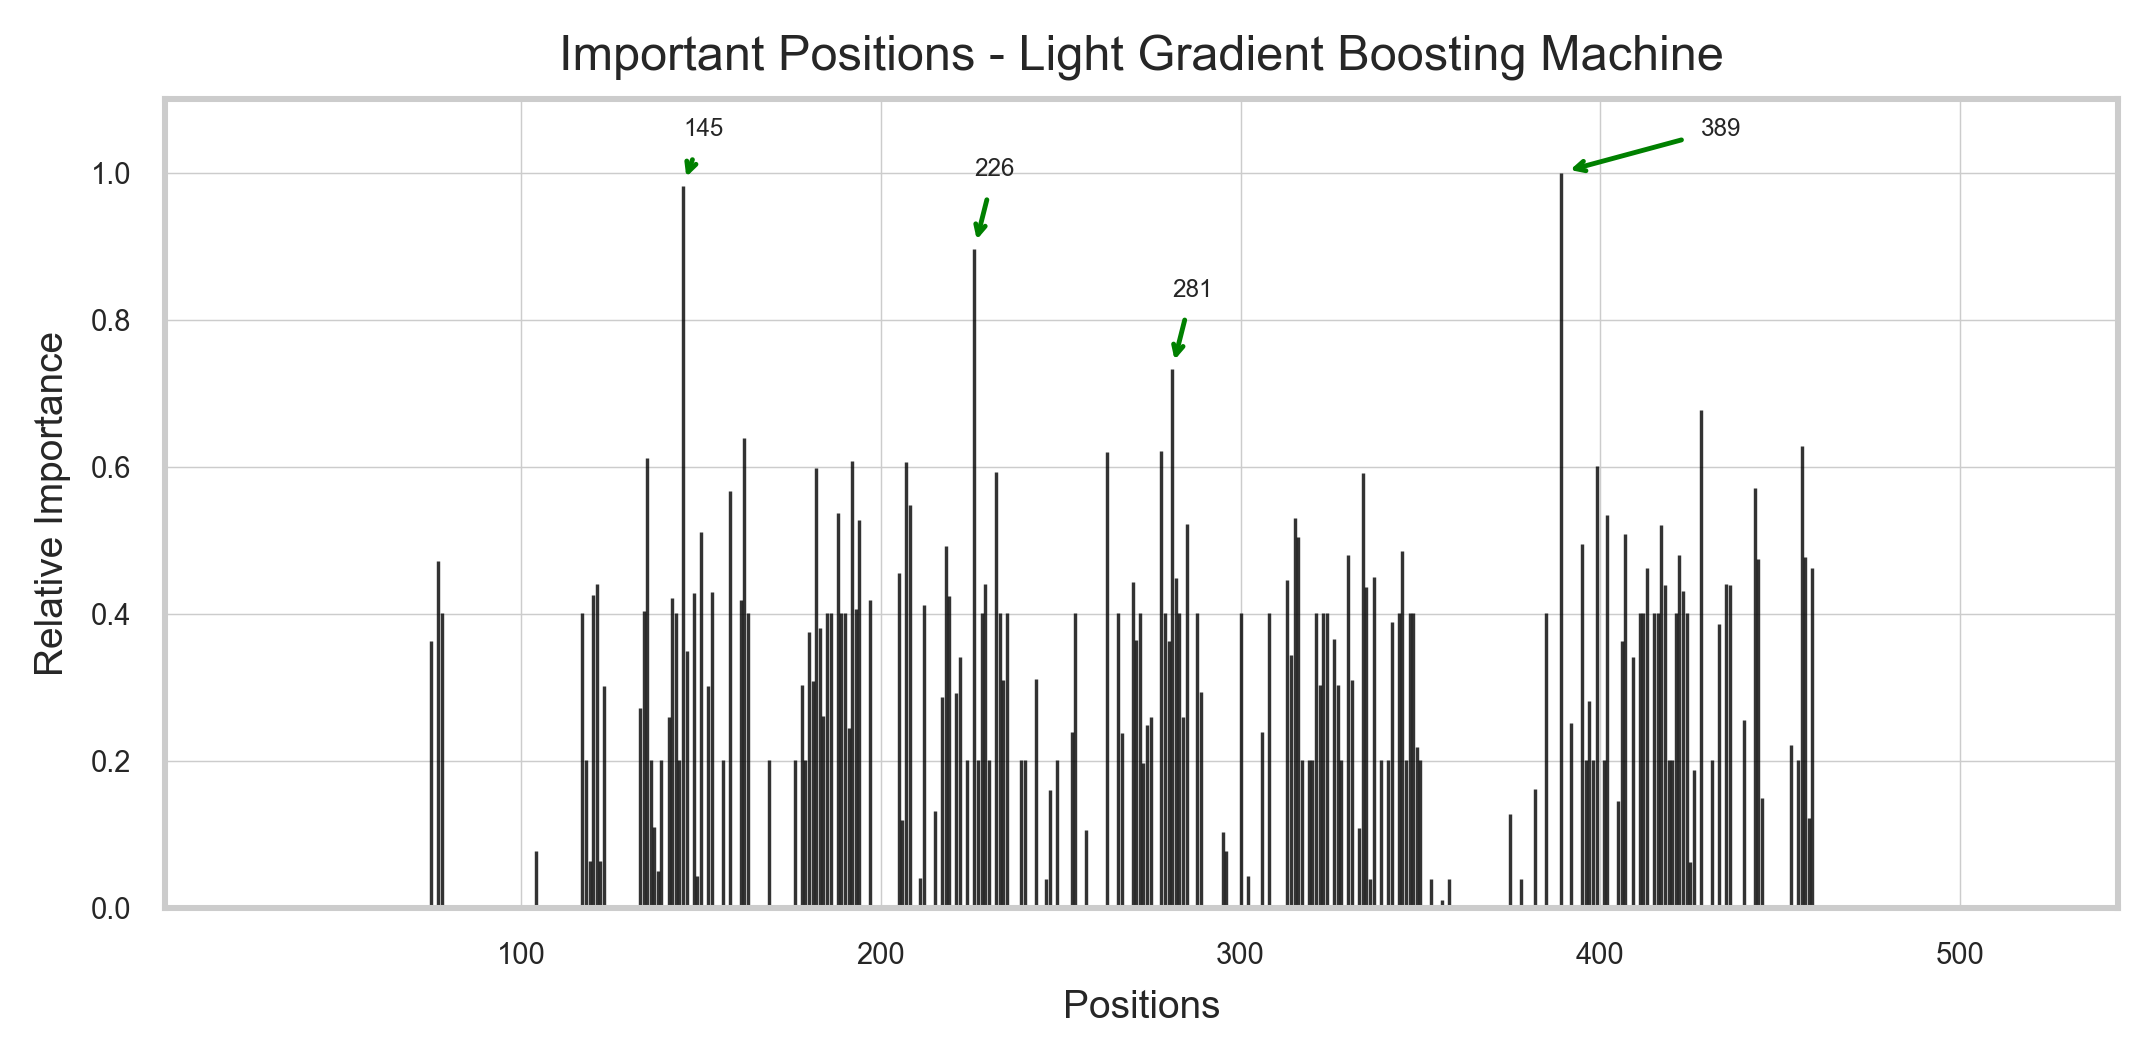

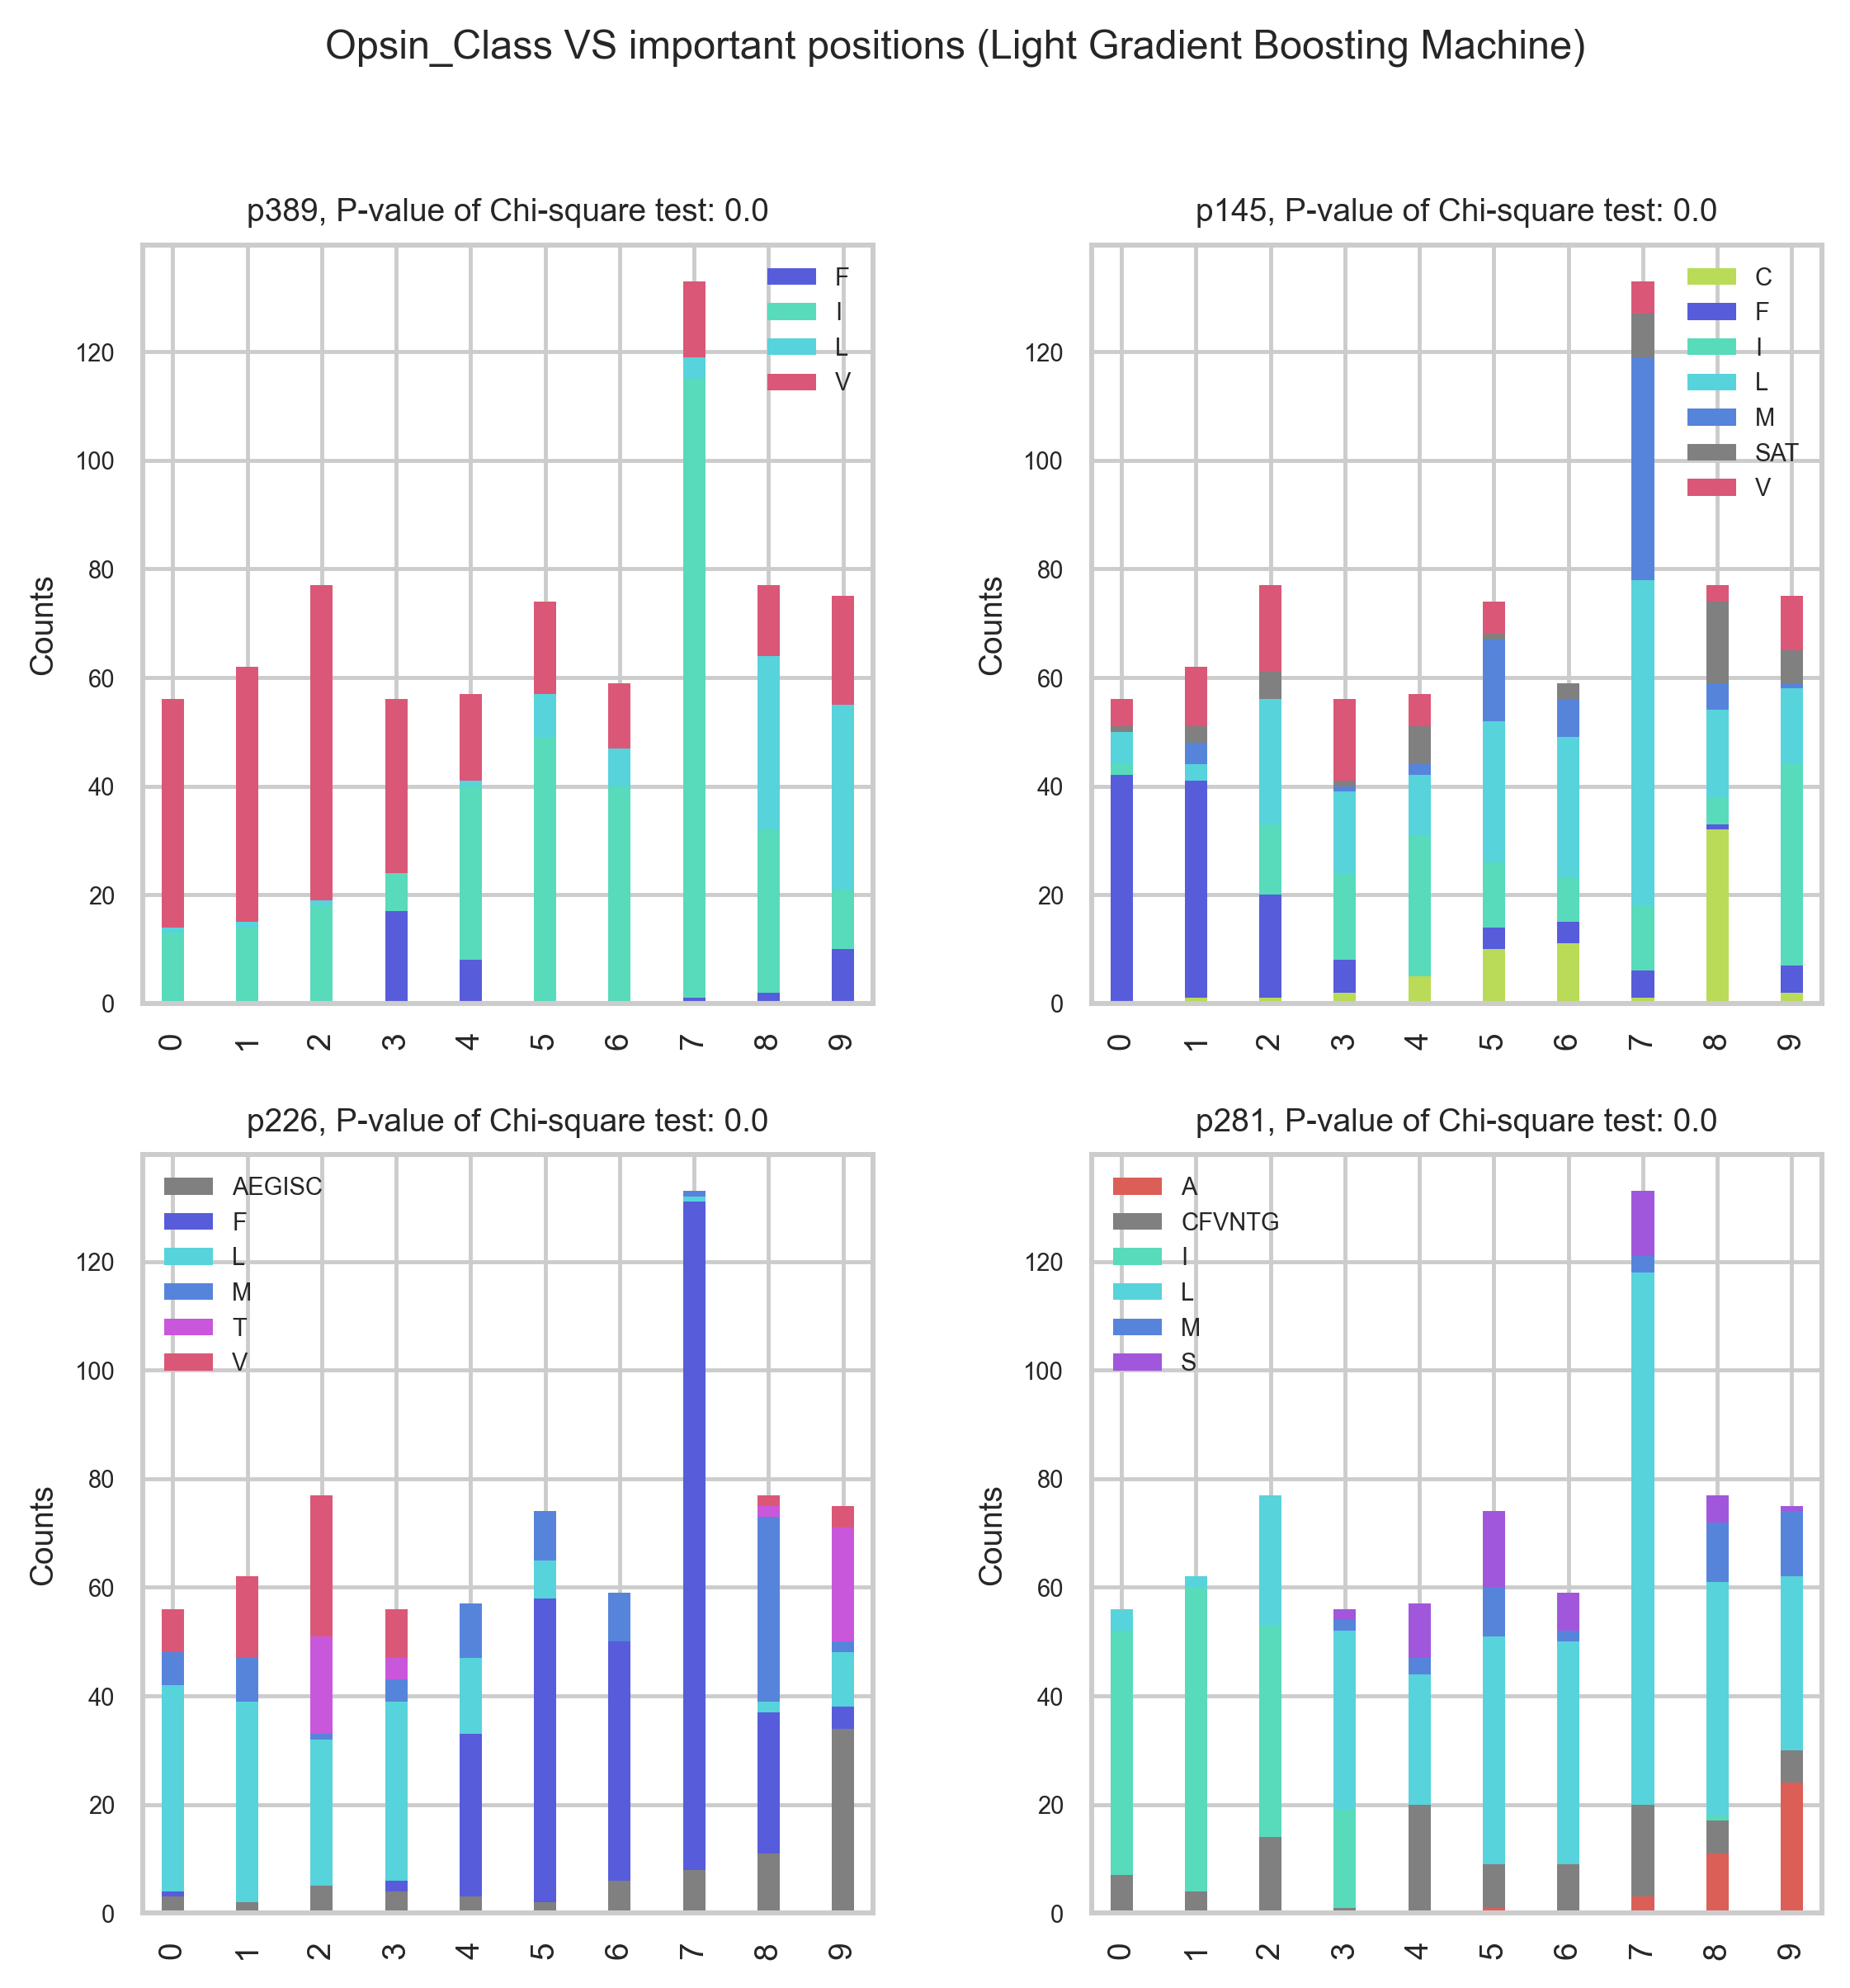

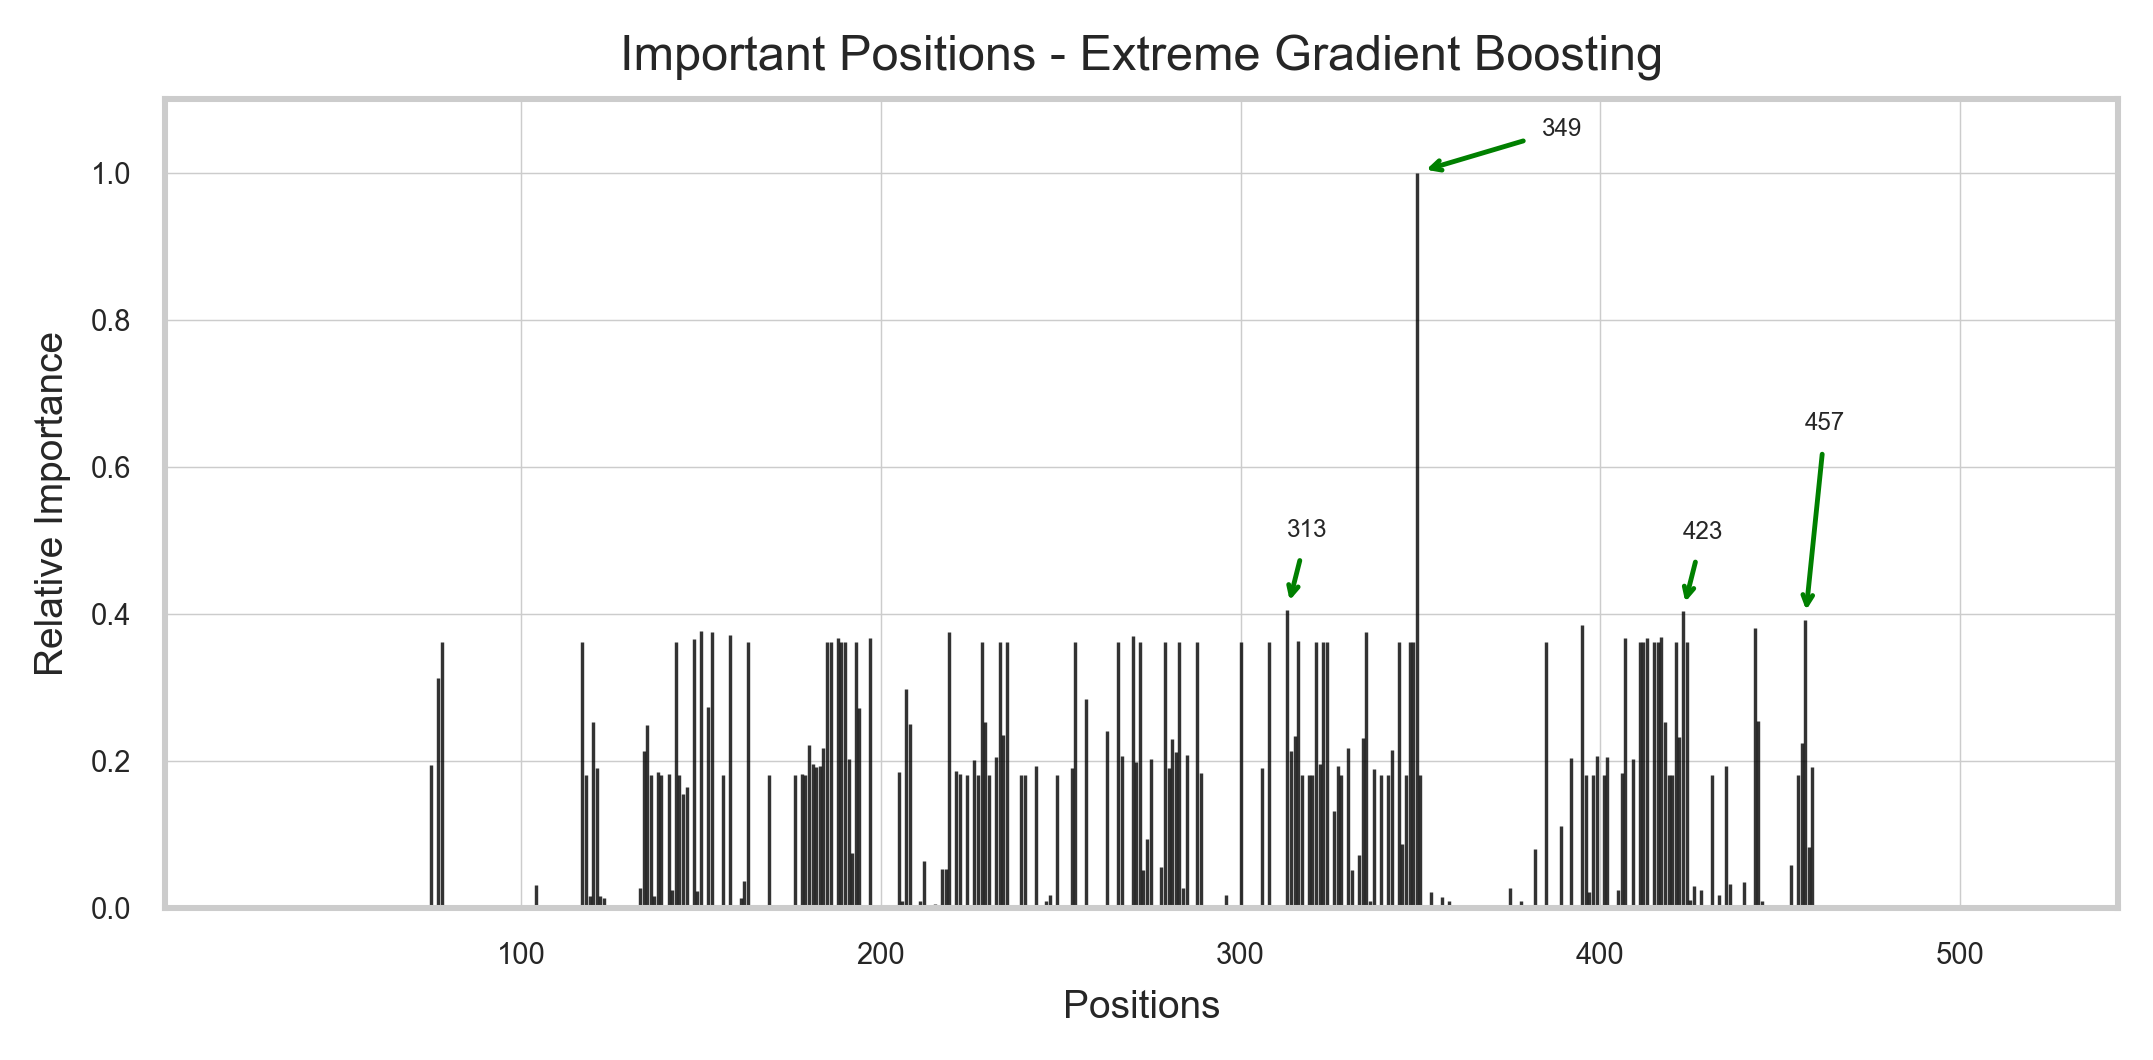

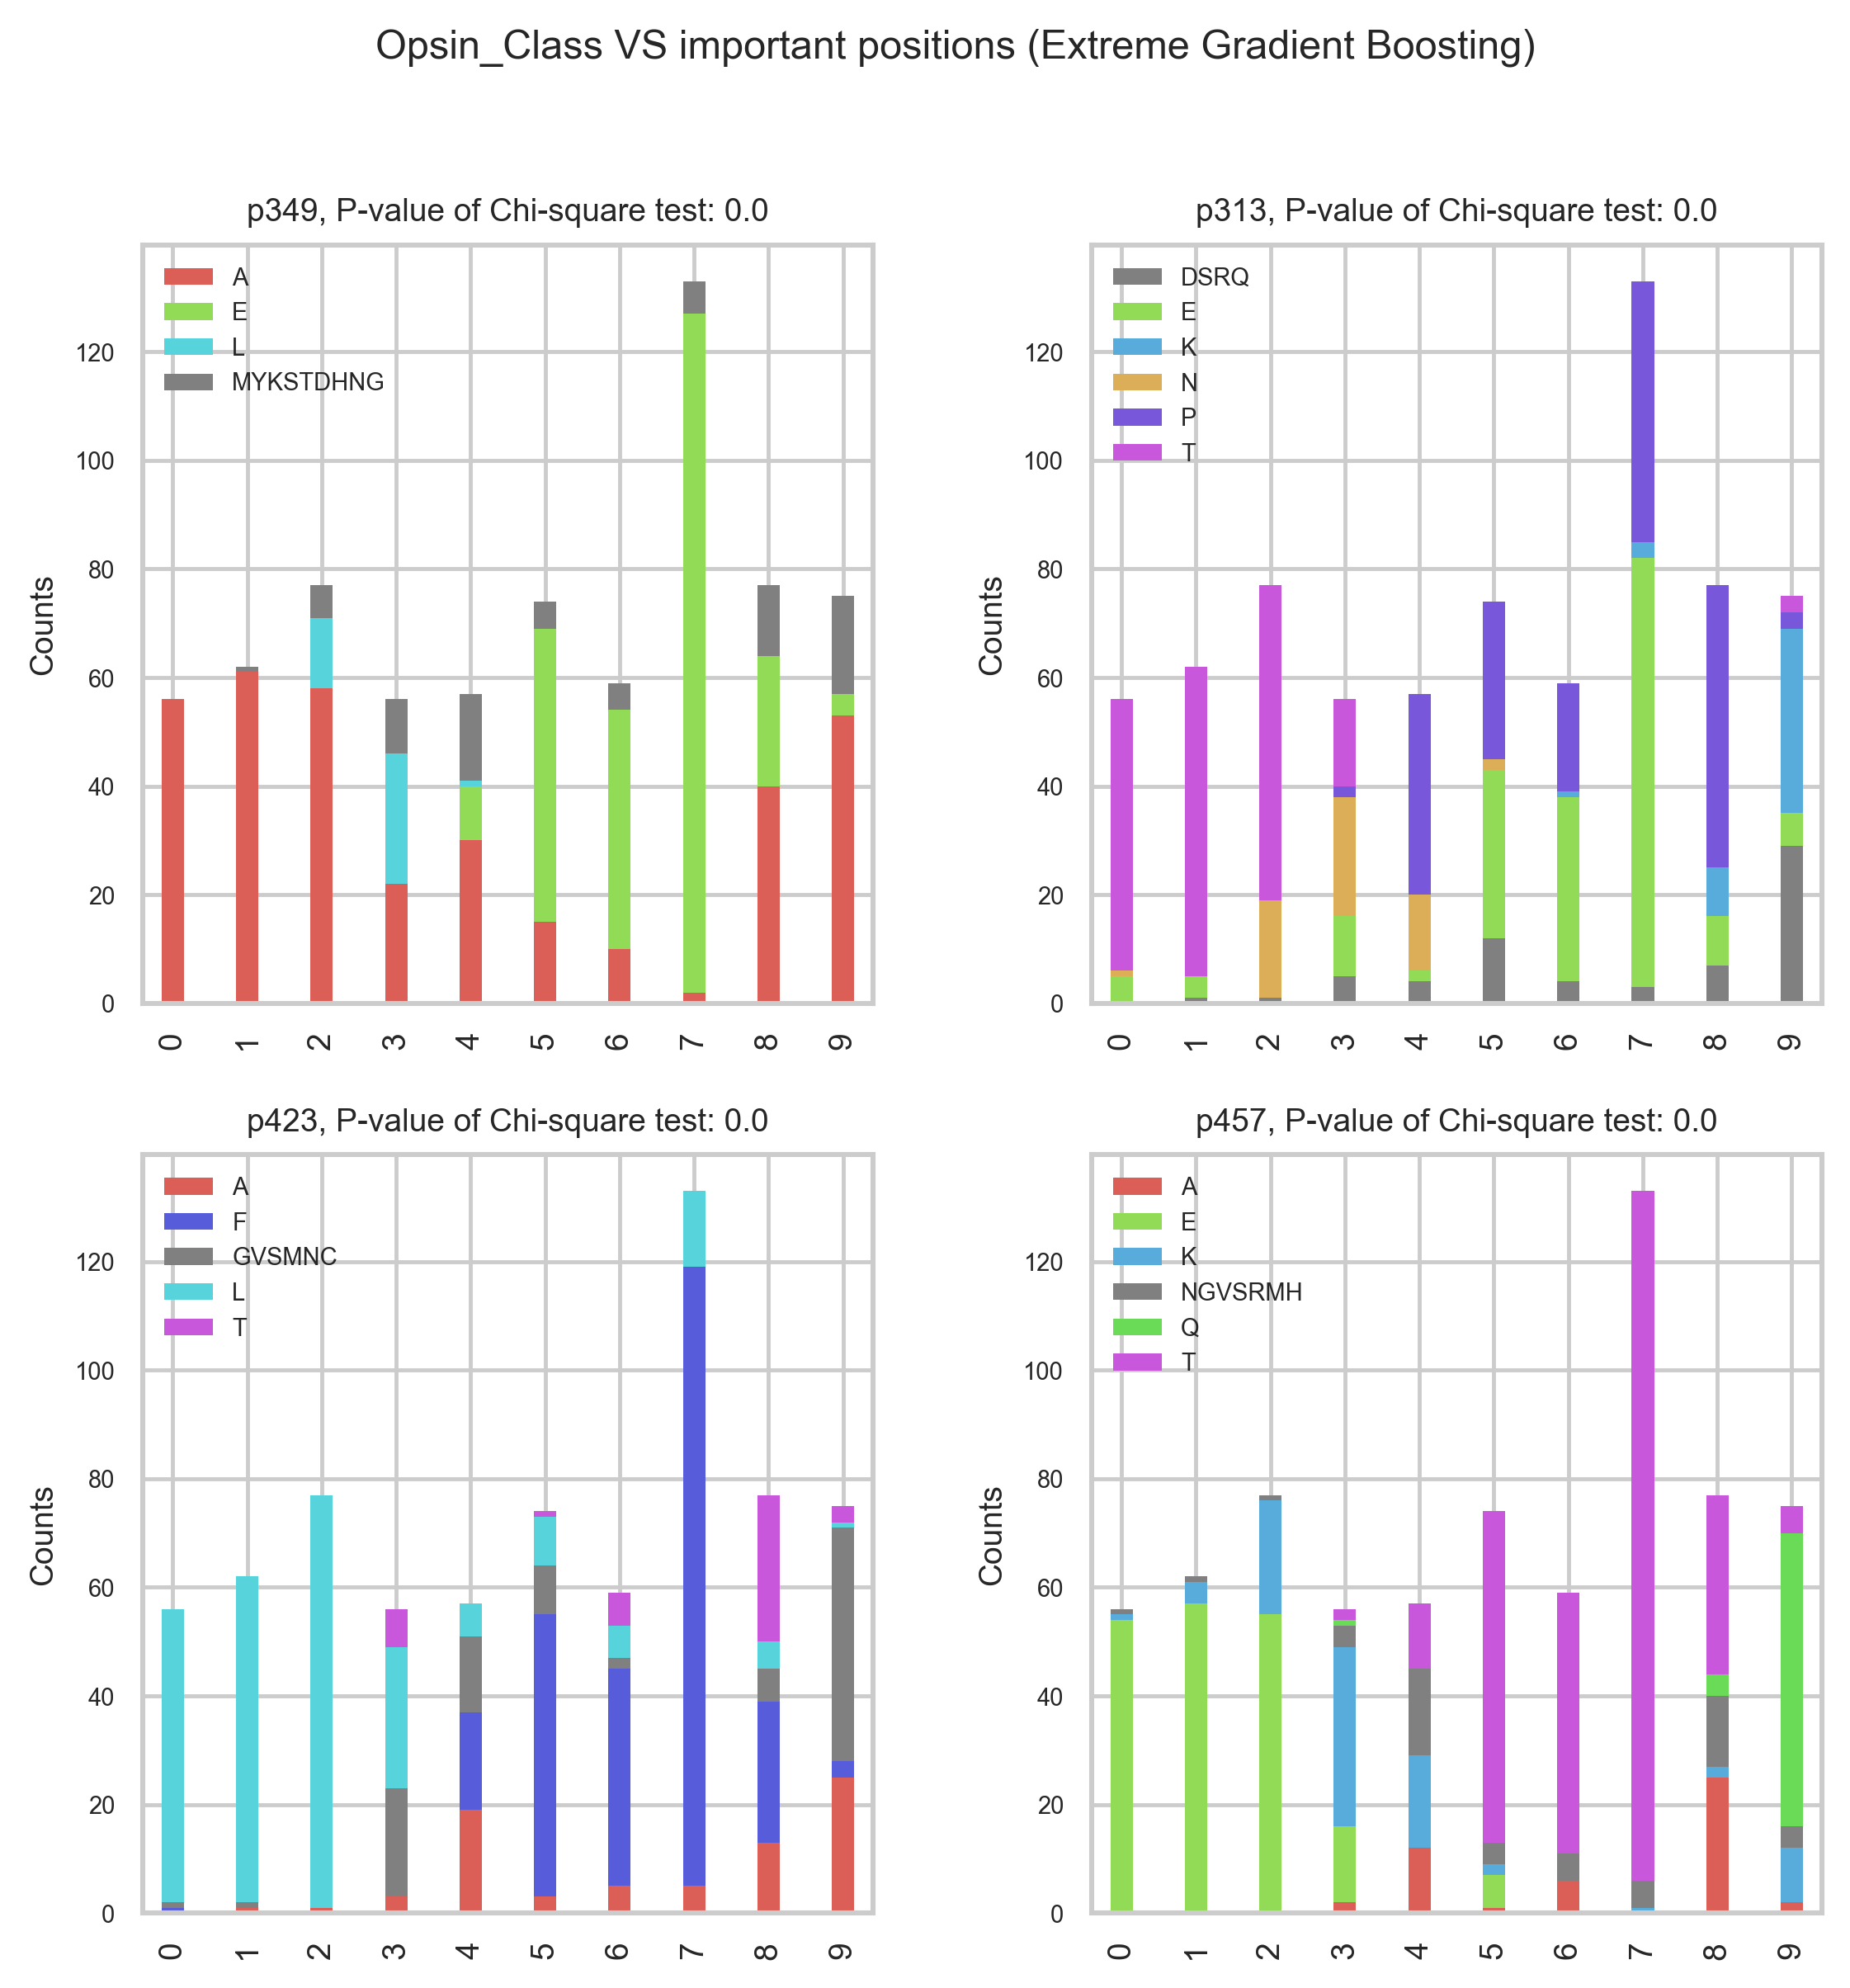

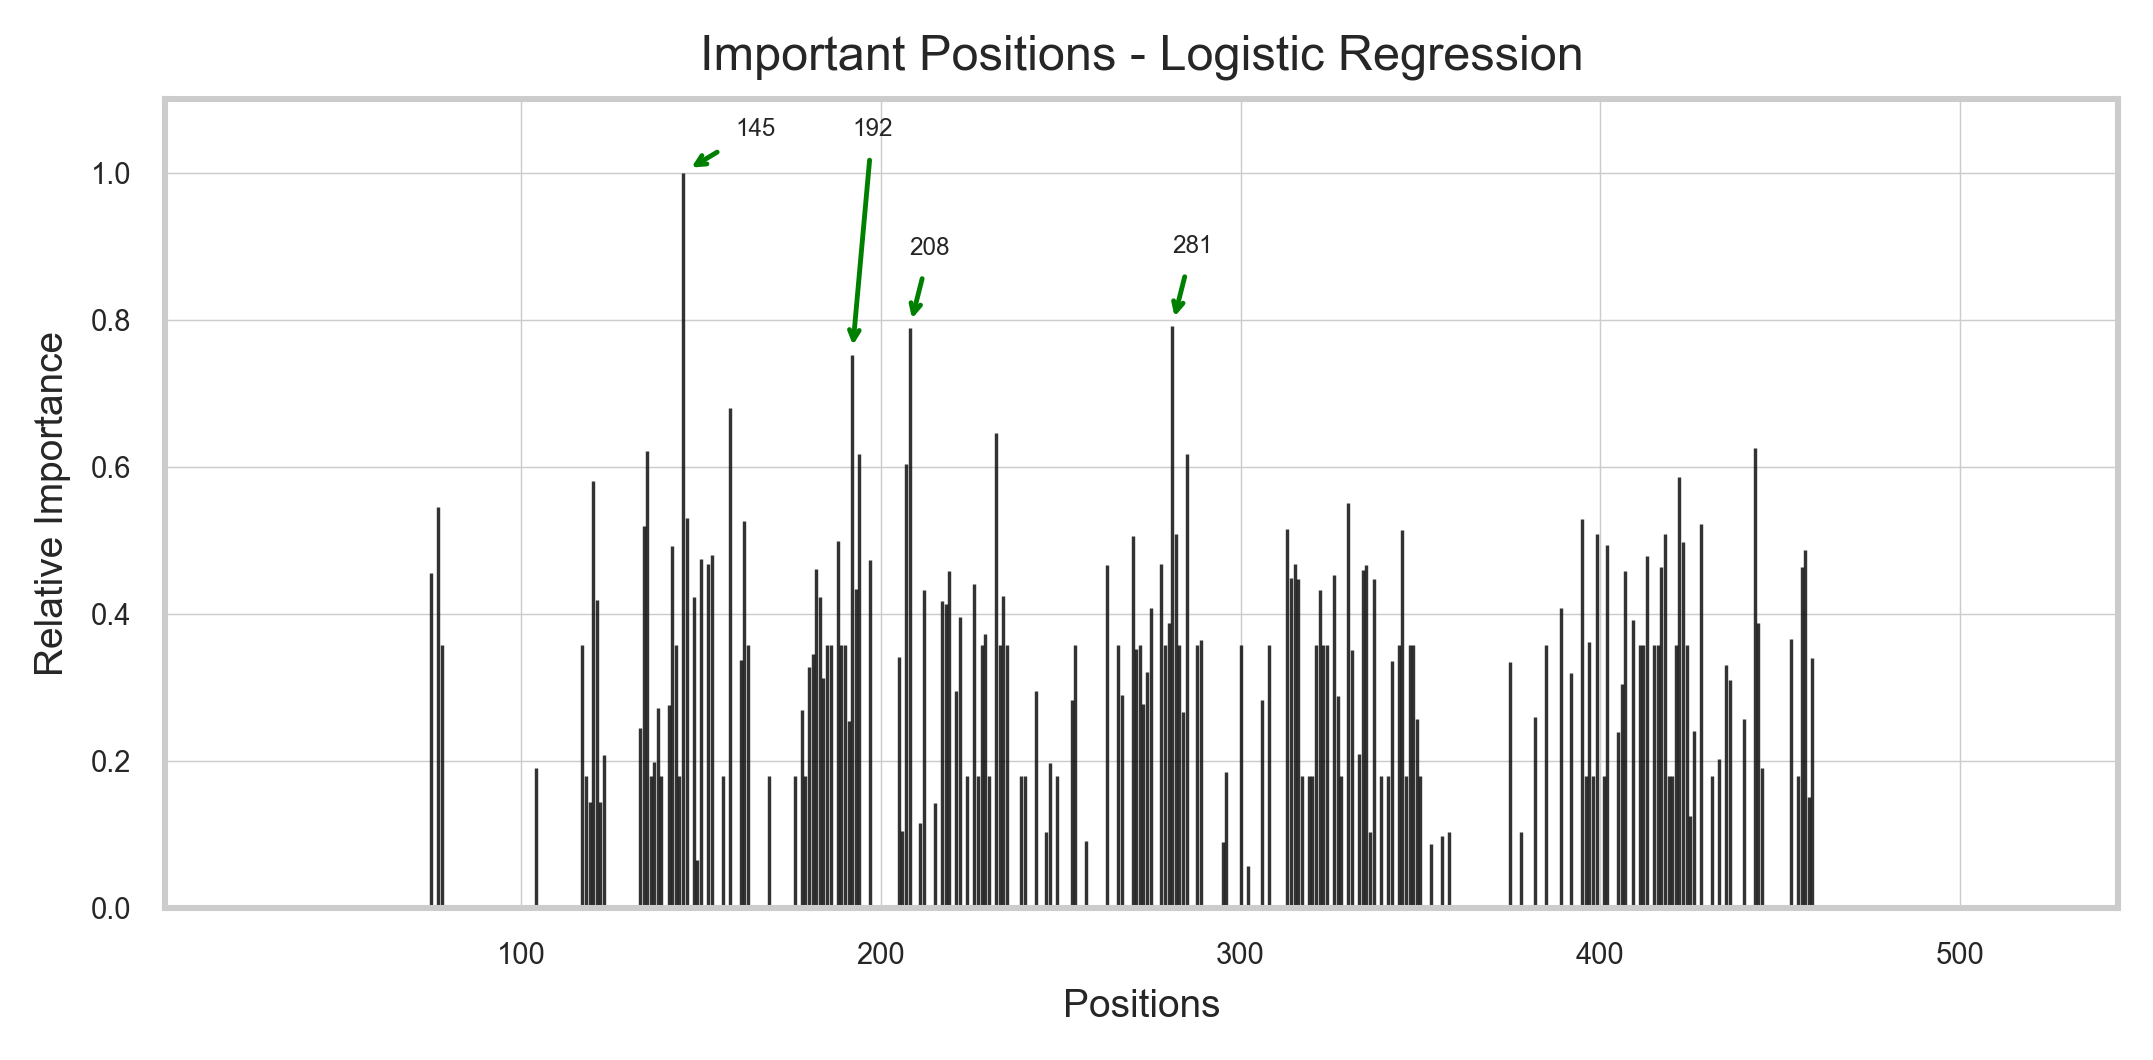

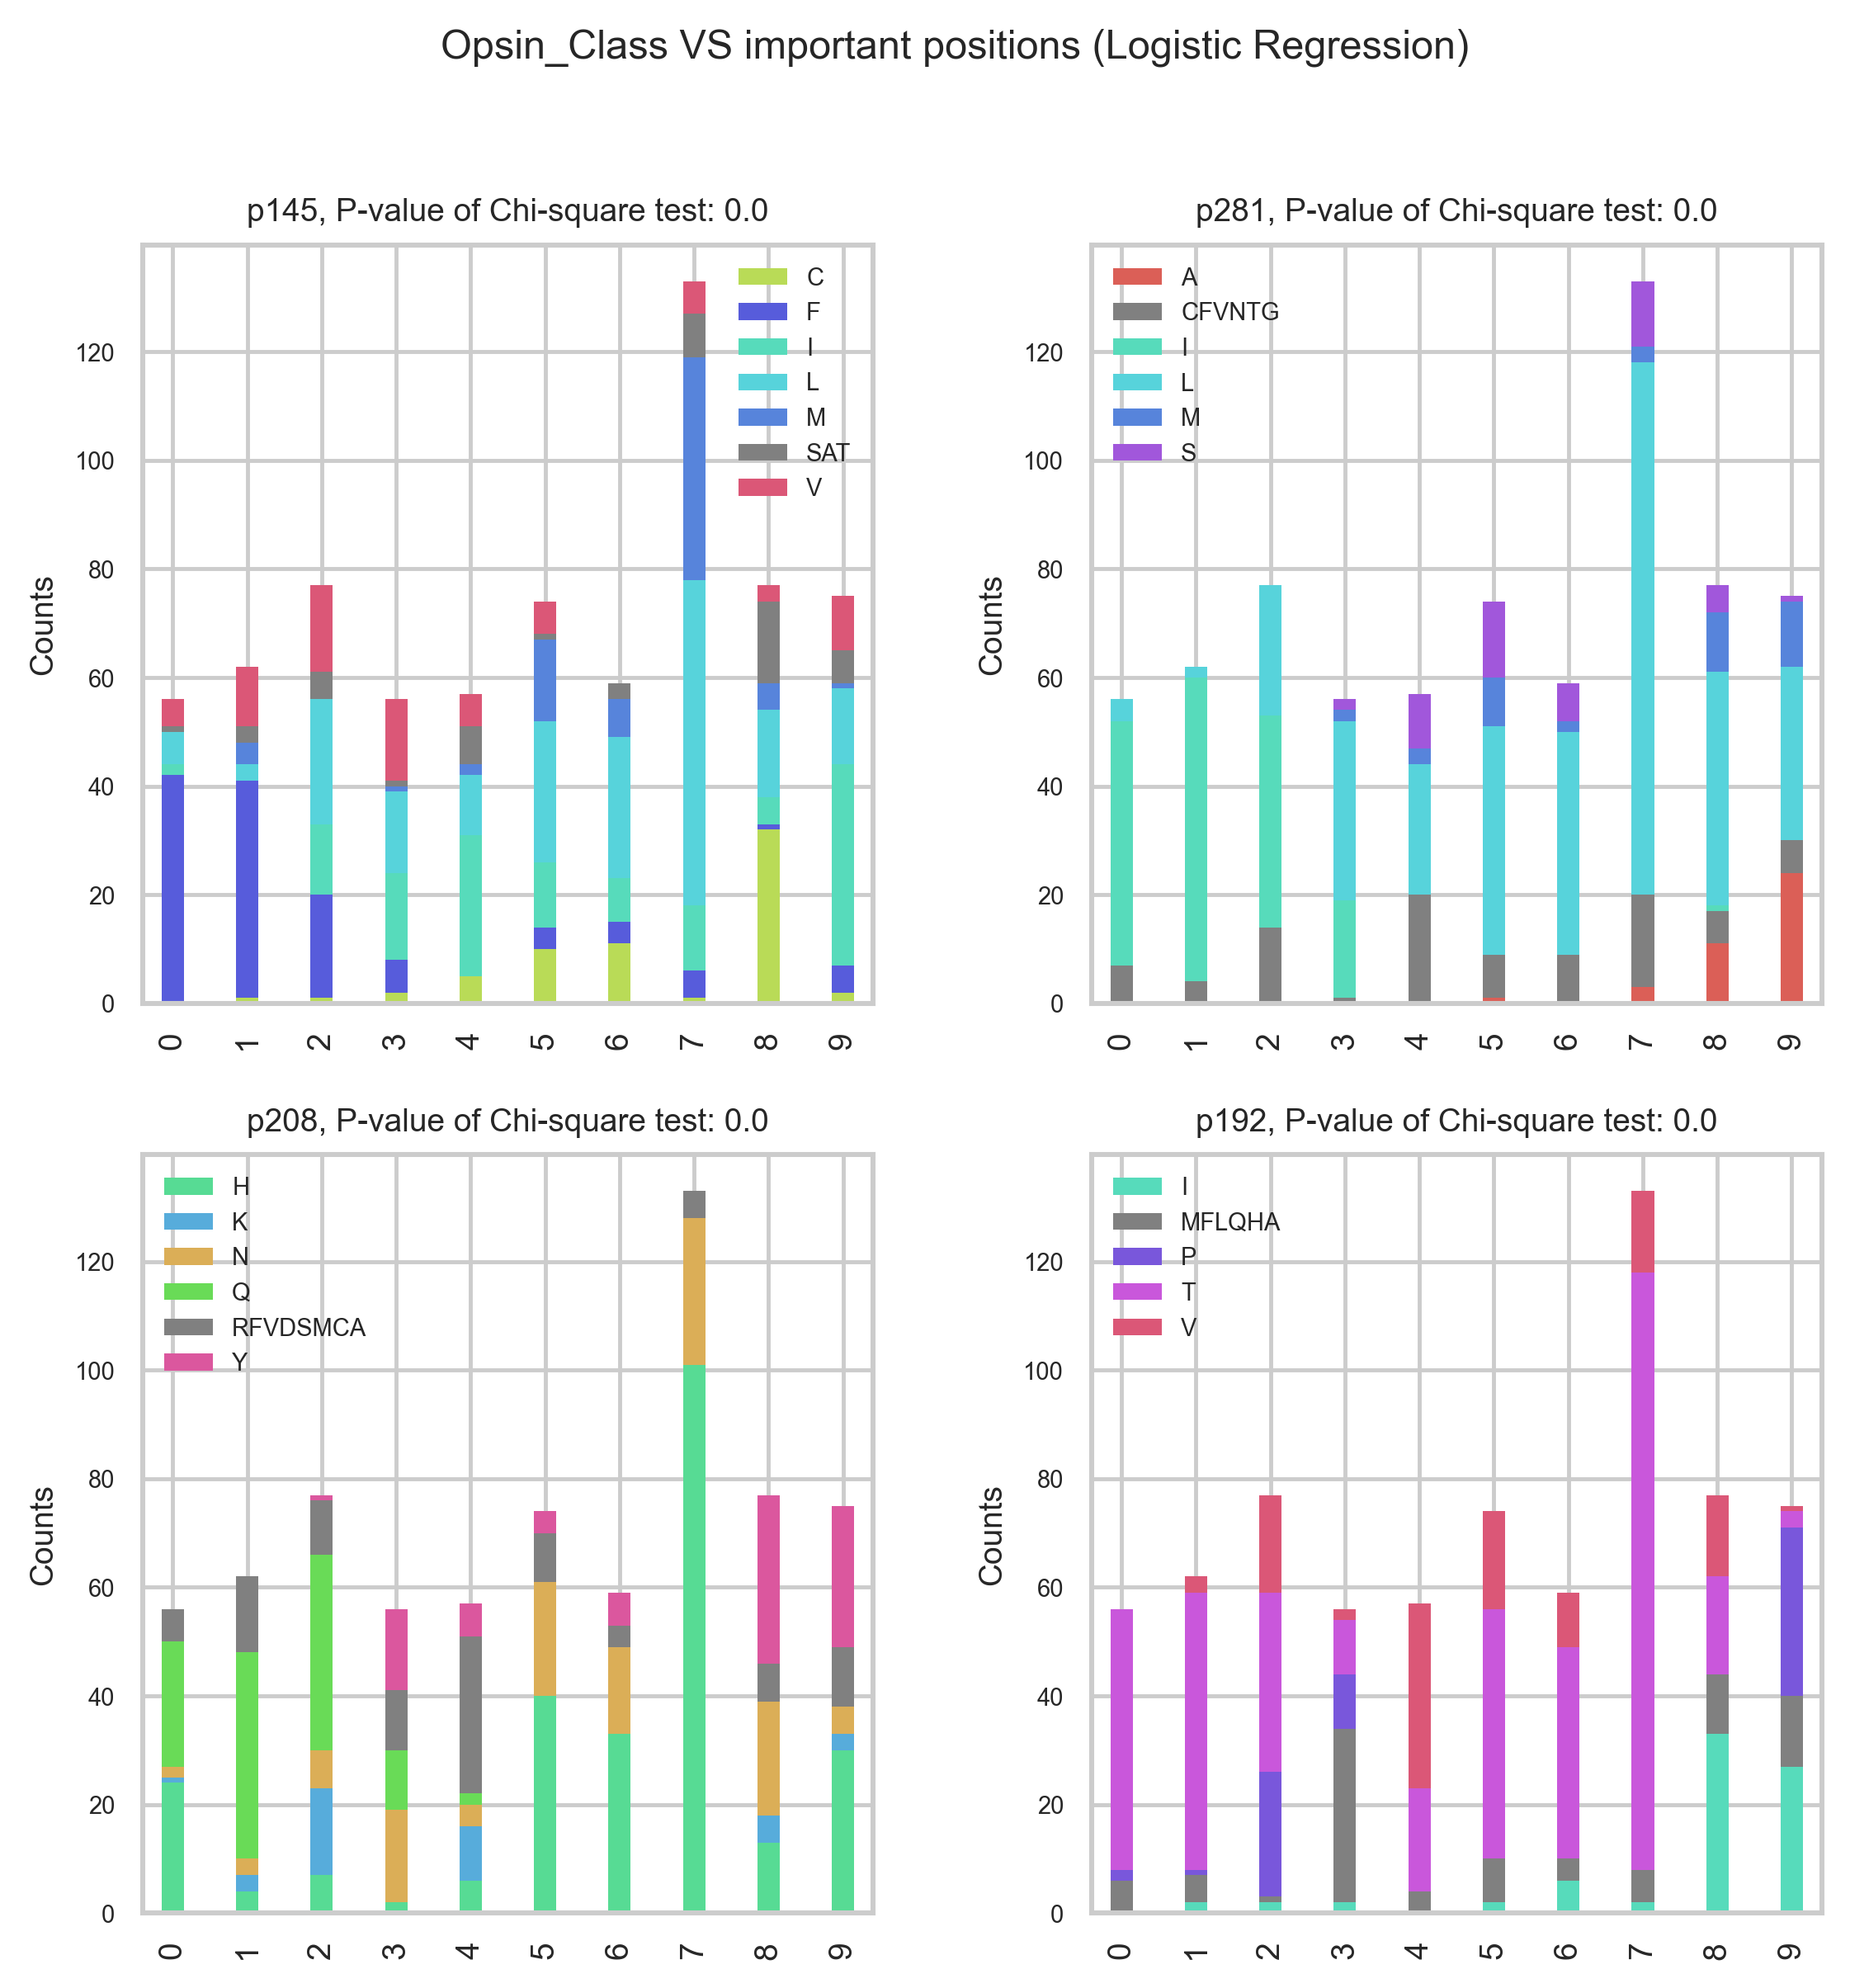

In [23]:
for i in range(models_to_select):
    # calculate the featre importances
    imp = ml.fimp_single(trained_model=top_models[i], model_name=model_names[i],
                         train_cols=train_cols, grouped_features=dc,
                         n_positions=positions, report_dir=report_dir)
    # visualize the lollipop plot for features based on each model
    viz.dp_plot(dat = imp, model_name= model_names[i],imp_col='standard_value', report_dir=report_dir)
    
    # visualize the boxplots for features based on each model
    viz.plot_imp_model(dat=df, trained_model=top_models[i],
                       model_name=model_names[i],
                       train_cols=train_cols, grouped_features=dc,
                       meta_var=mt, n_positions=positions,
                       model_type=anaType, report_dir=report_dir)

    #file2 = open('interpret_cols.txt', 'a+')
    #training = str(df.to_string)
    #file2.write(training)
    #file2.close()

meanDone


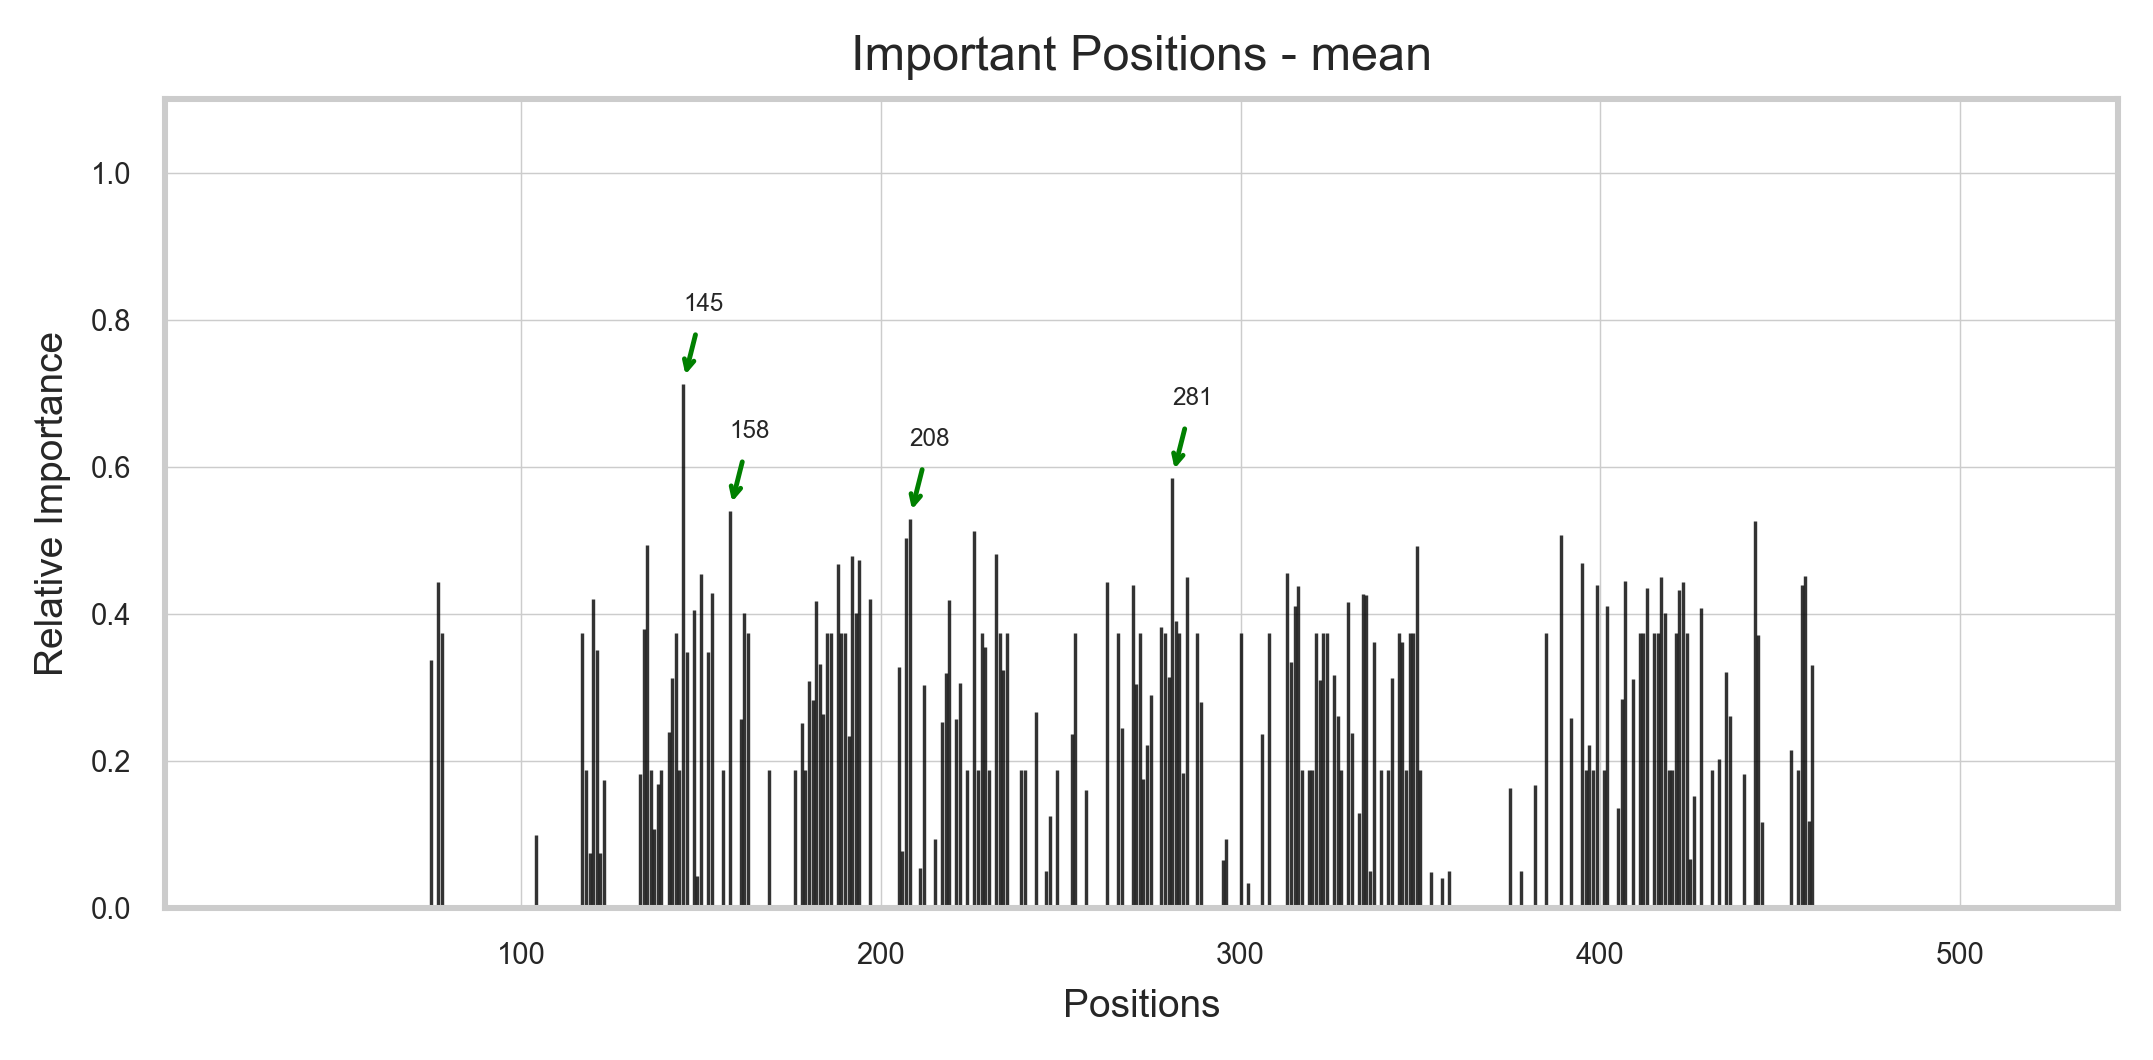

In [24]:
# merging the results for all the top models
mean_imp = ml.fimp_top_models(trained_models=top_models, model_names=model_names, 
                              train_cols=train_cols,grouped_features=dc,
                              n_positions=positions,report_dir=report_dir)

# lollipop plot for the merged results
viz.dp_plot(dat=mean_imp,
            model_name= 'mean',
            imp_col='mean_imp', 
            report_dir=report_dir)

<span style="color:red">**Running the next cell will produce individual plots for all of the positions in you sequence.**</span>

{'p240': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p240, P-value: 0.0'}, ylabel='Counts'>),
 'p120': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p120, P-value: 0.0'}, ylabel='Counts'>),
 'p382': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p382, P-value: 0.0'}, ylabel='Counts'>),
 'p179': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p179, P-value: 0.0'}, ylabel='Counts'>),
 'p432': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p432, P-value: 0.0'}, ylabel='Counts'>),
 'p373': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p373, P-value: 0.0'}, ylabel='Counts'>),
 'p312': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p312, P-value: 0.0'}, ylabel='Counts'>),
 'p387': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p387, P-value: 0.0'}, ylabel='Counts'>),
 'p178': (<Figure size 700x1050 

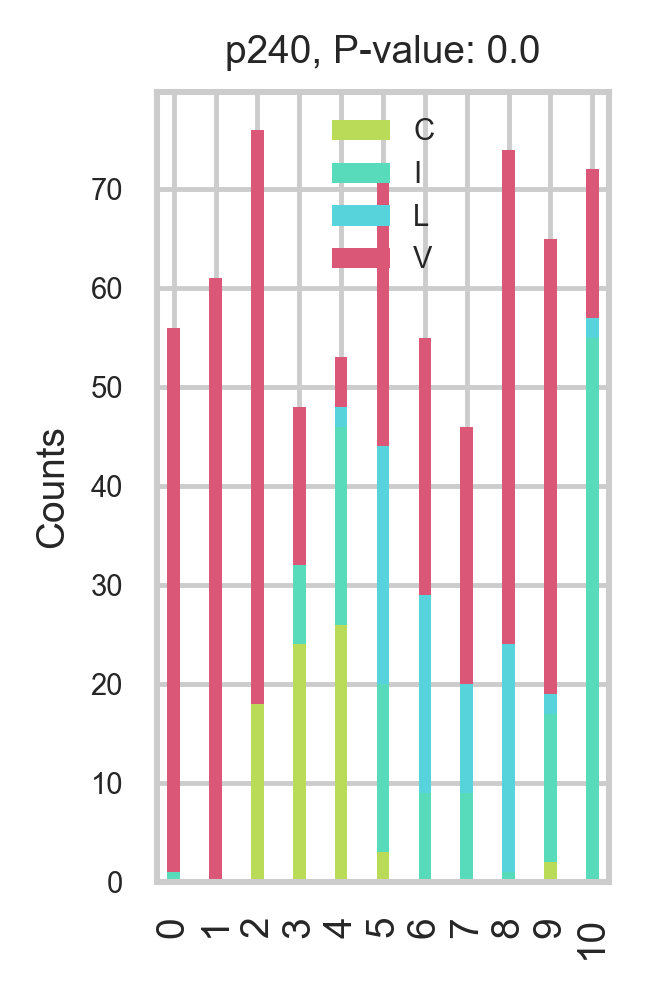

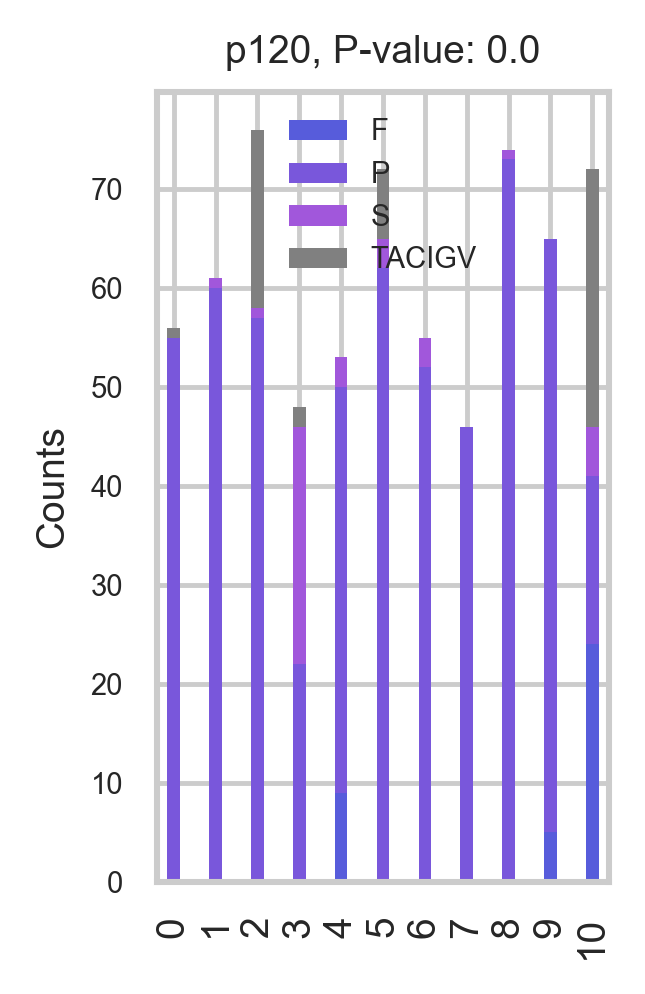

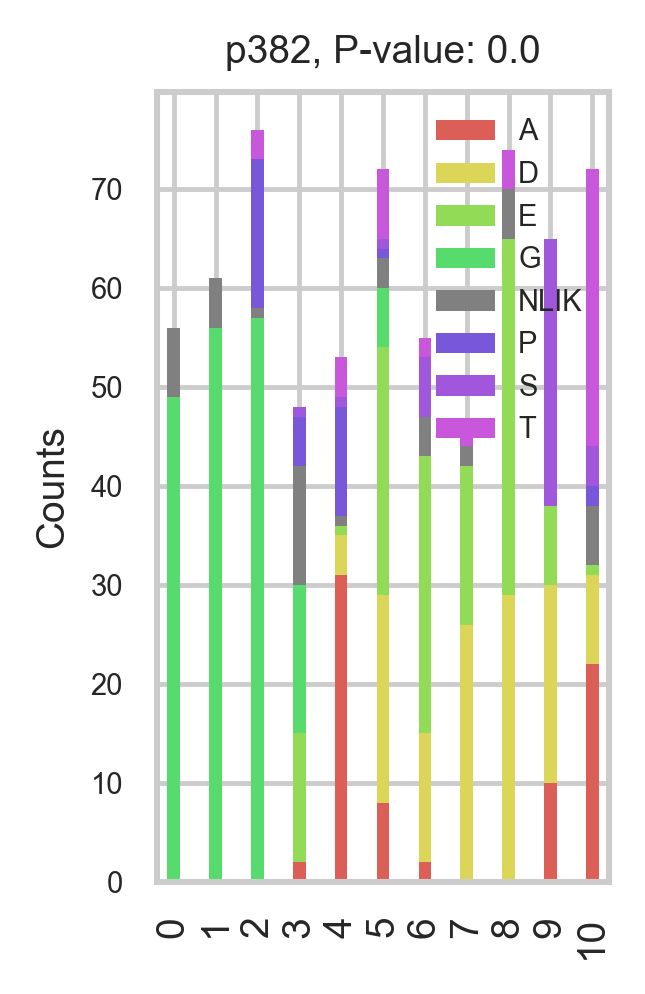

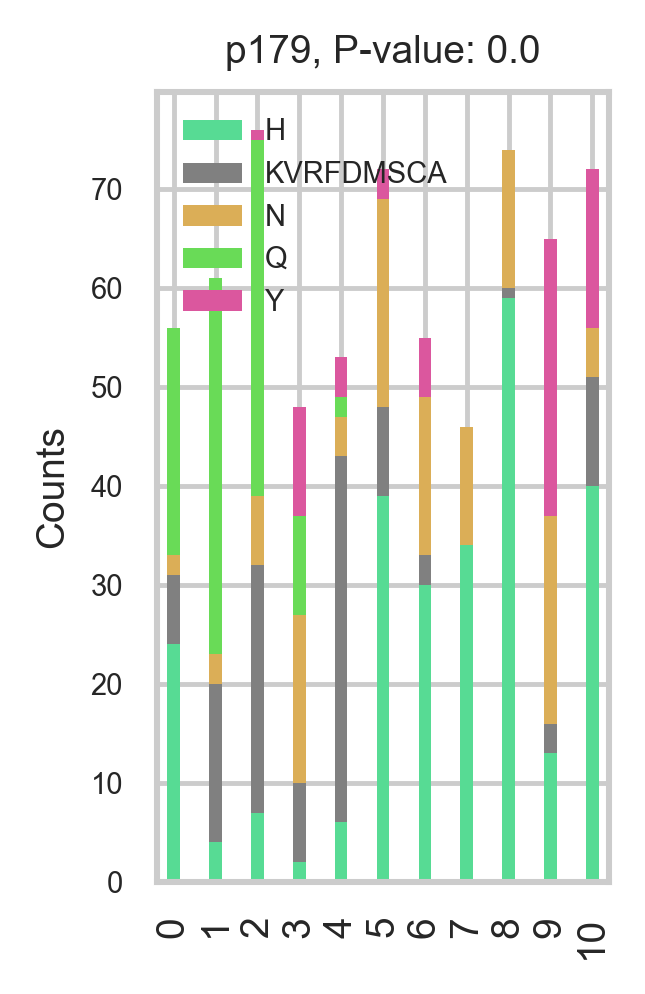

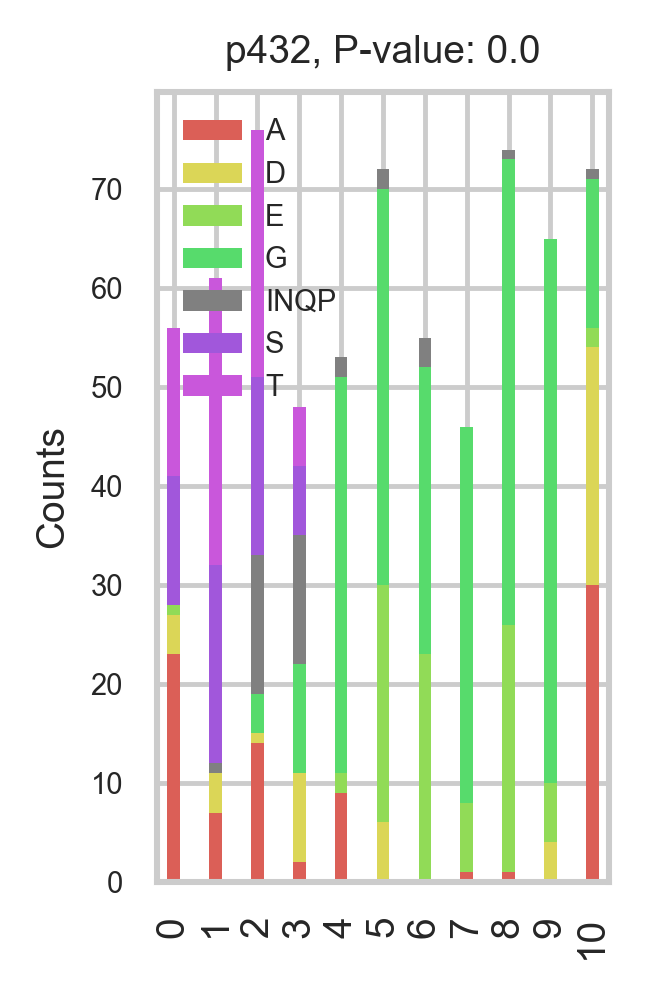

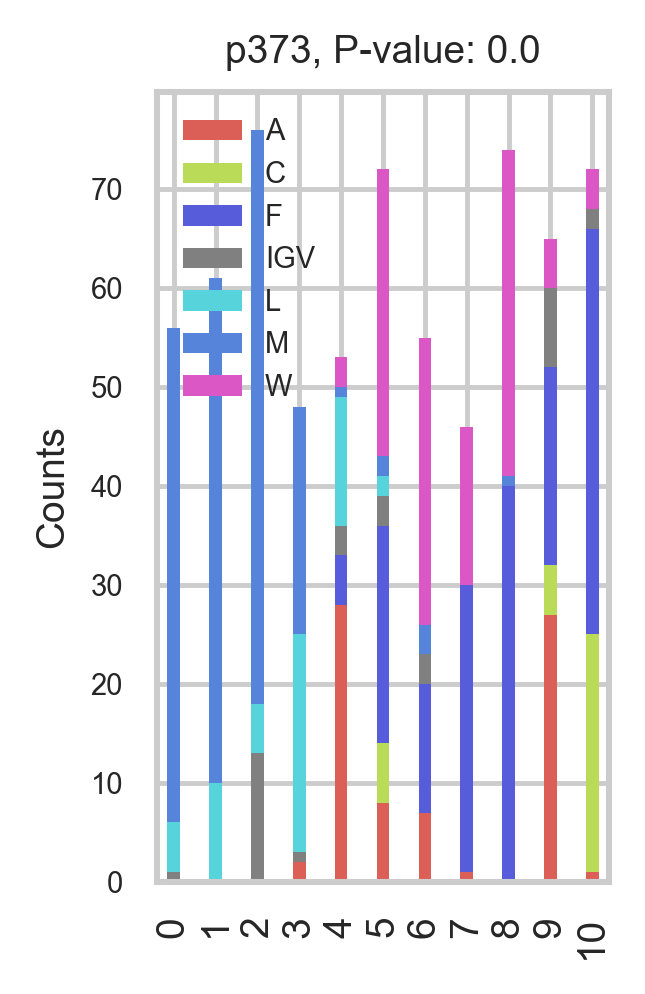

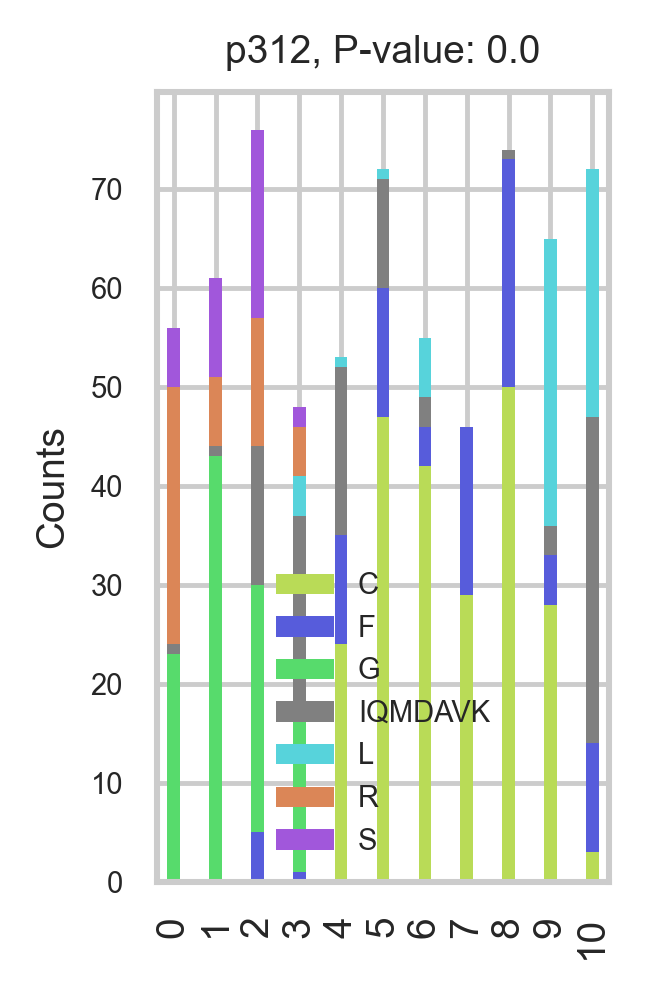

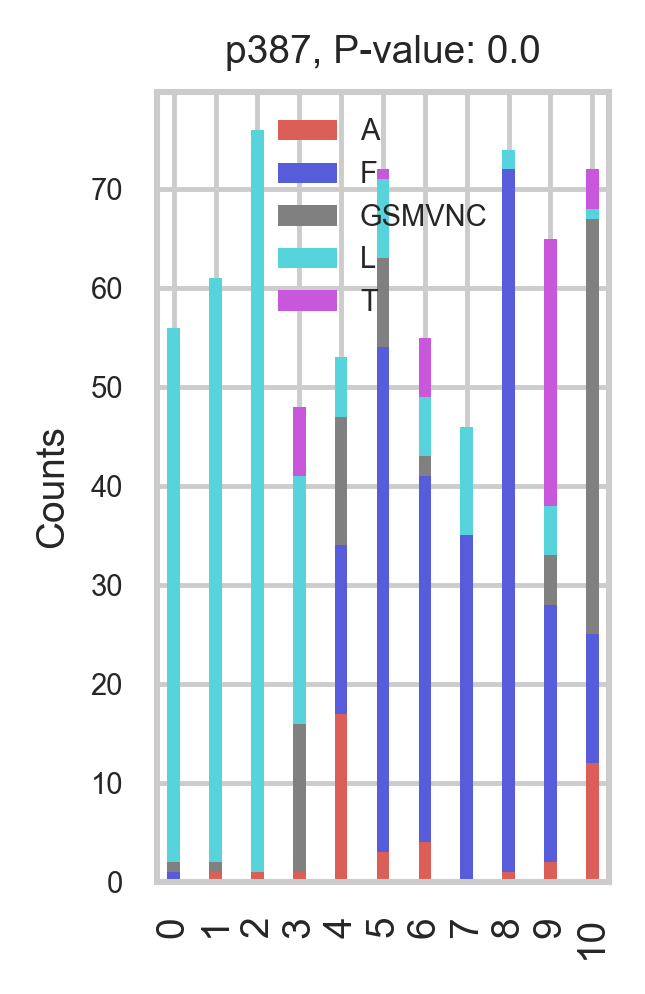

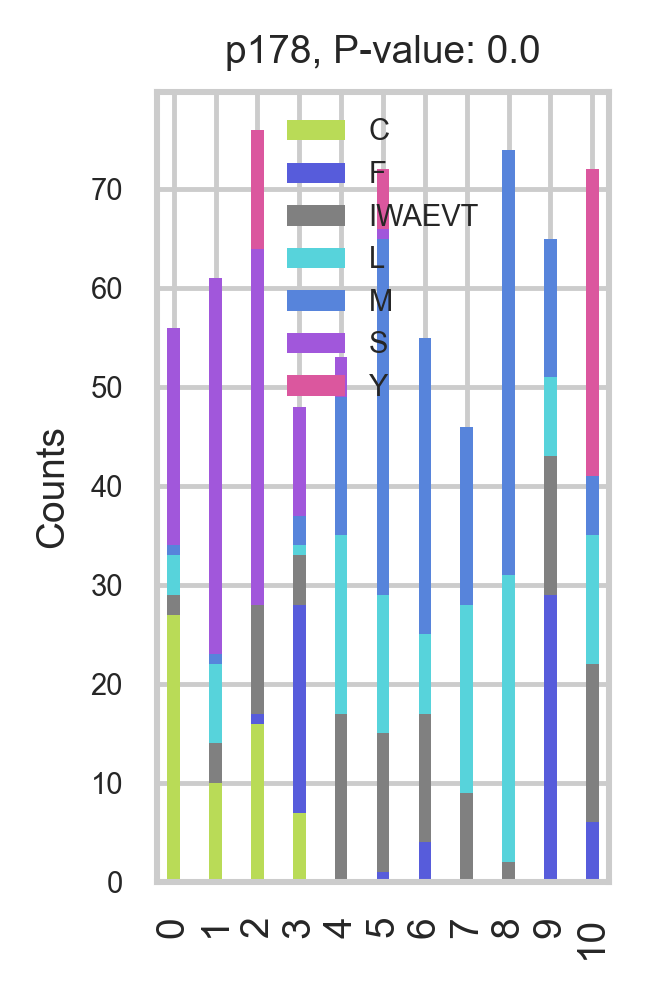

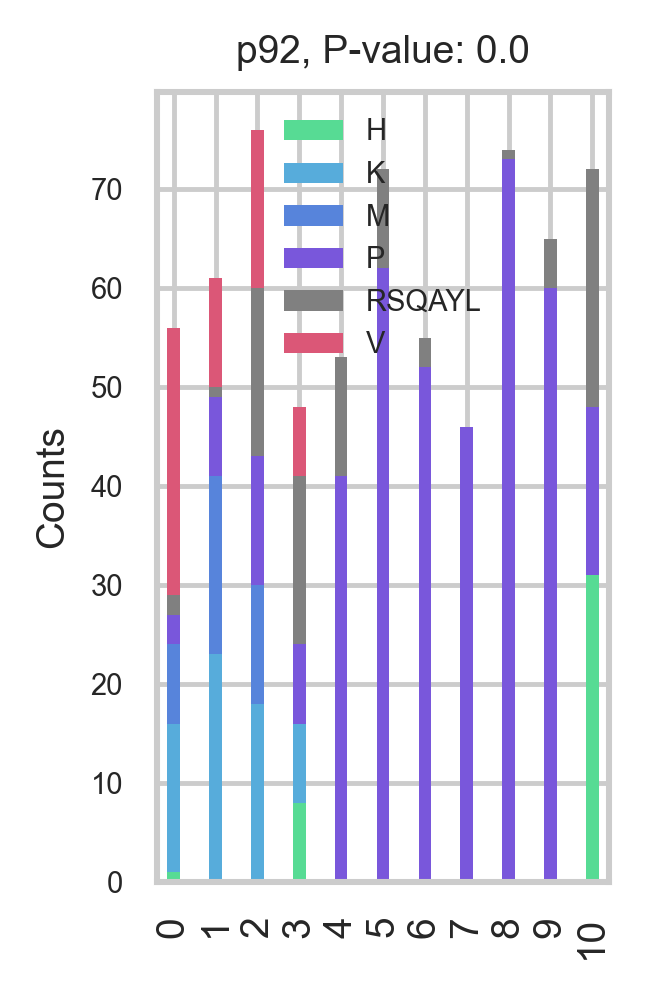

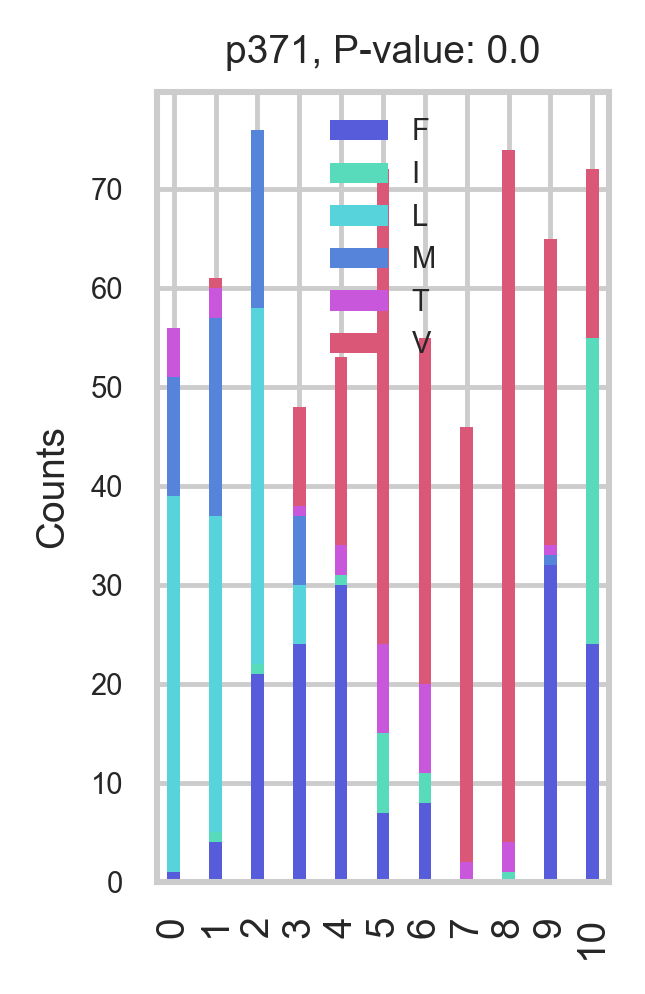

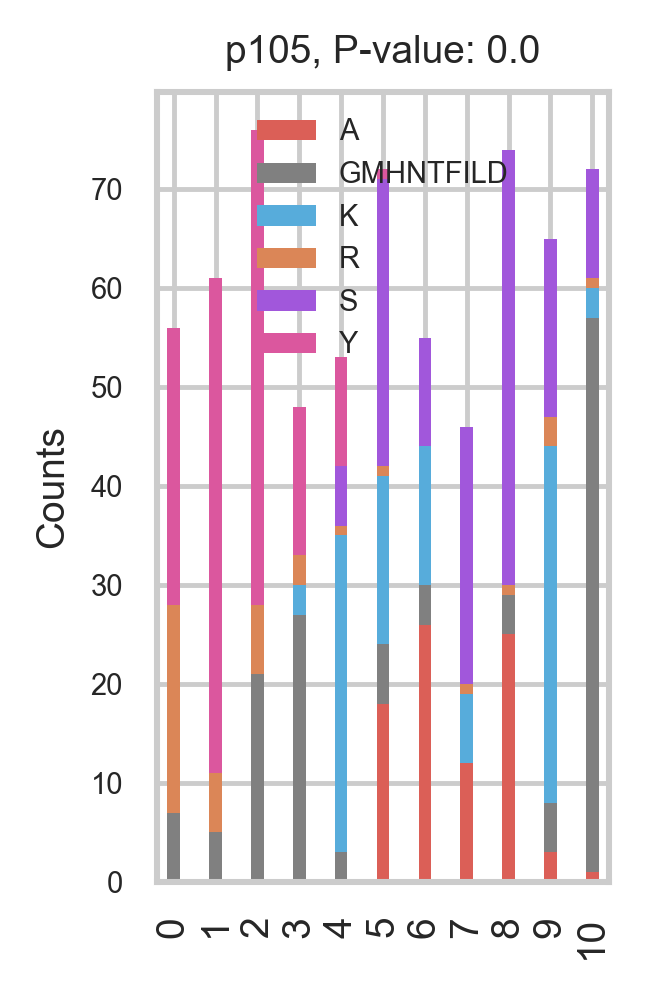

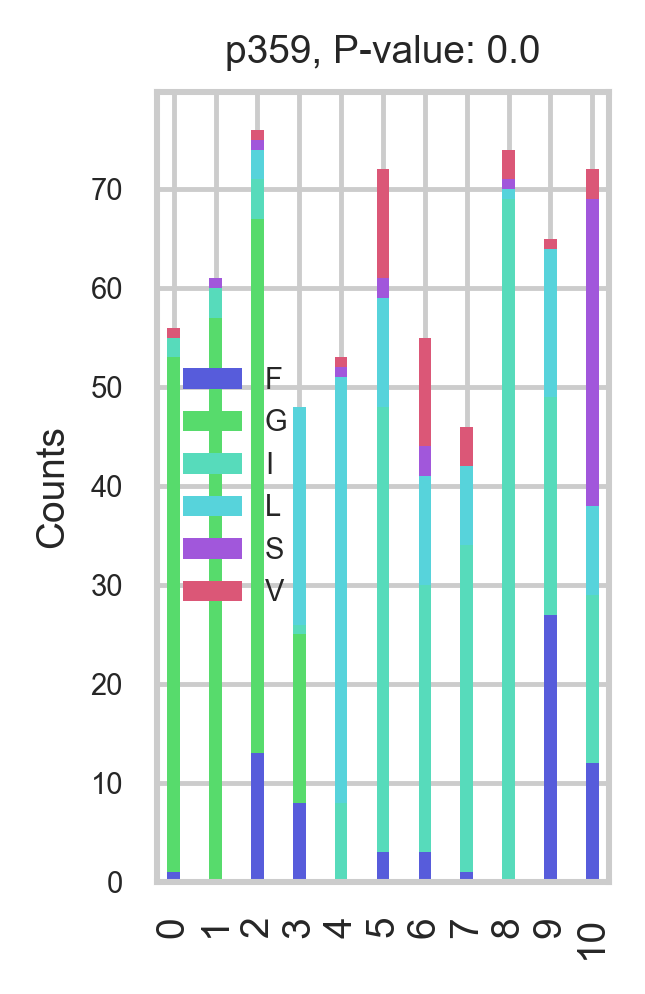

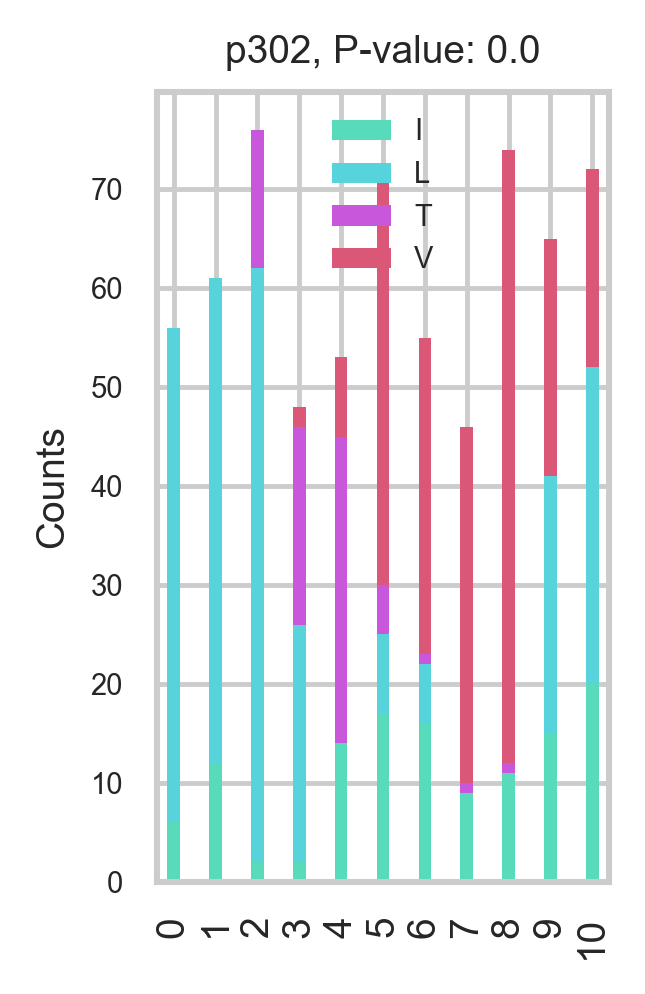

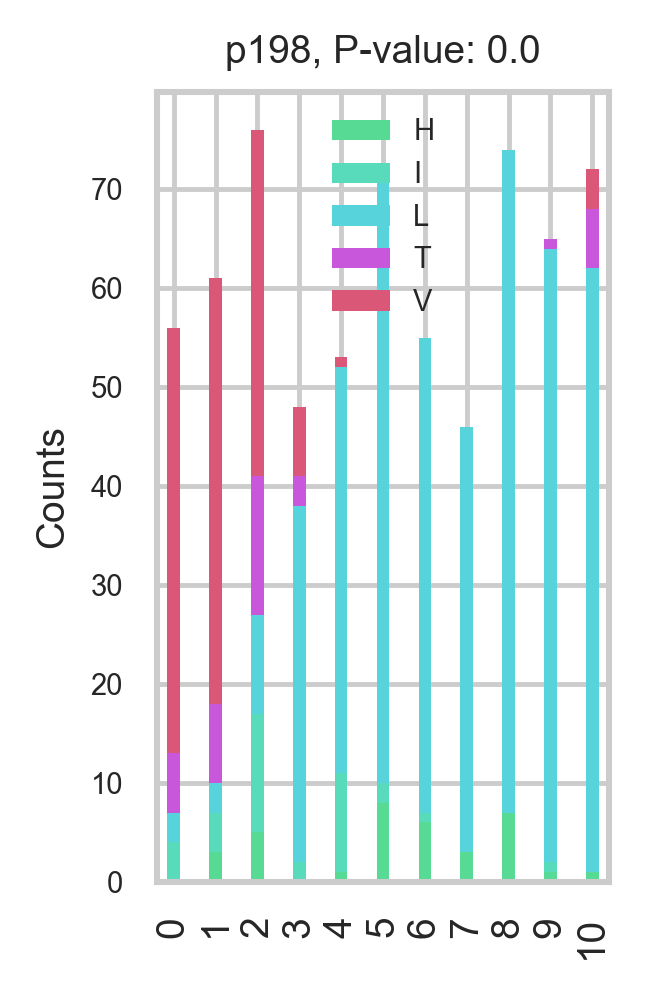

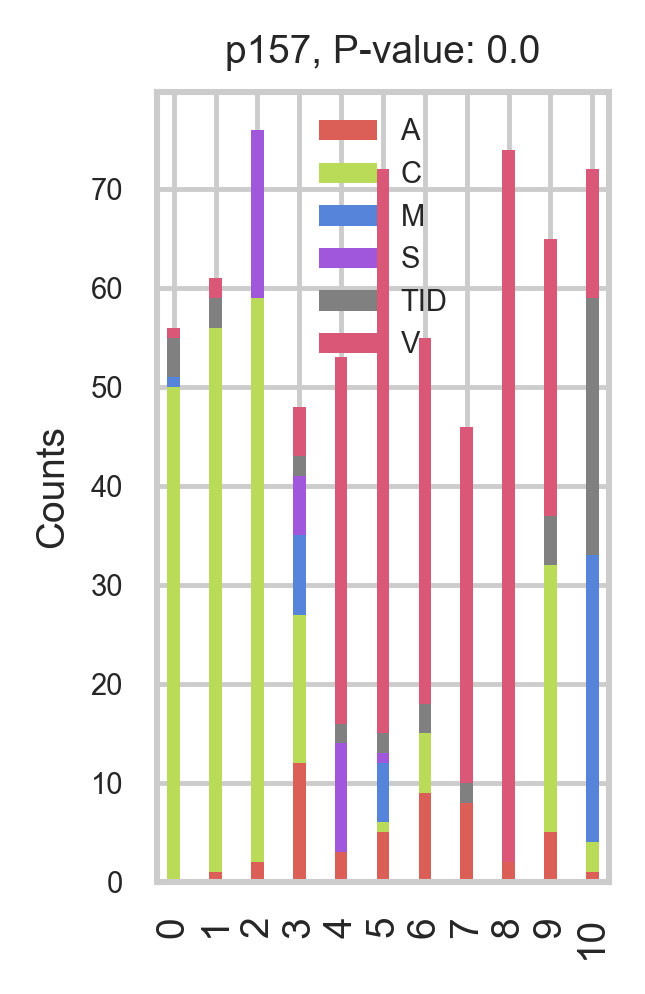

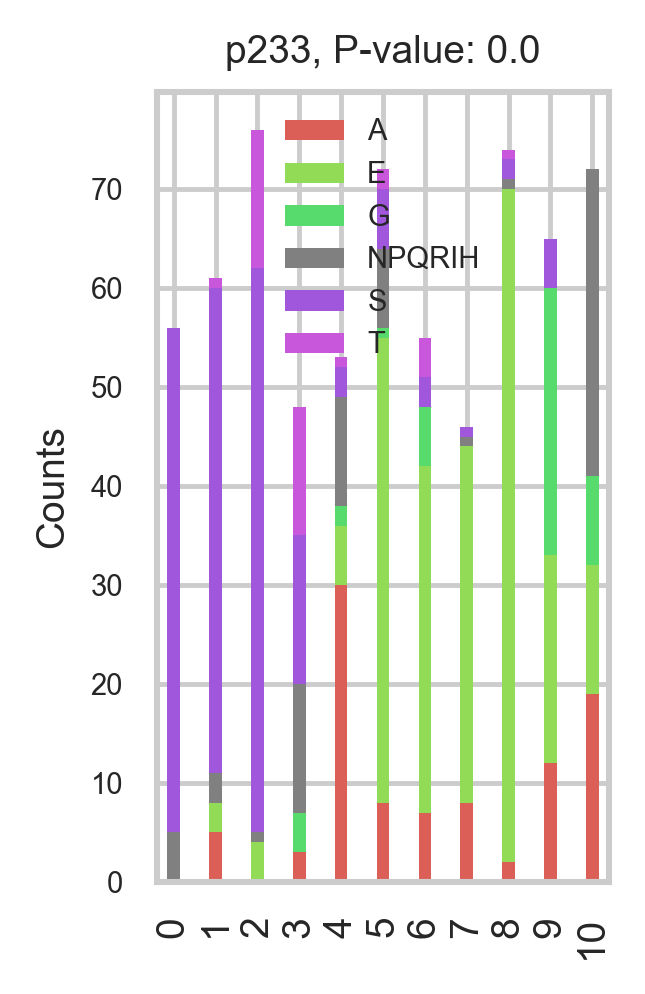

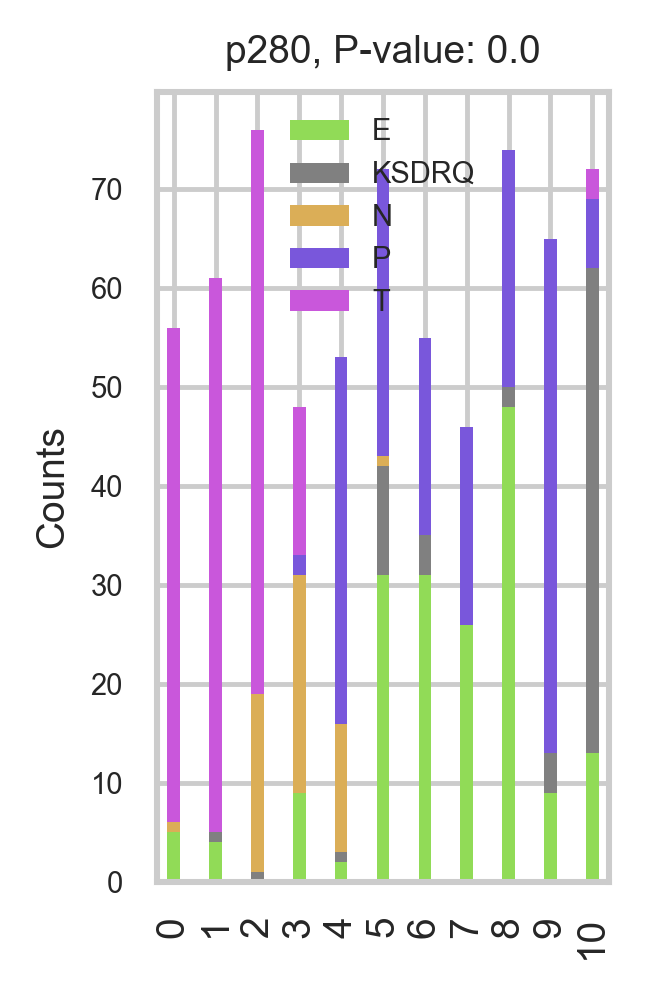

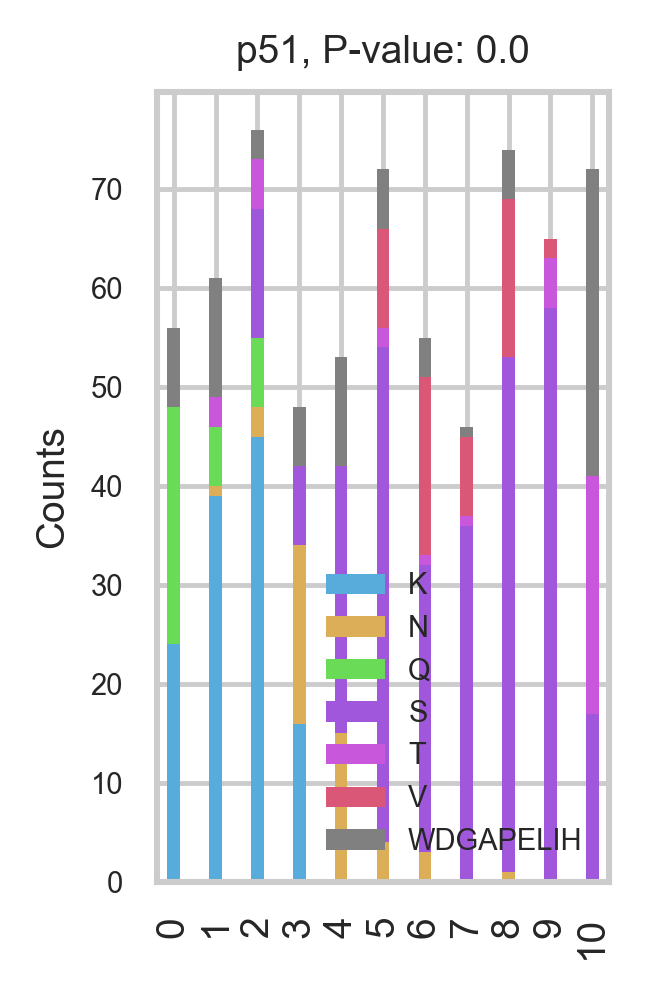

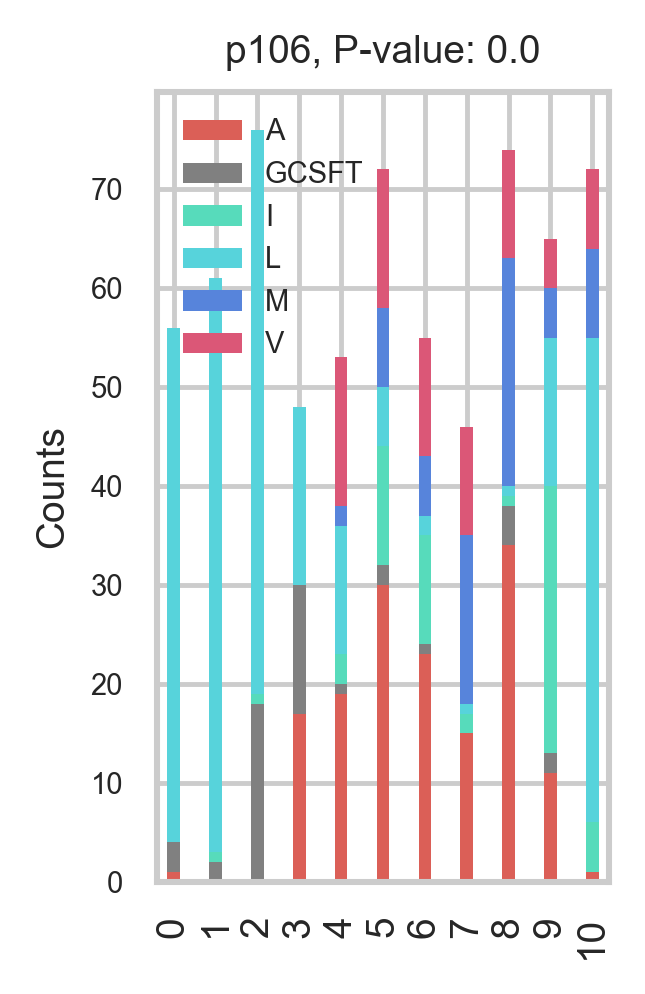

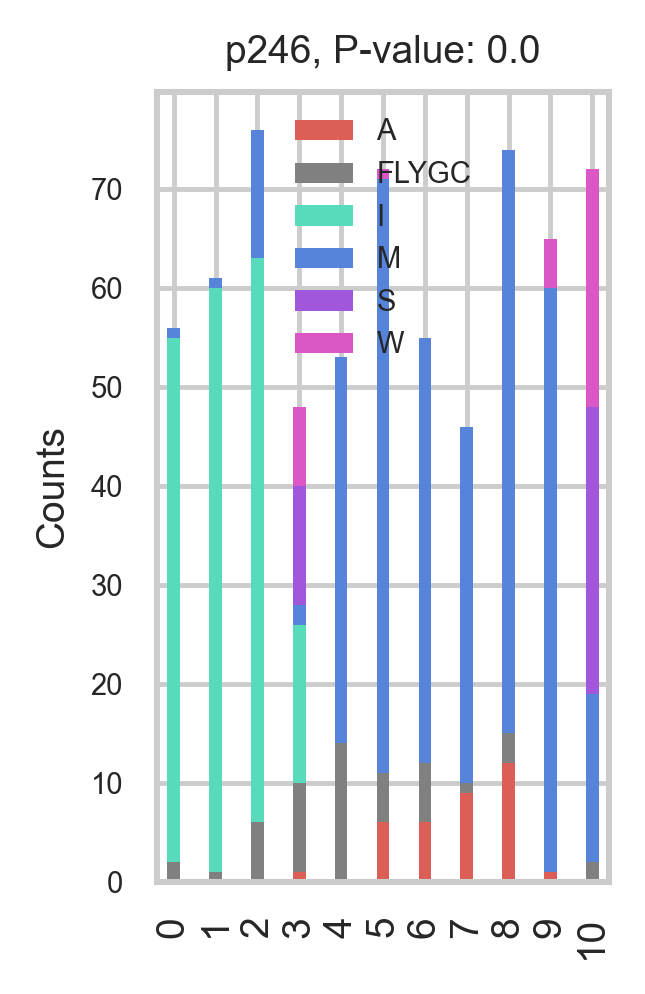

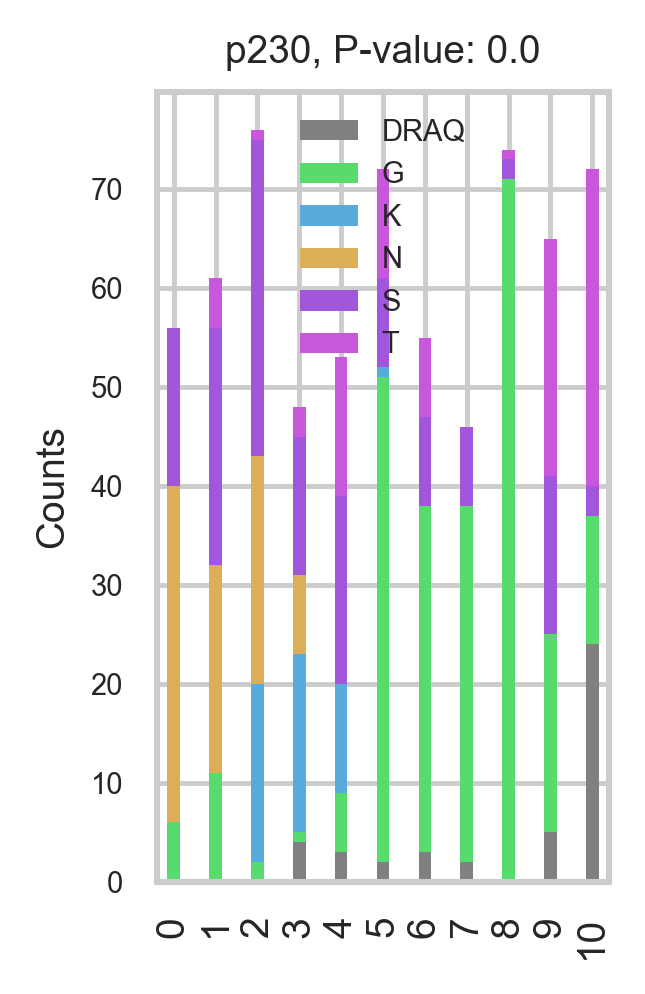

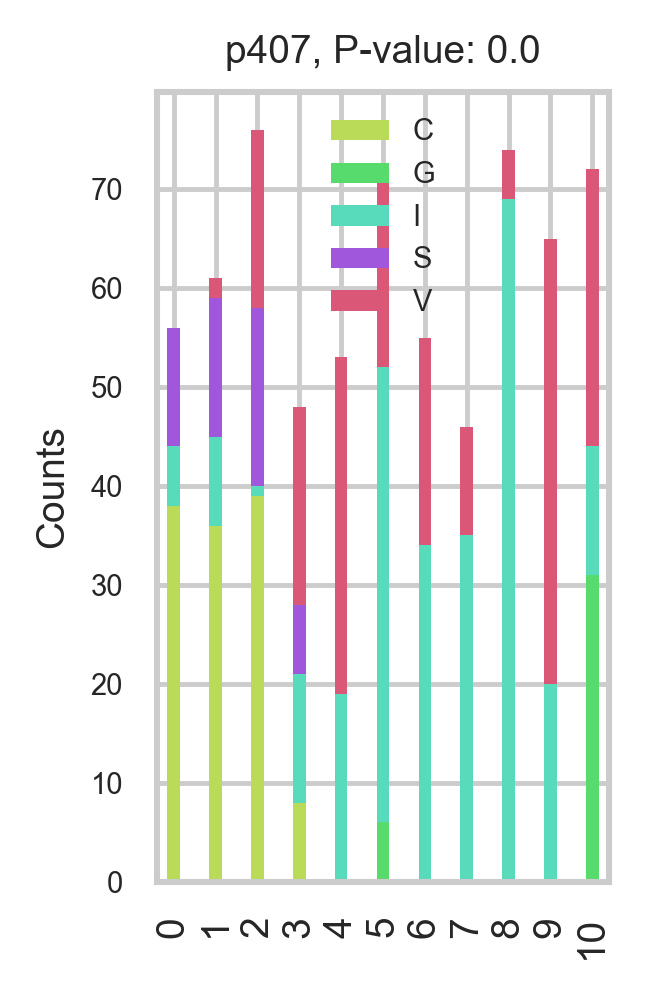

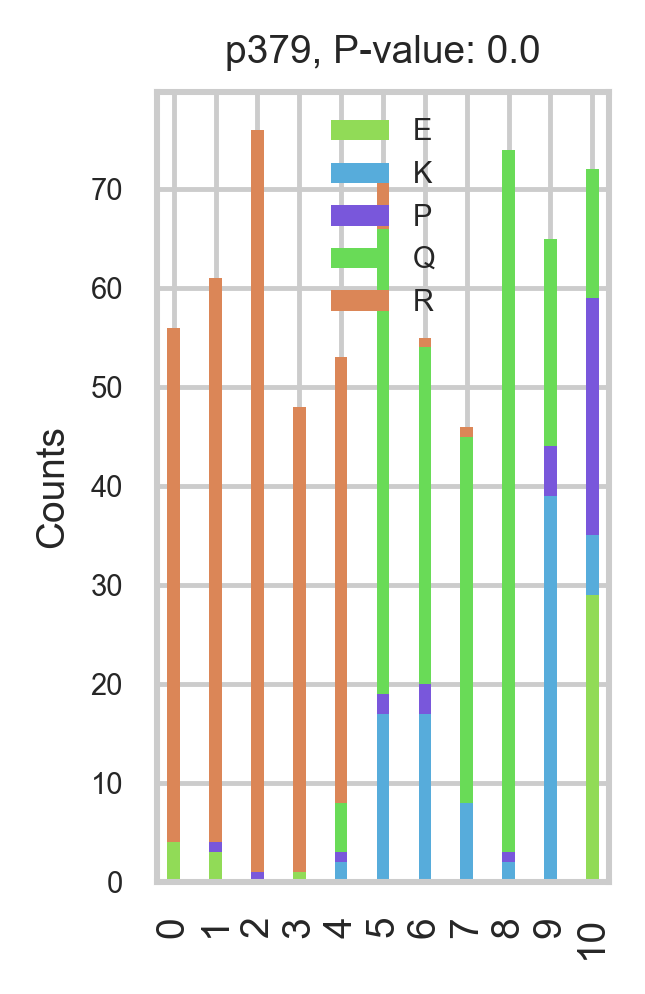

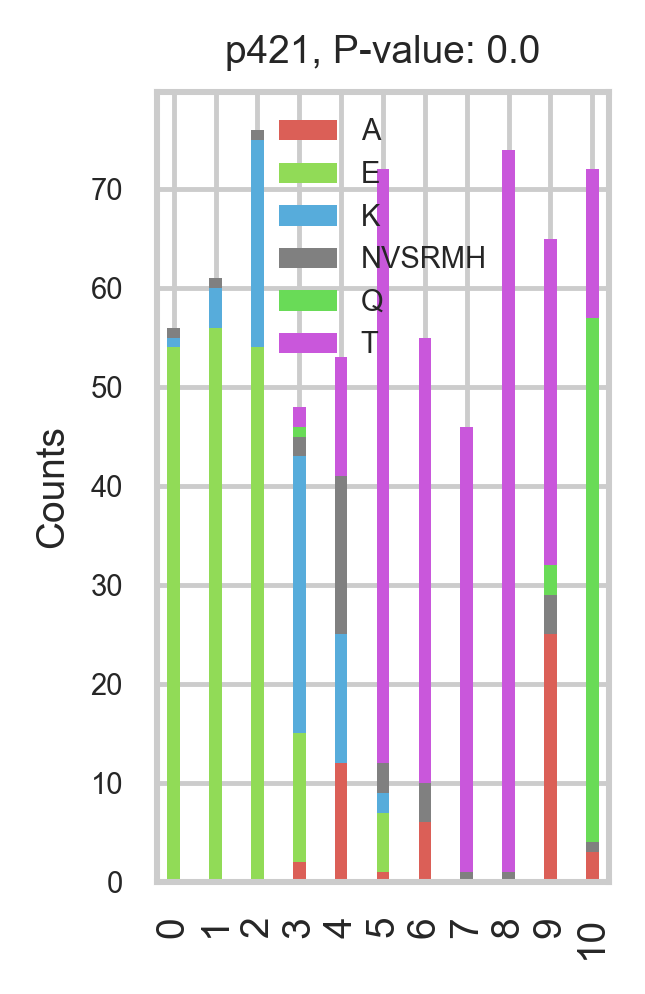

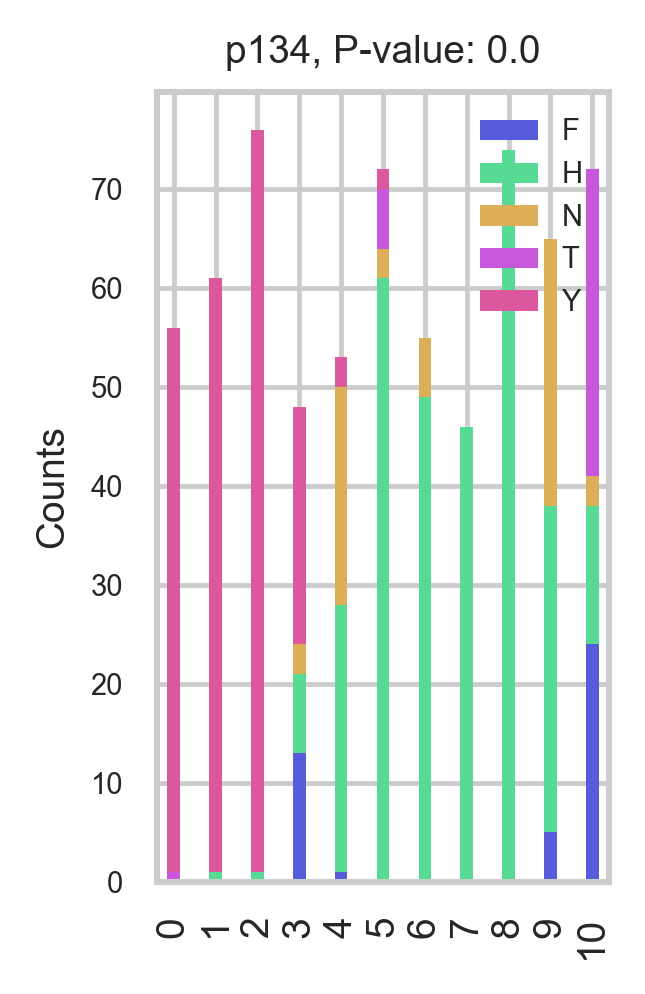

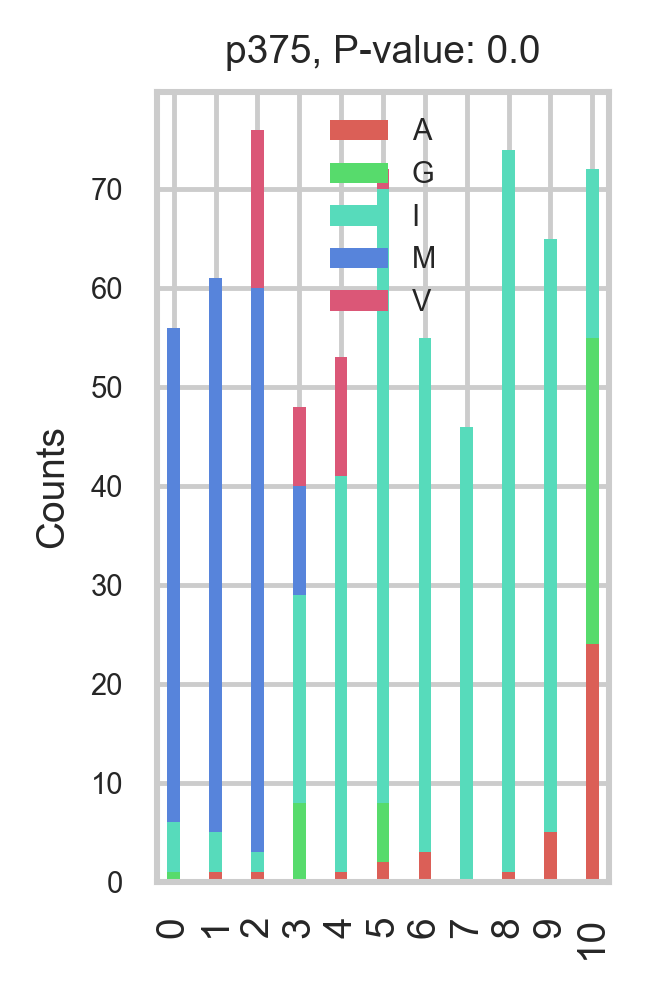

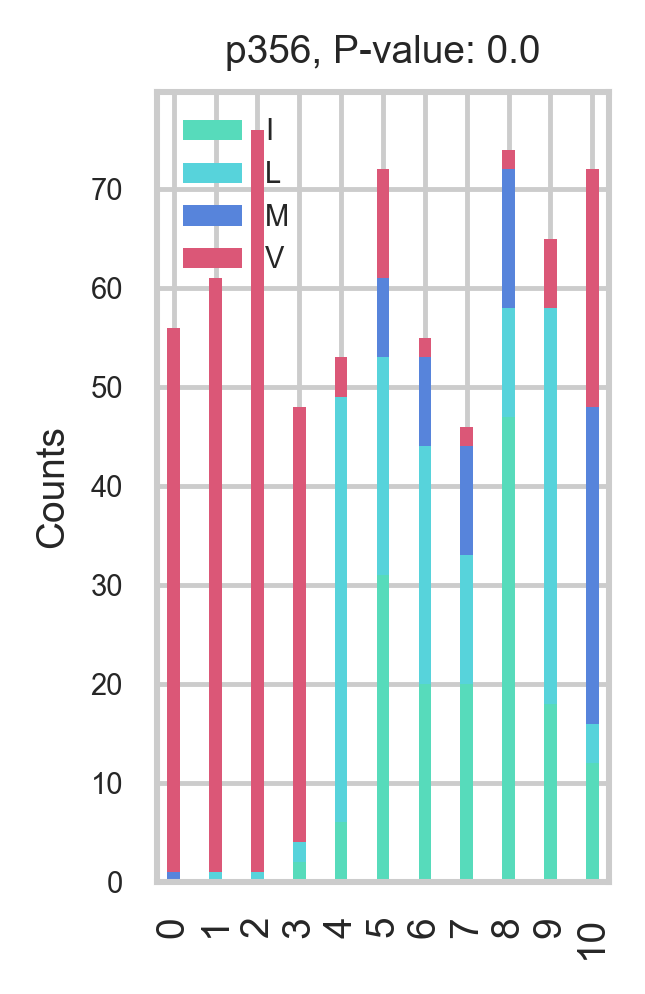

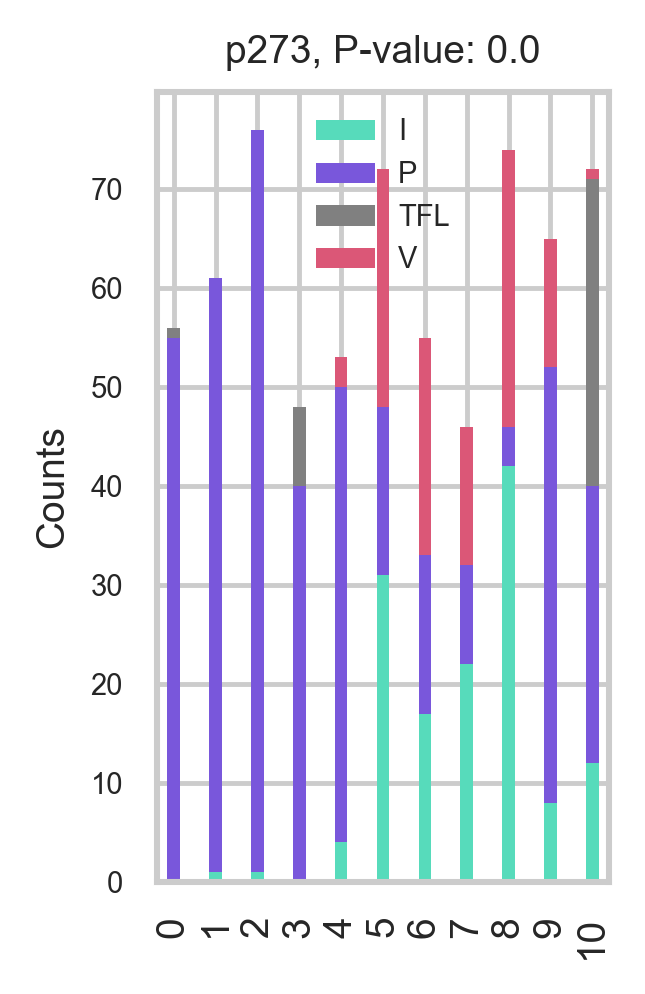

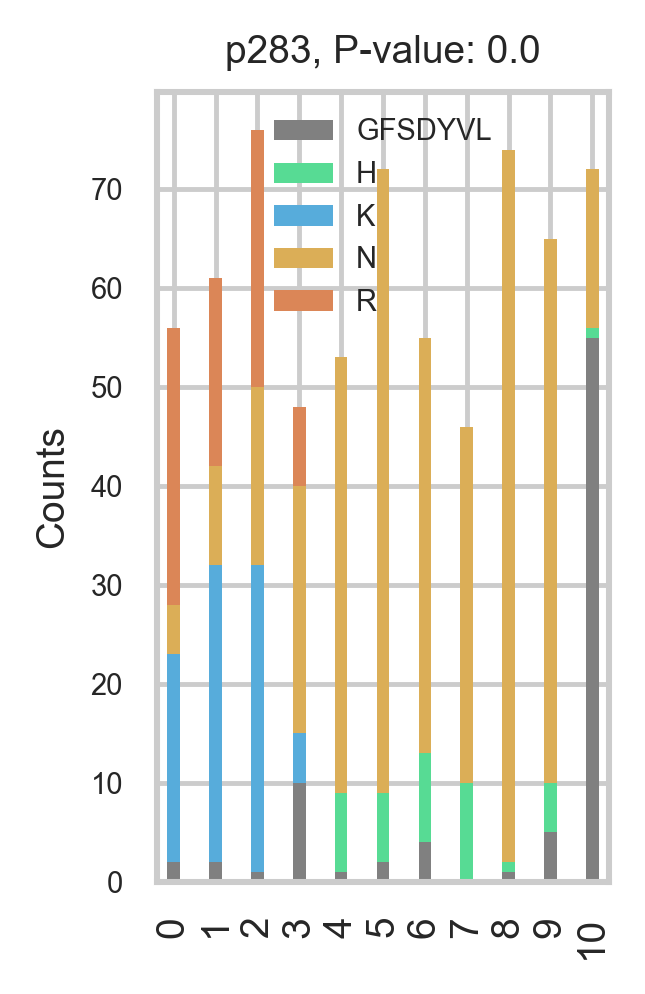

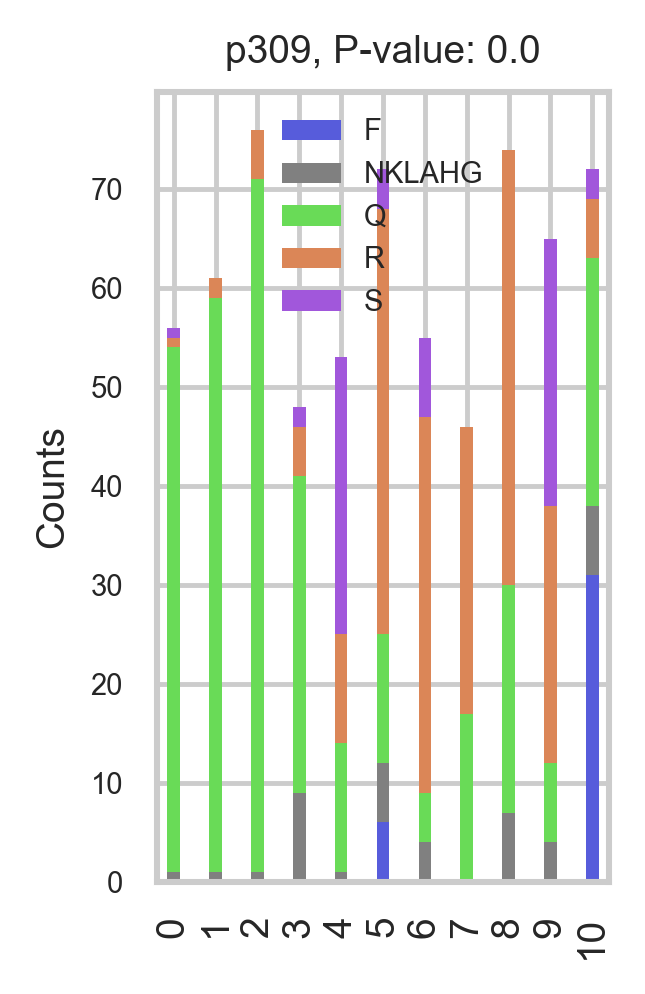

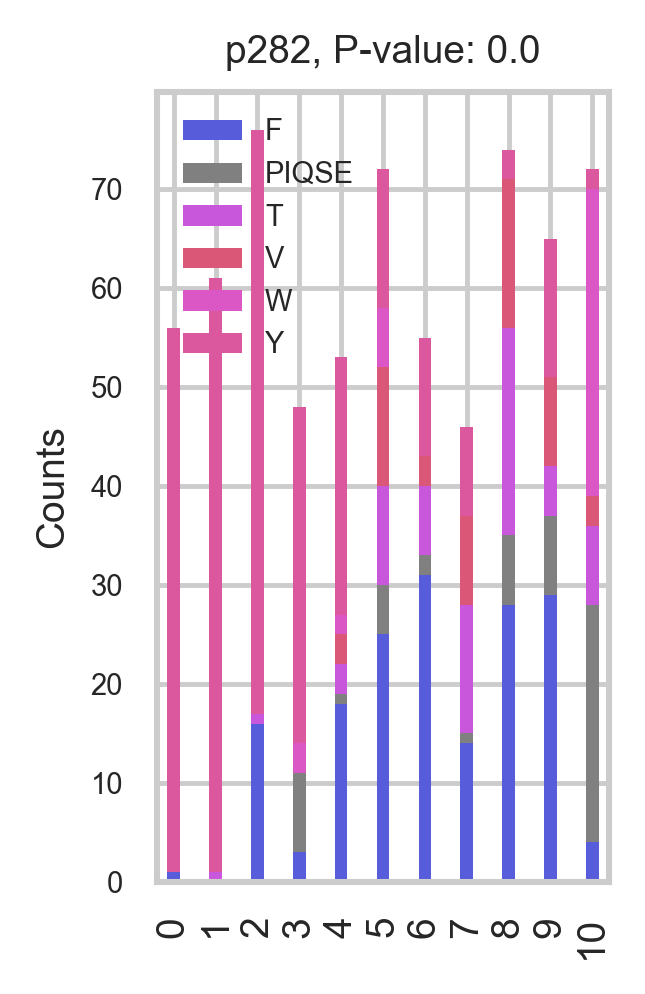

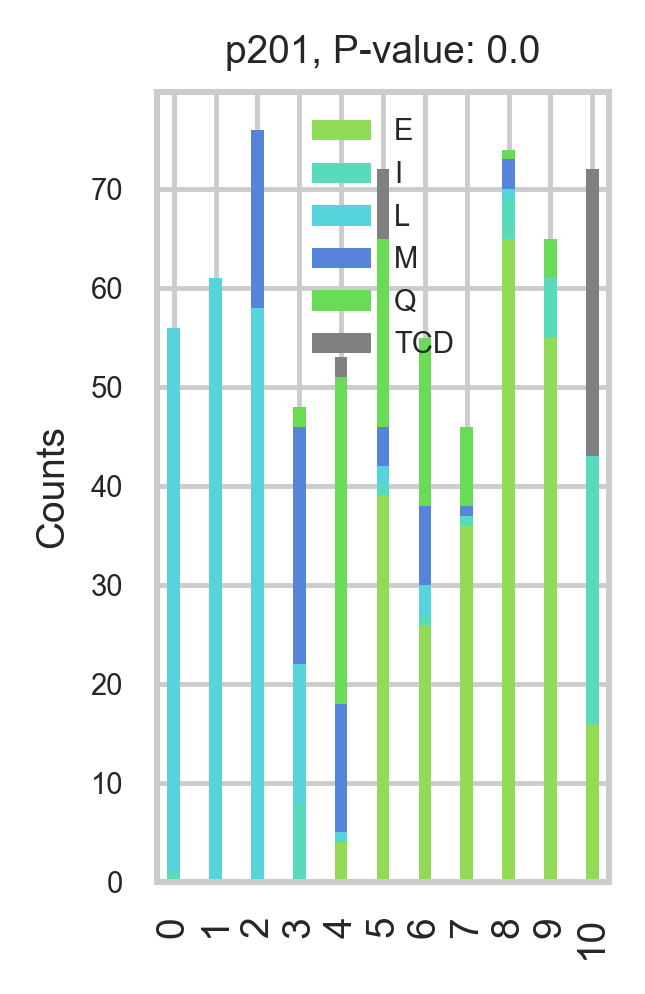

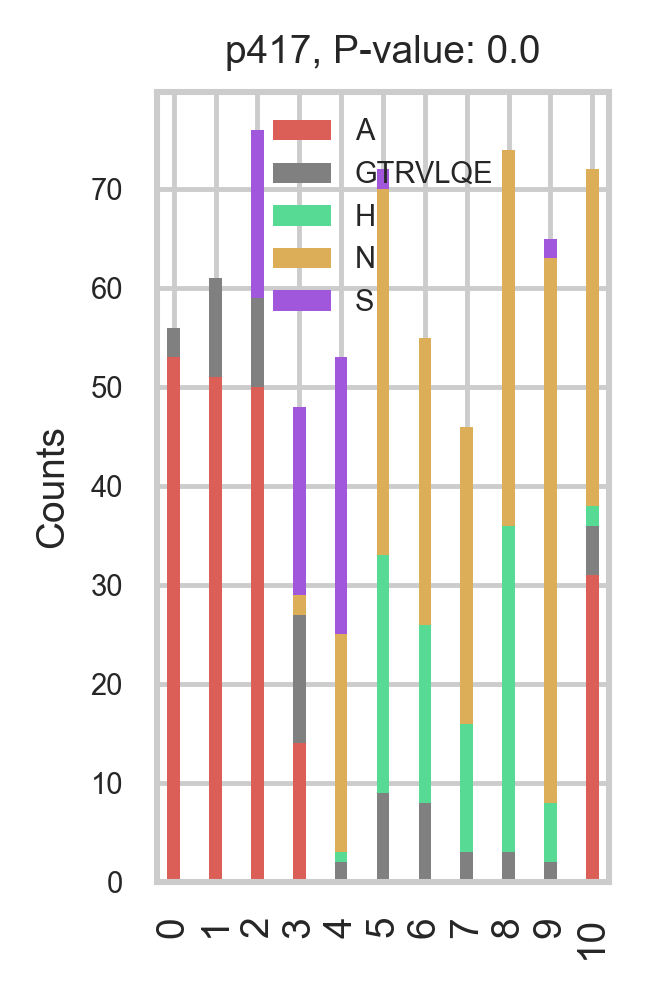

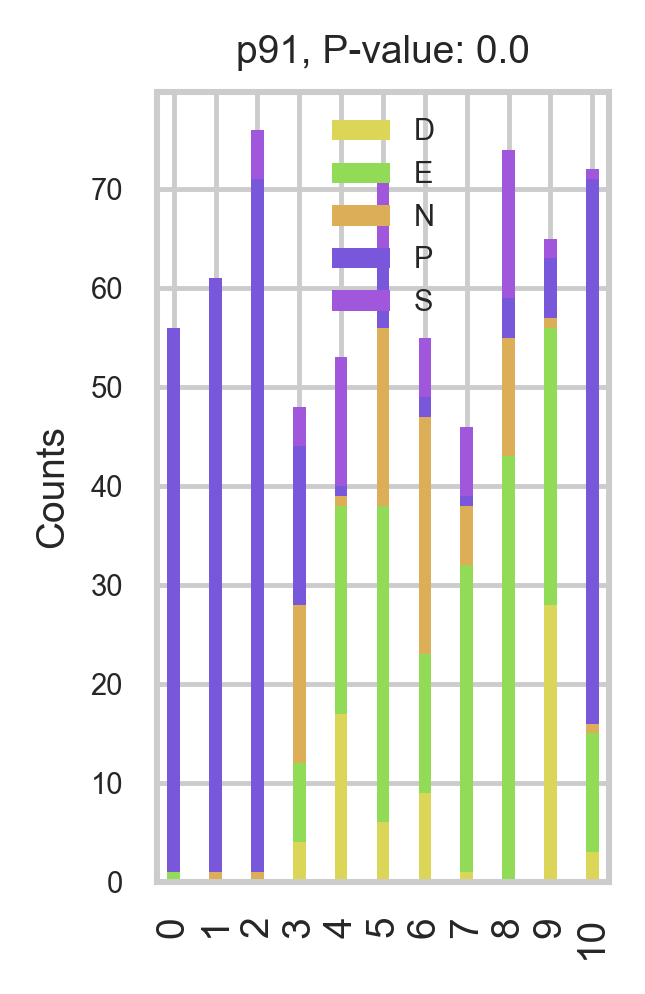

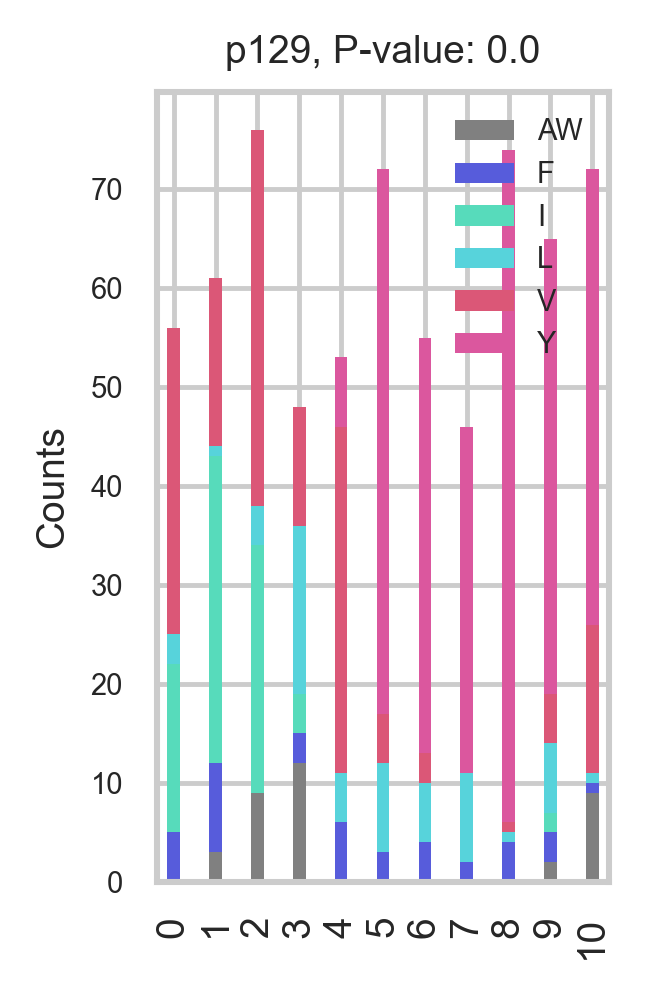

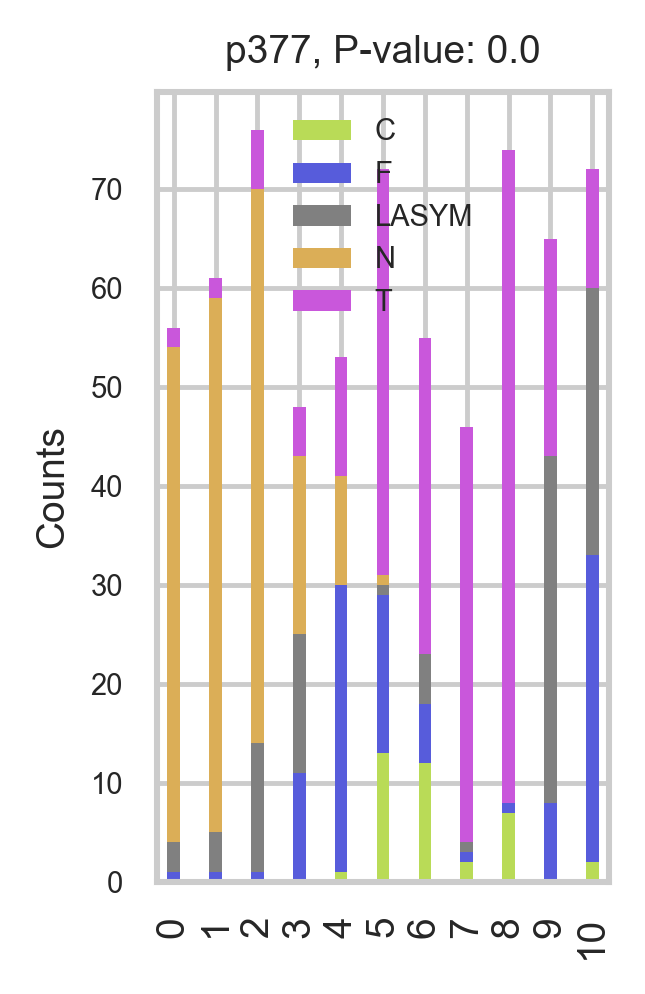

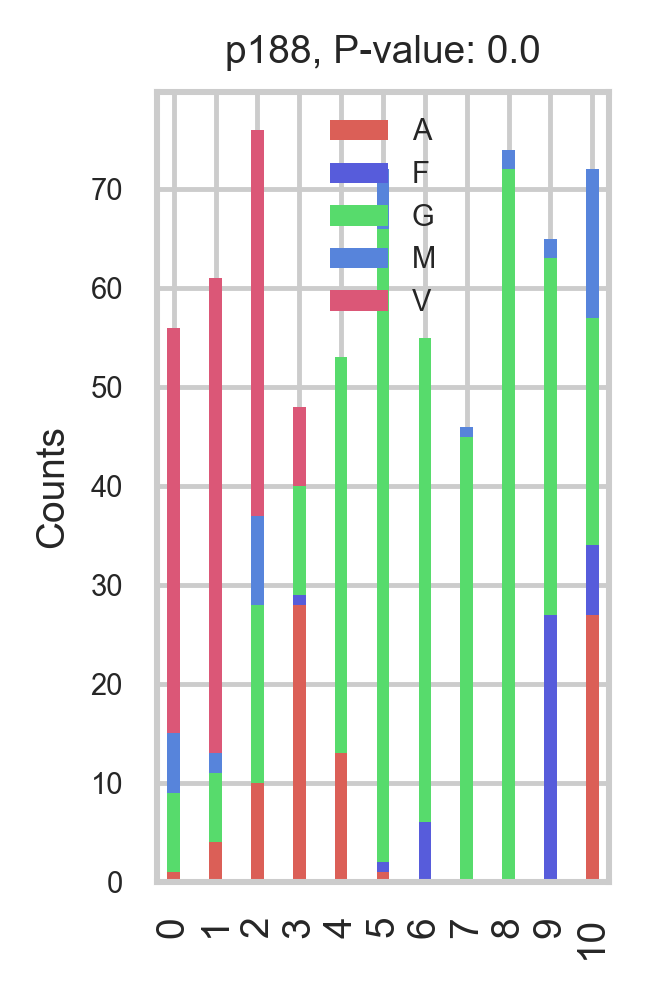

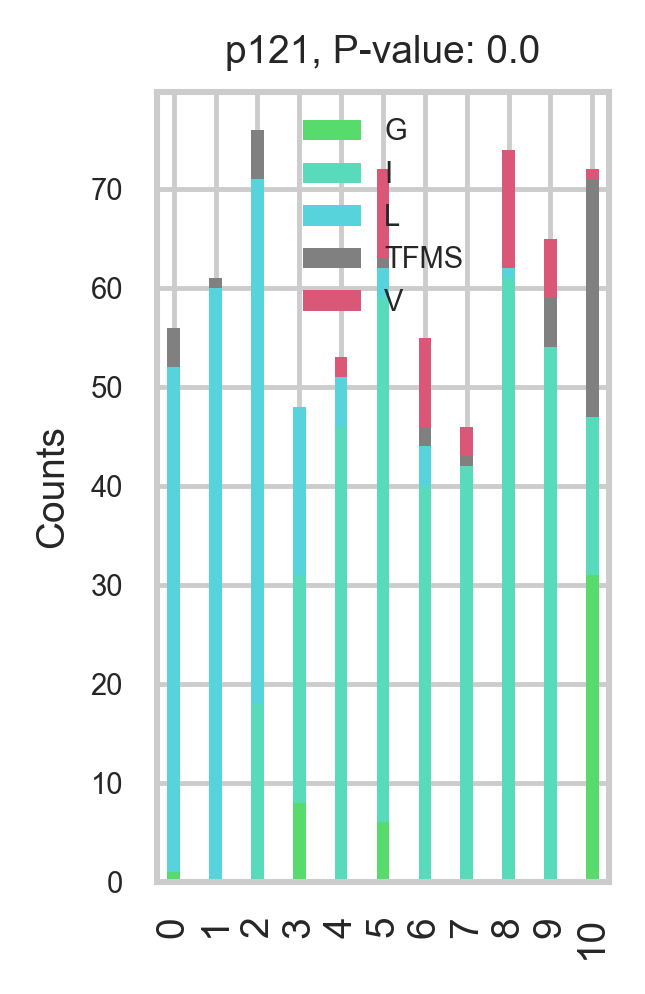

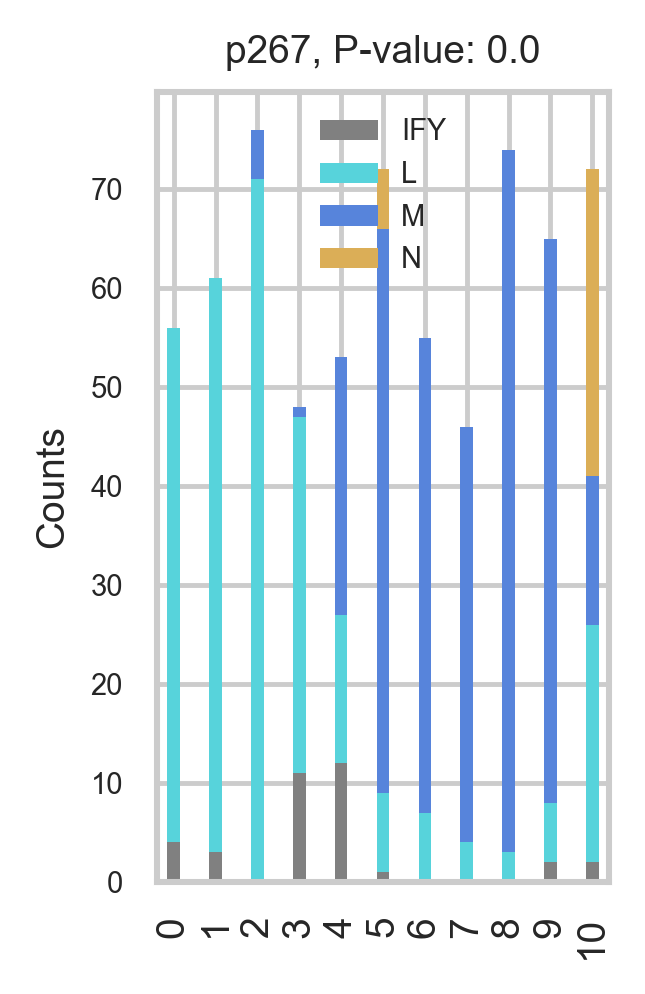

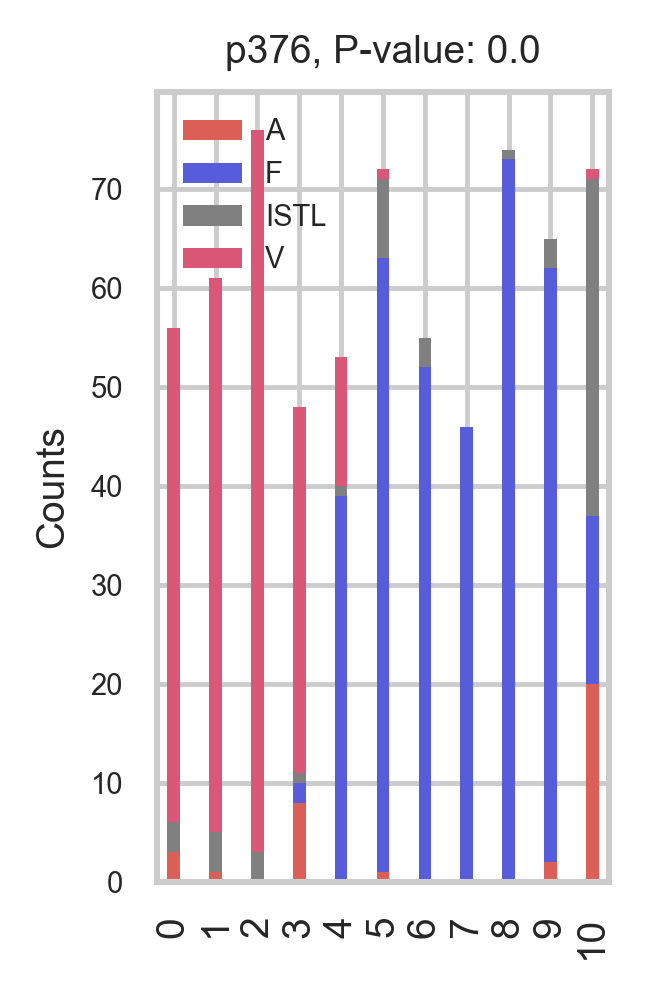

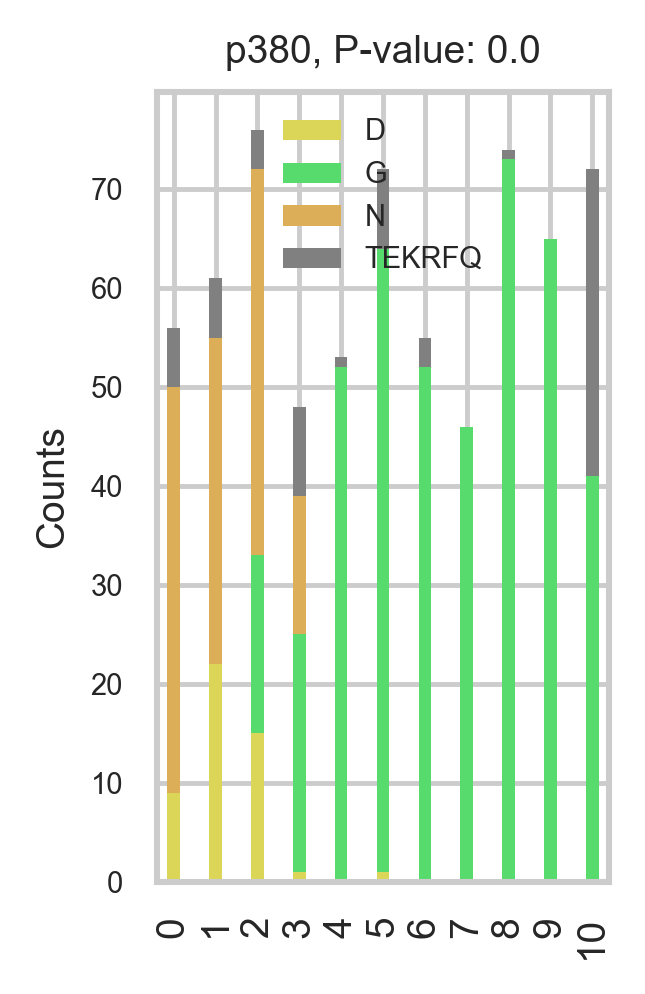

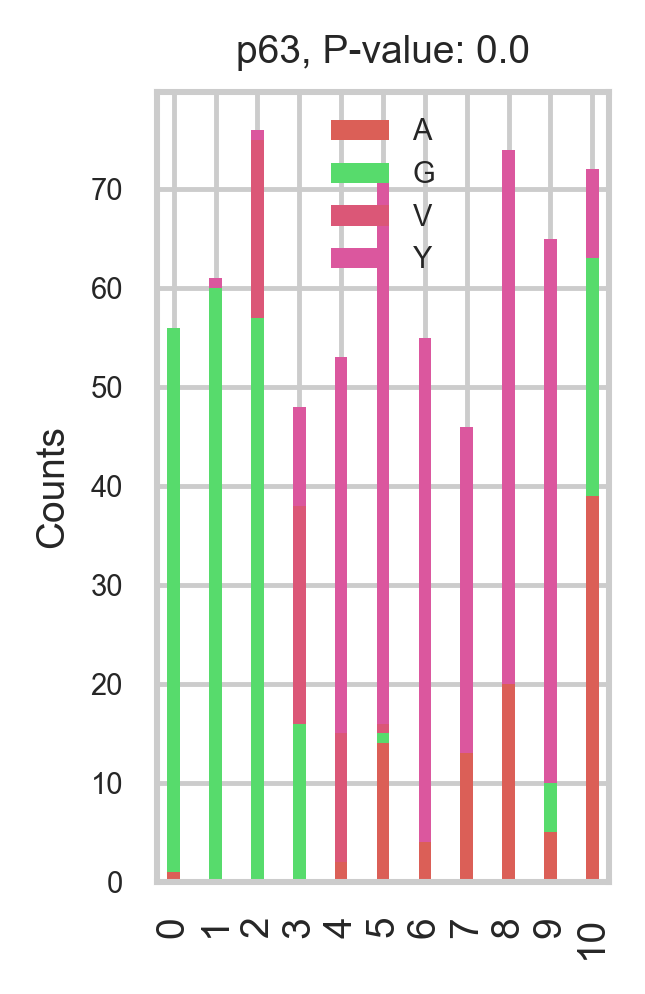

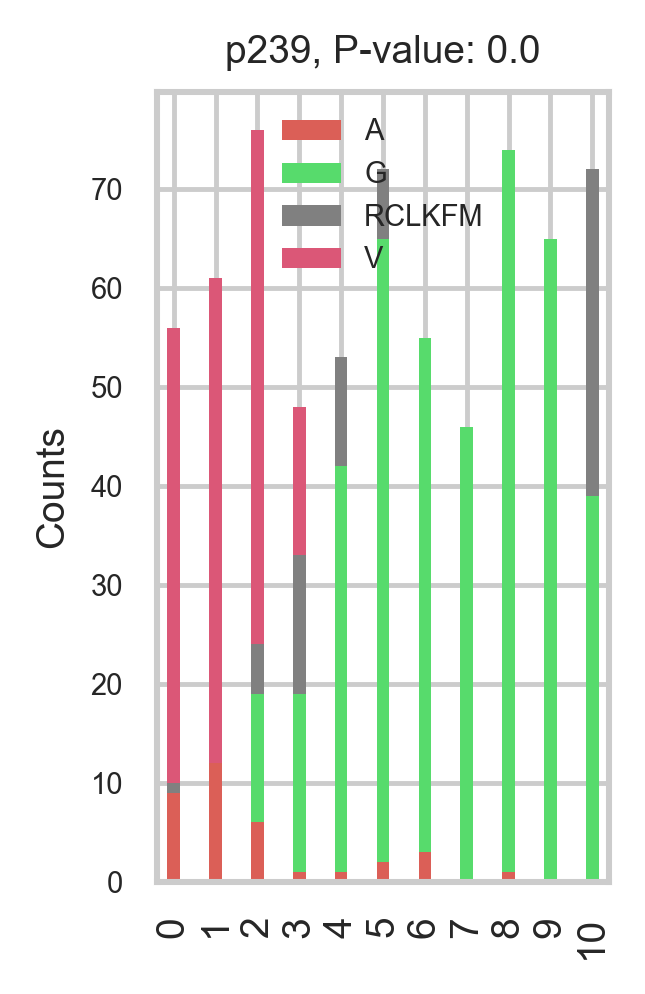

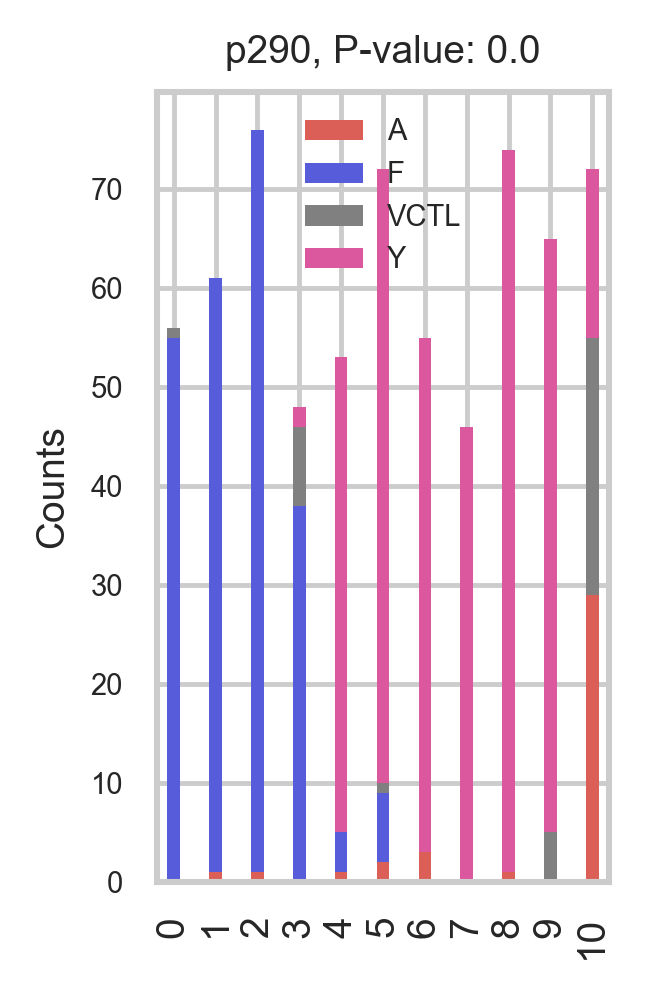

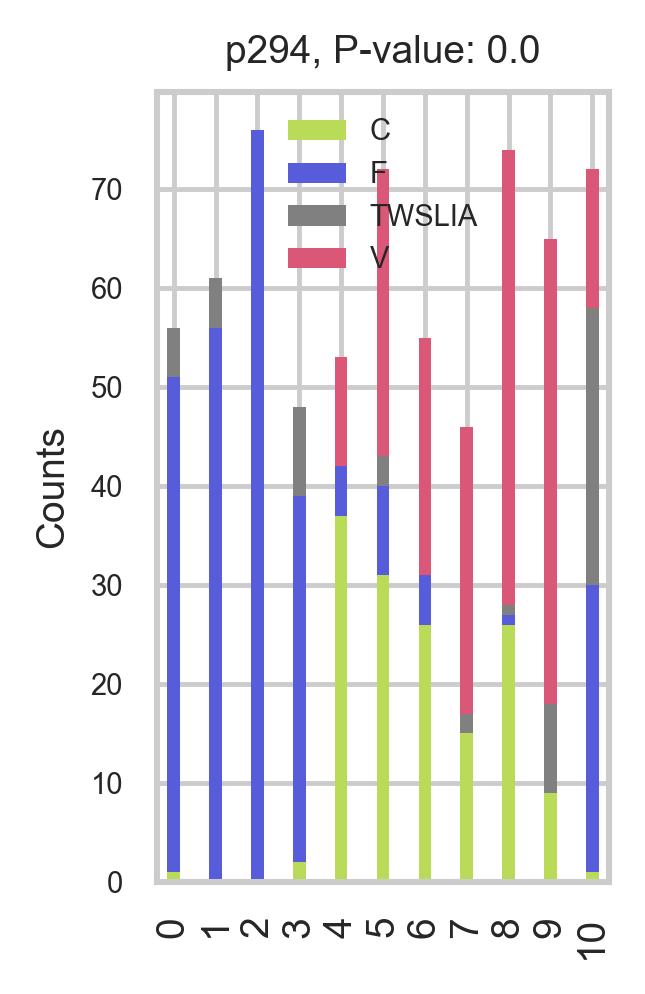

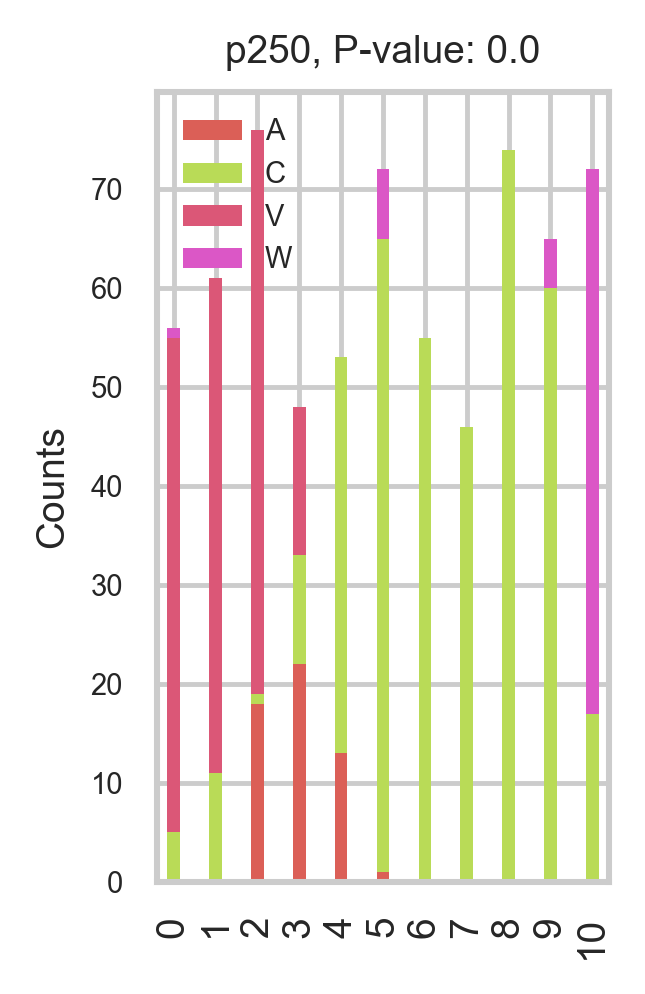

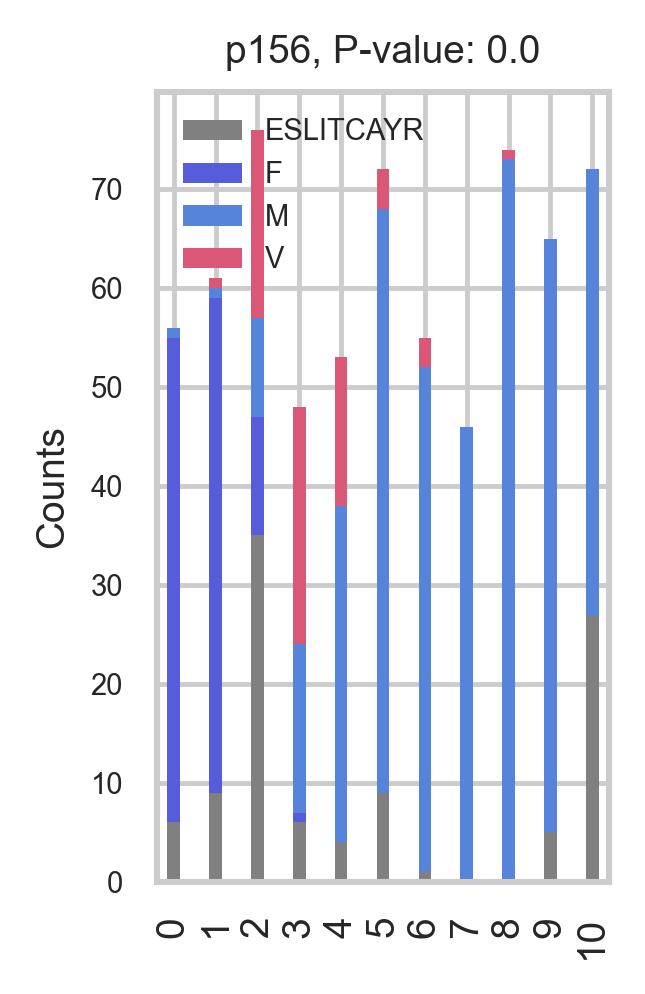

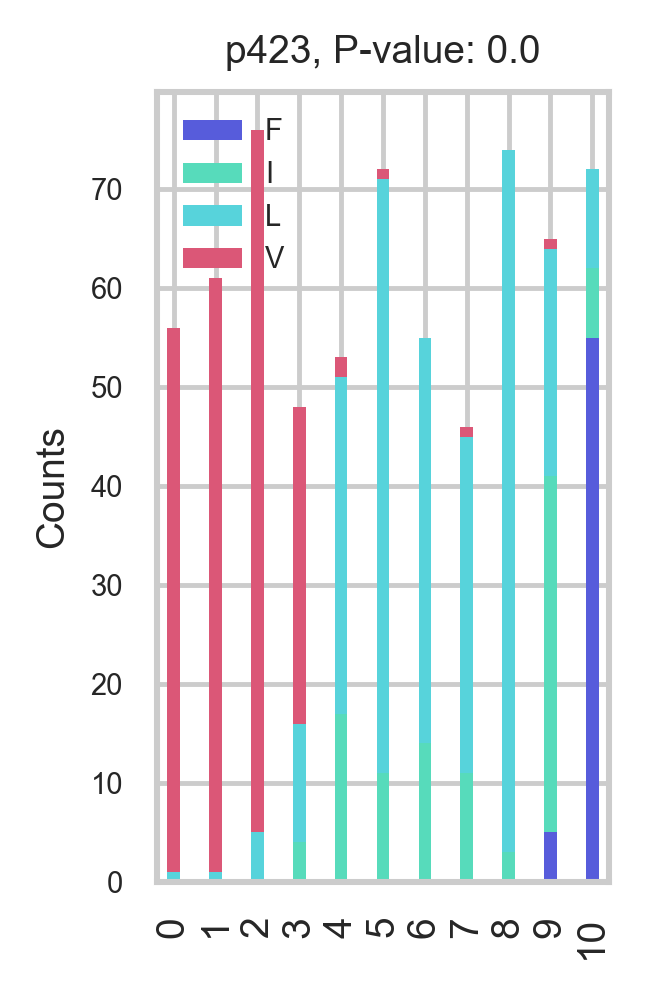

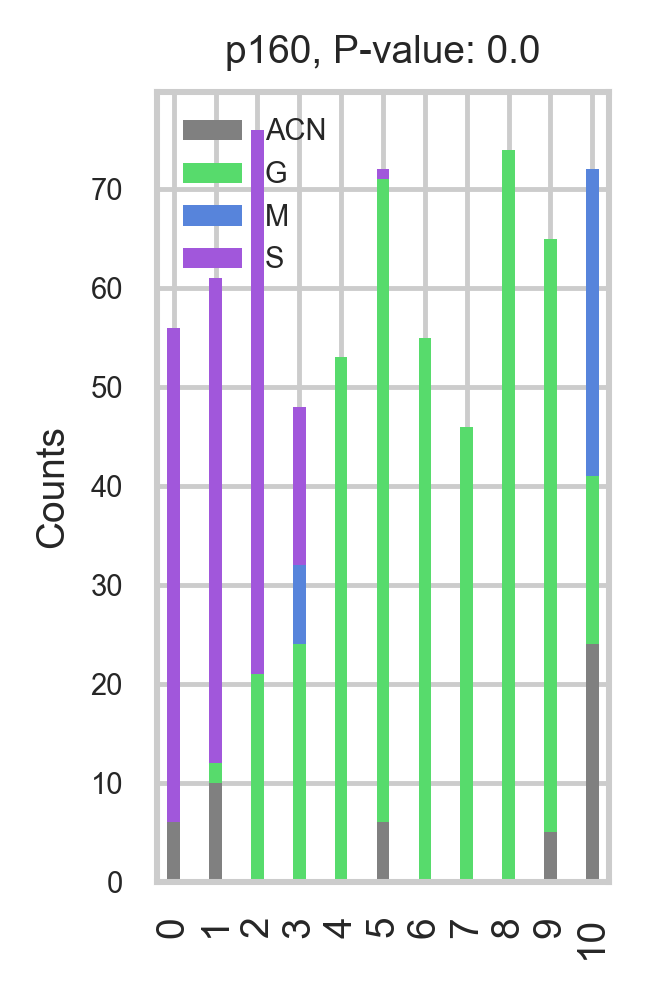

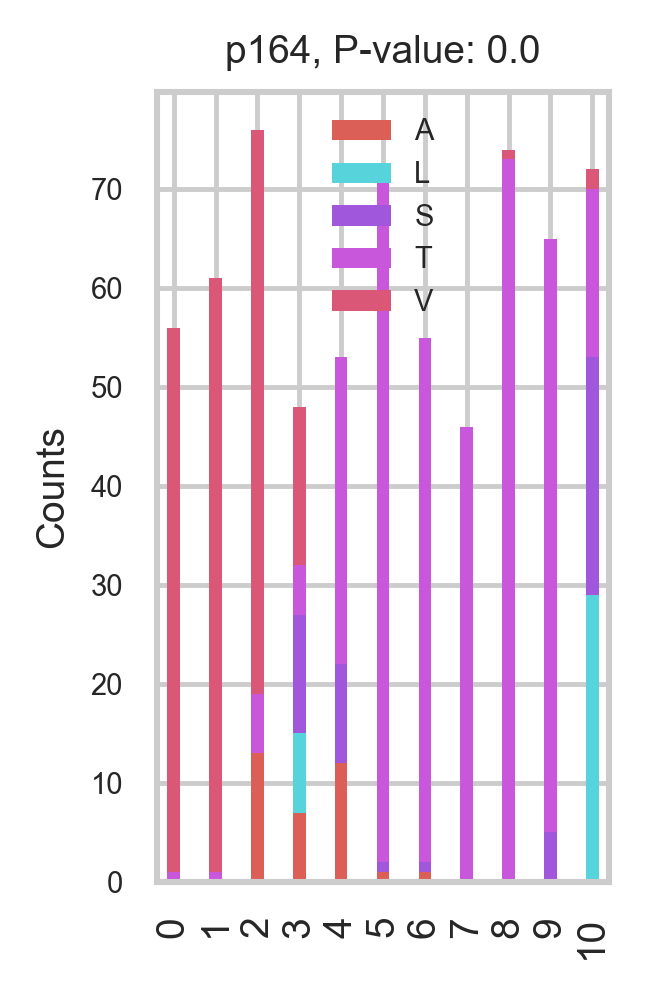

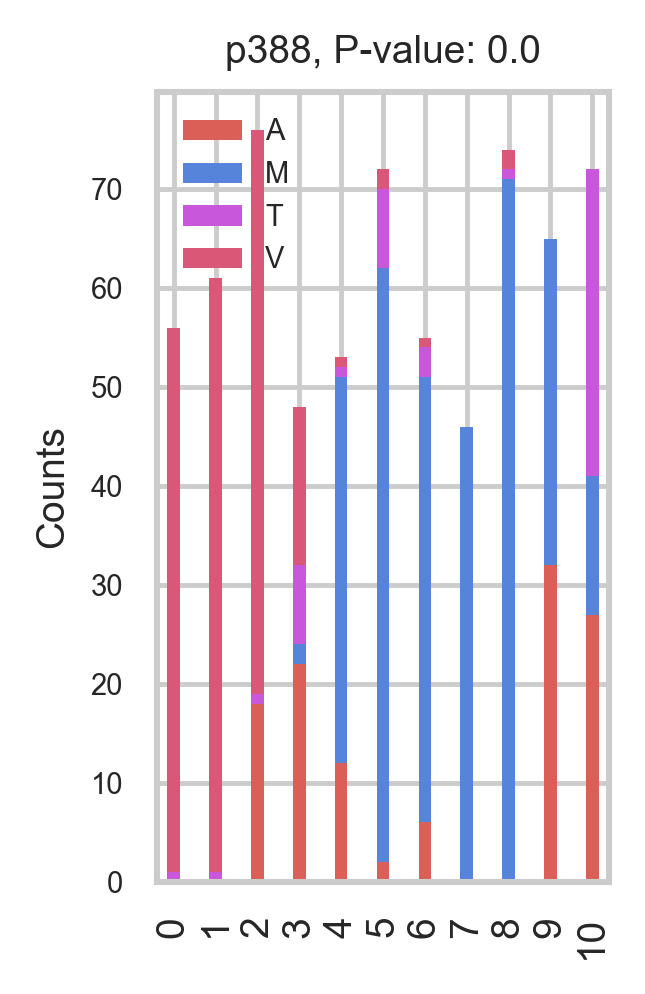

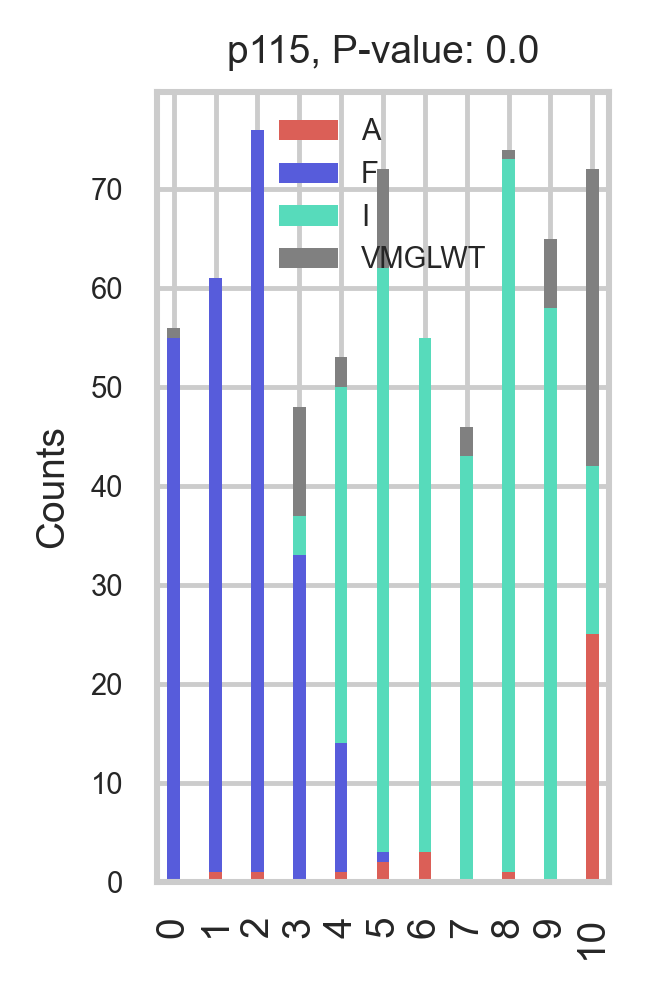

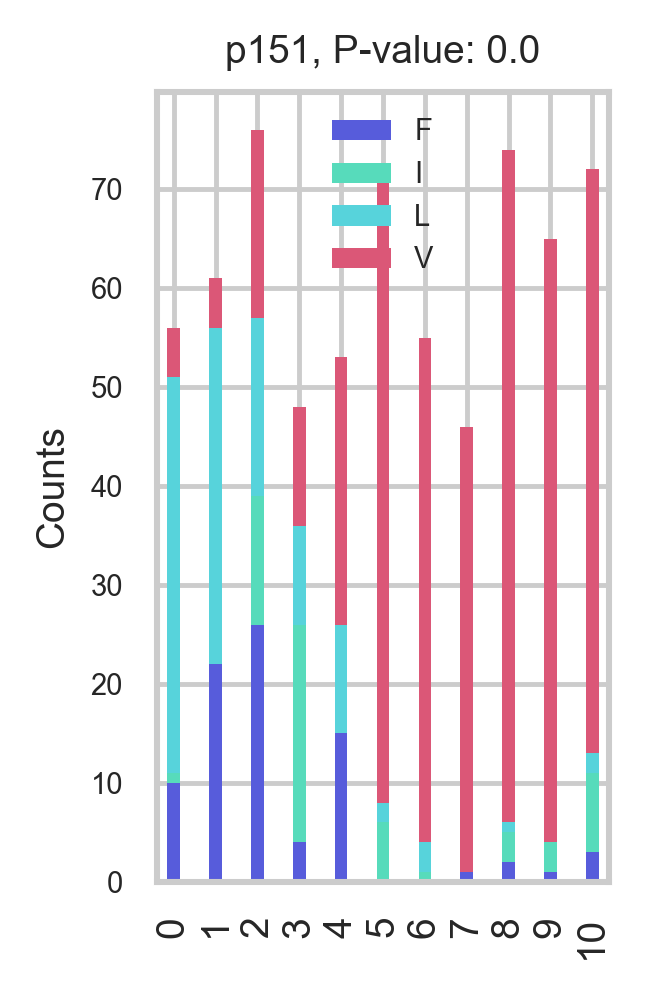

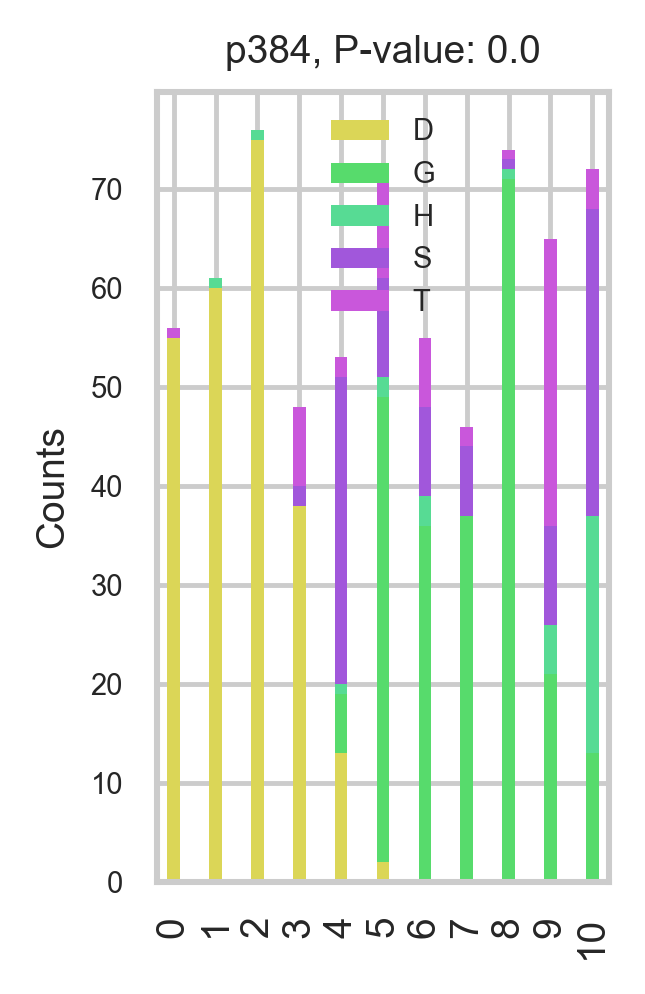

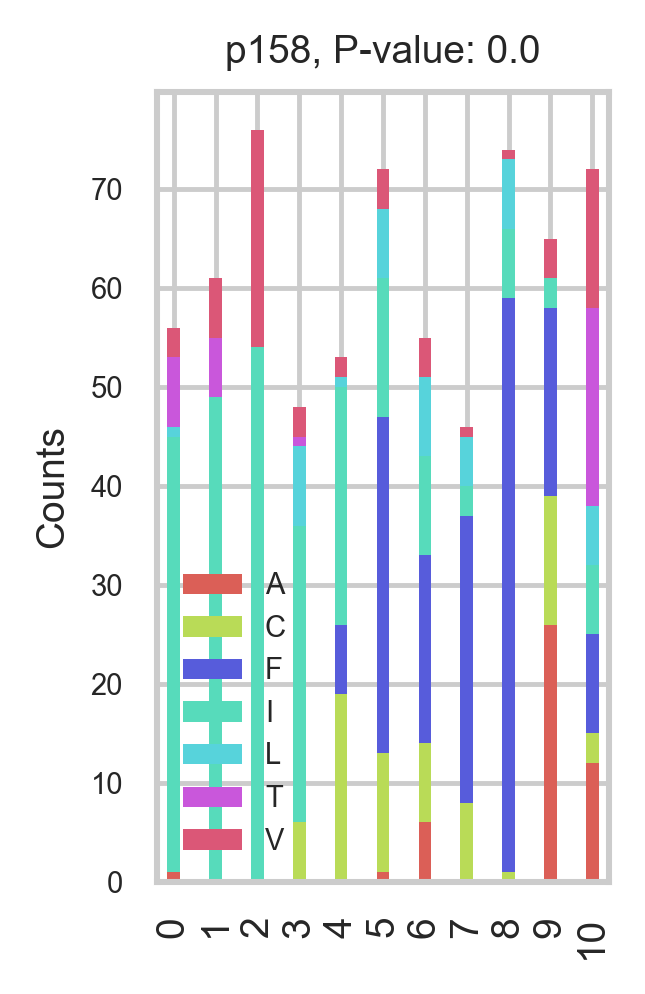

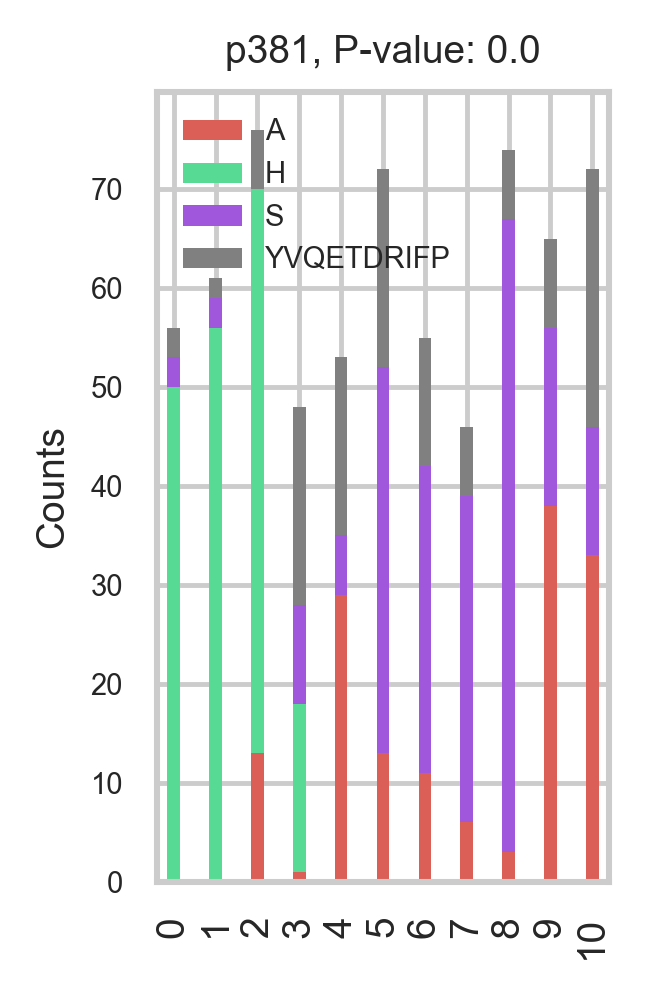

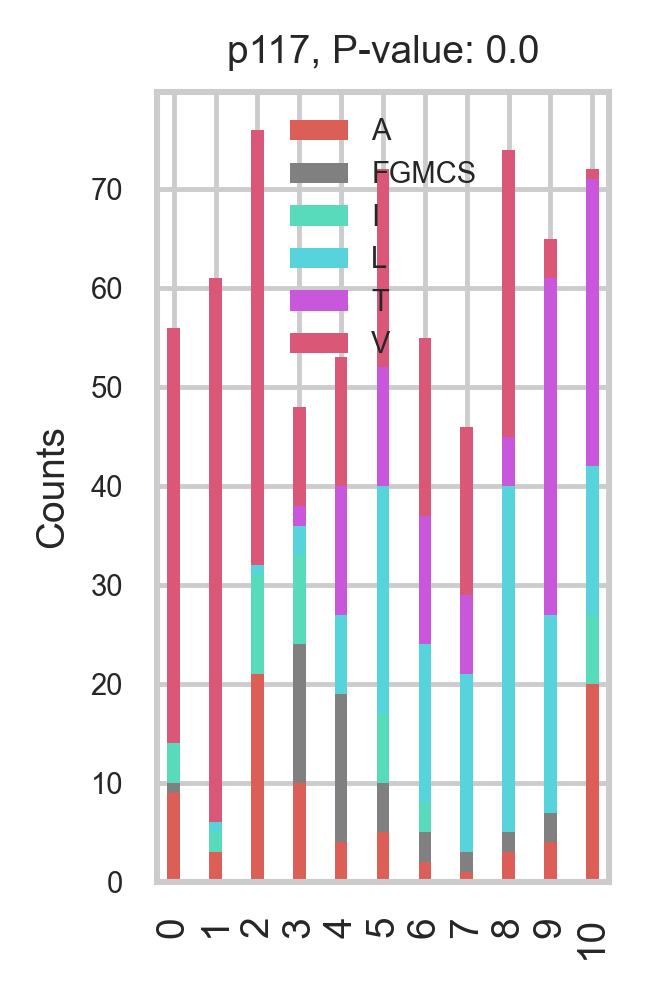

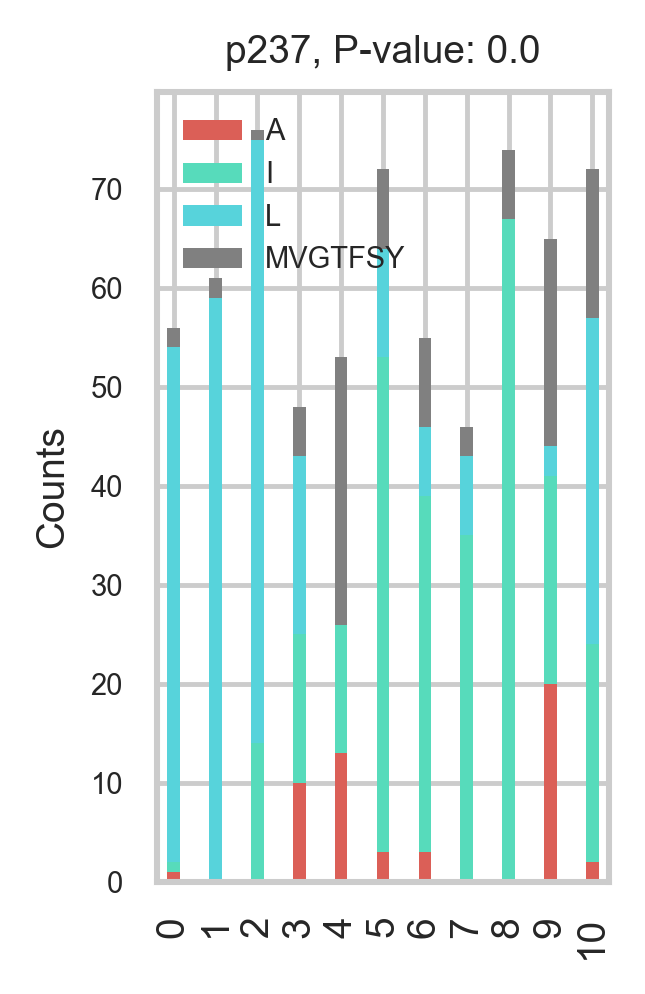

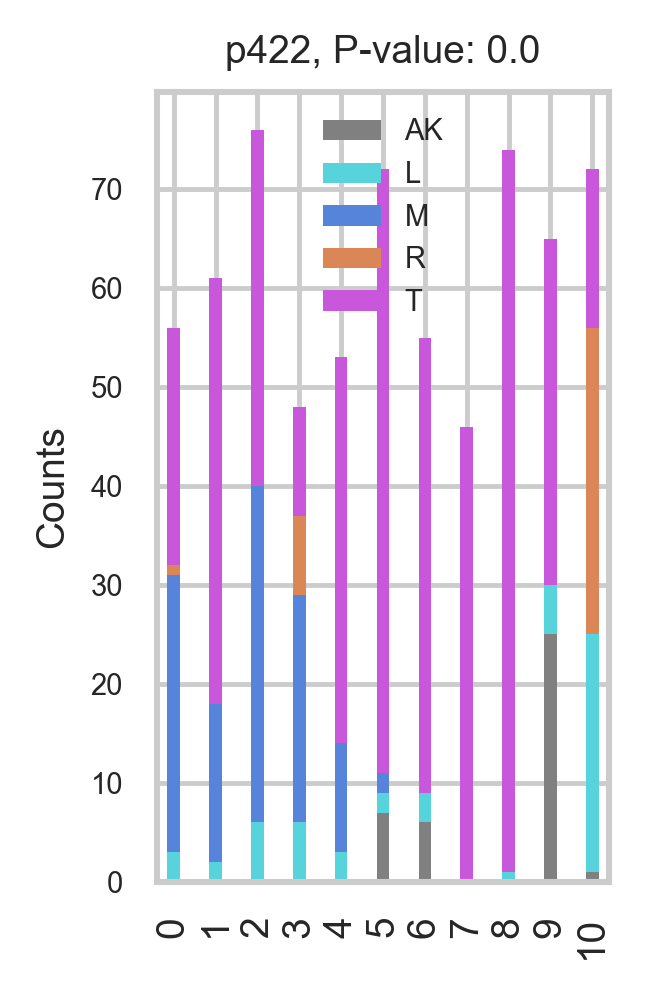

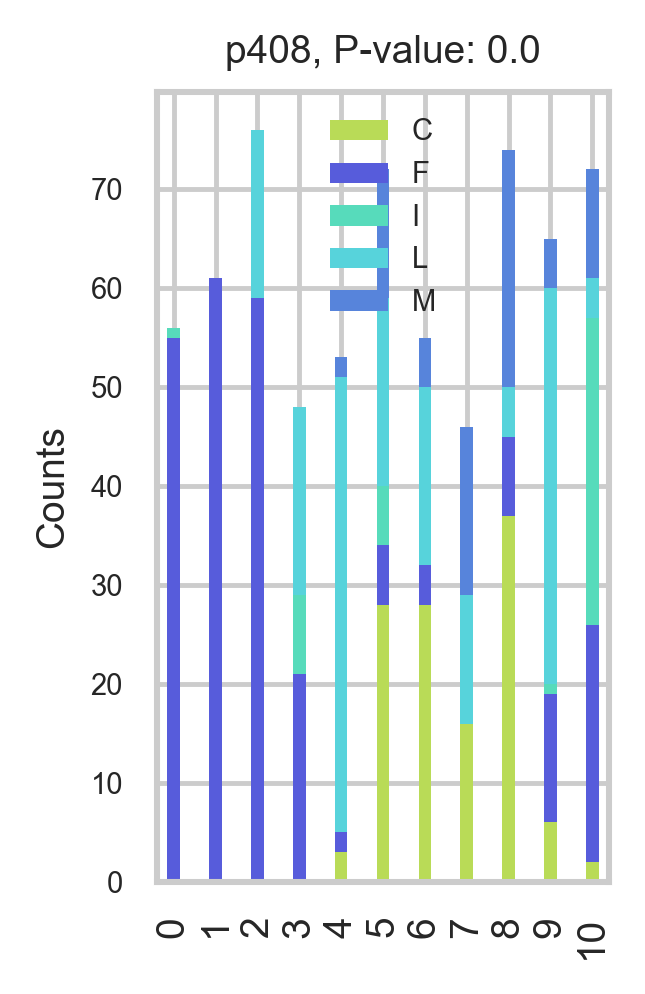

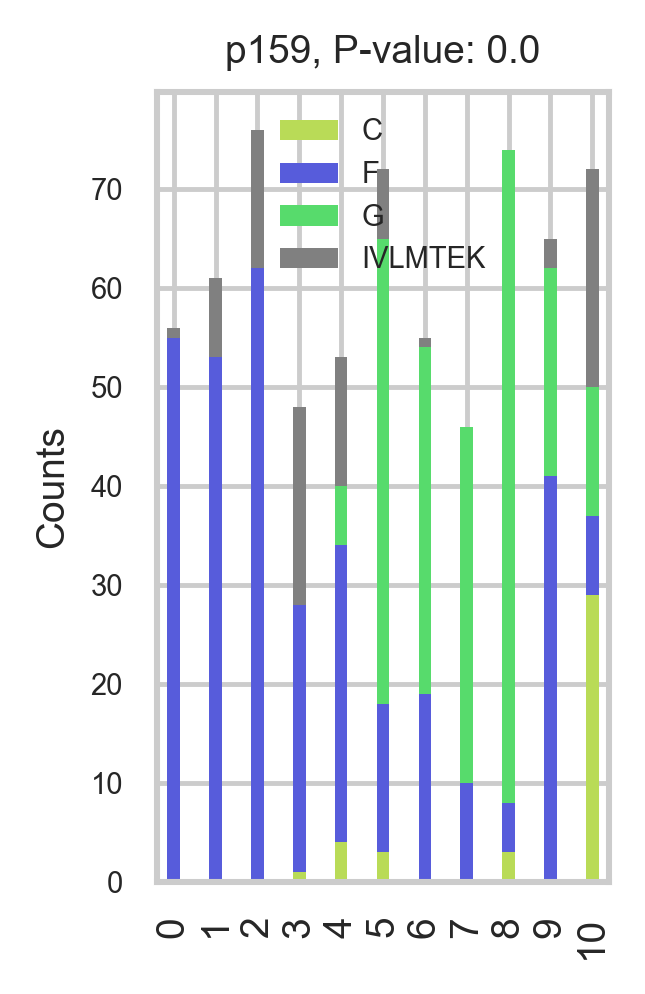

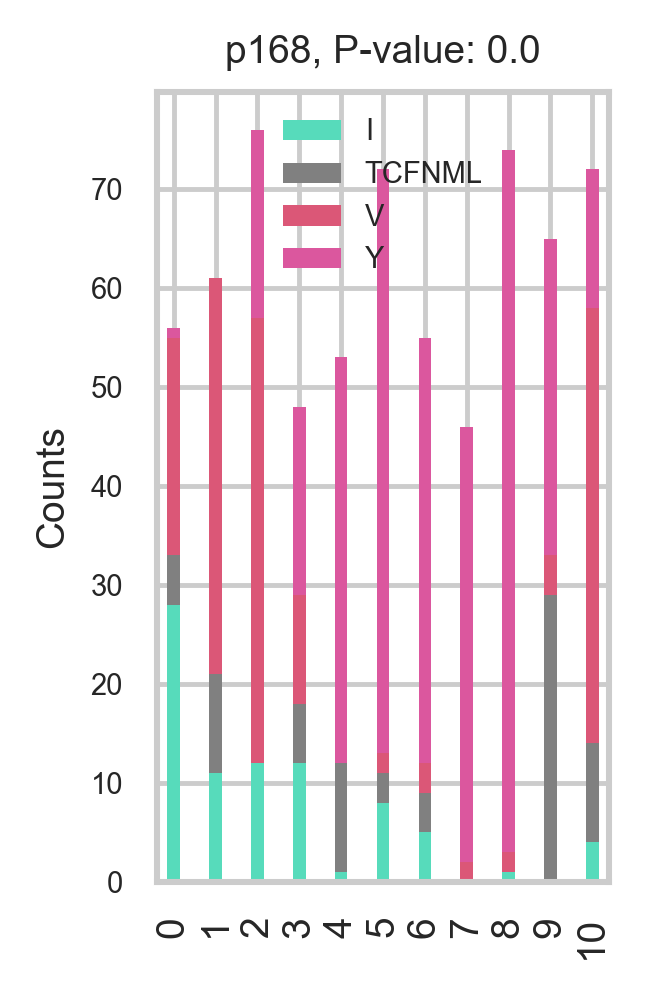

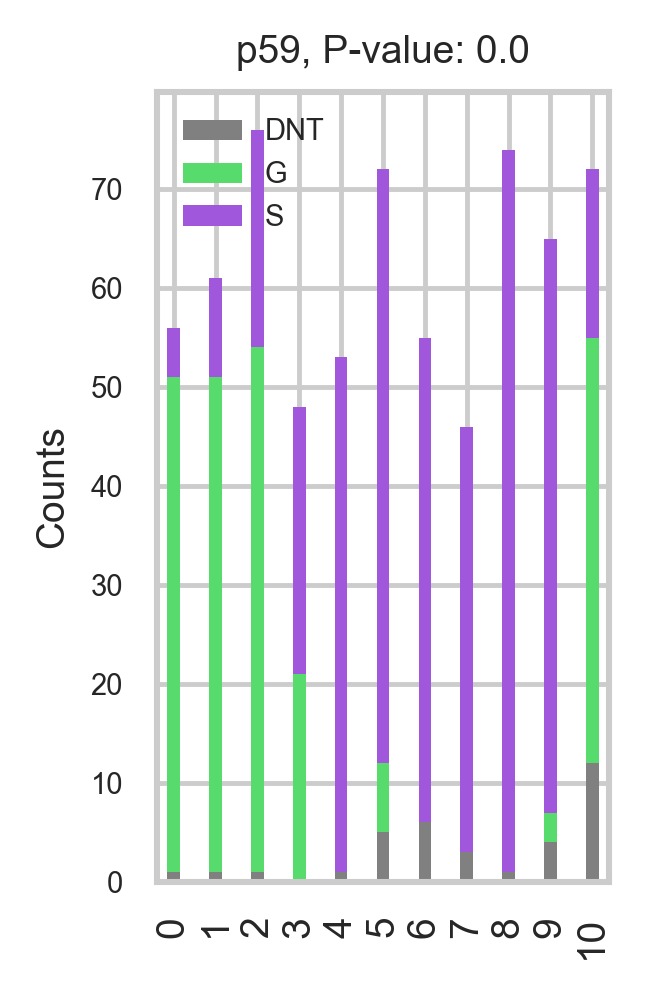

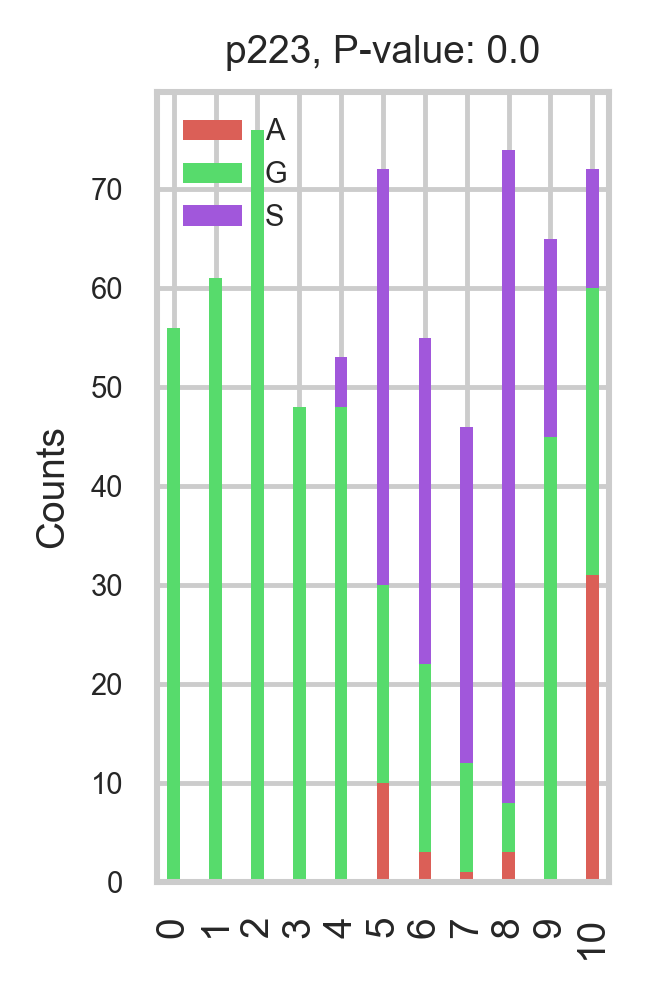

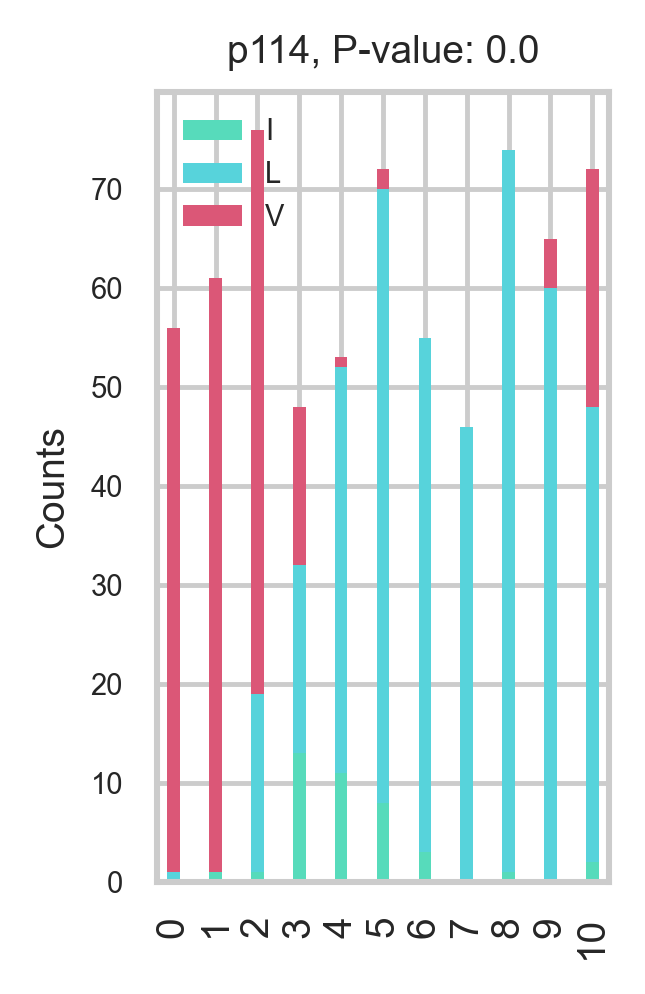

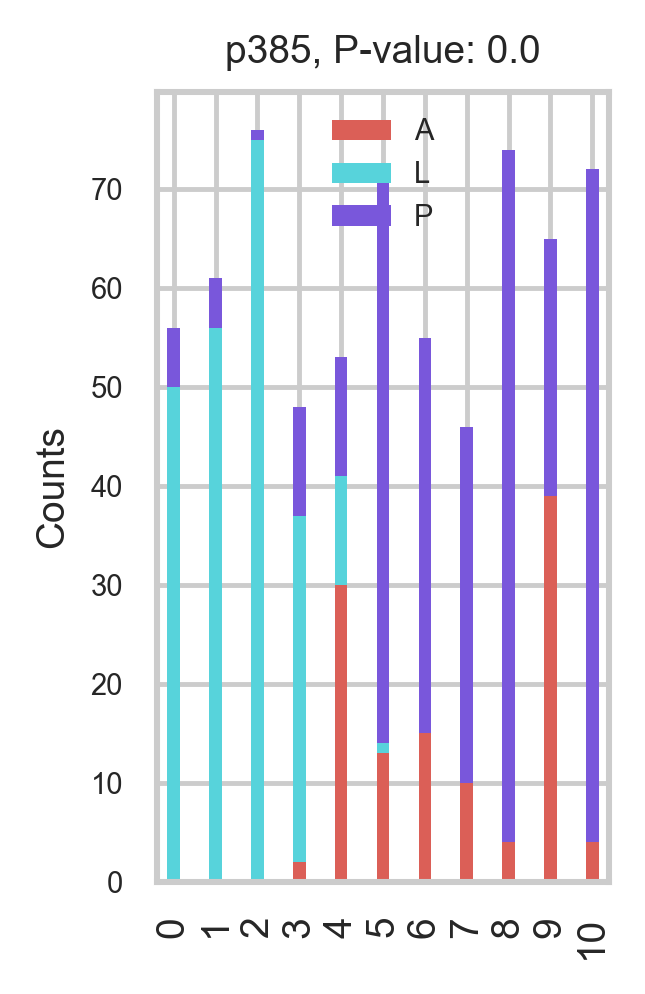

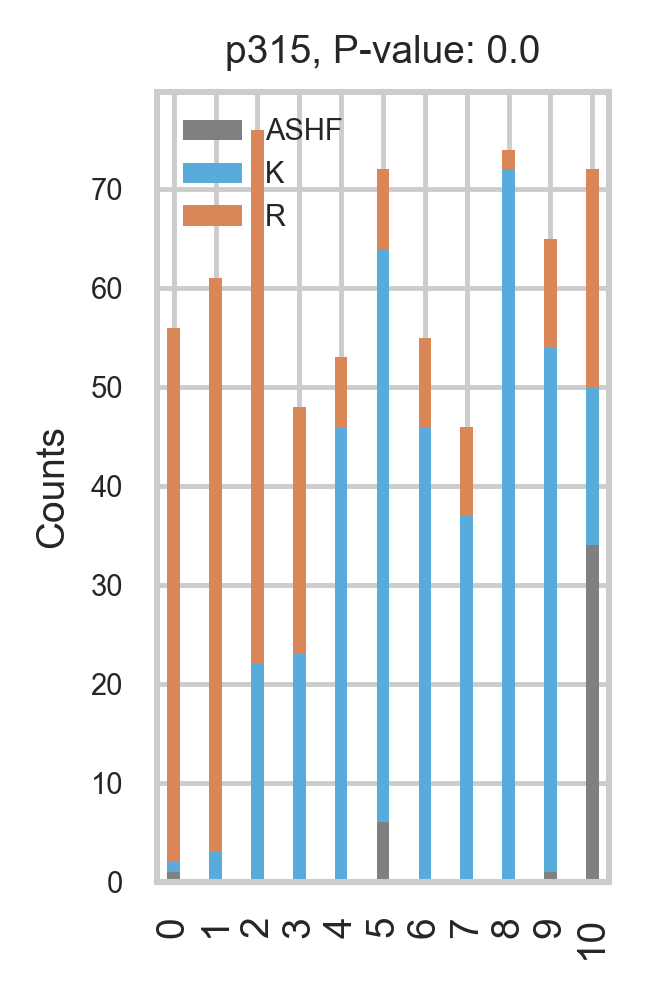

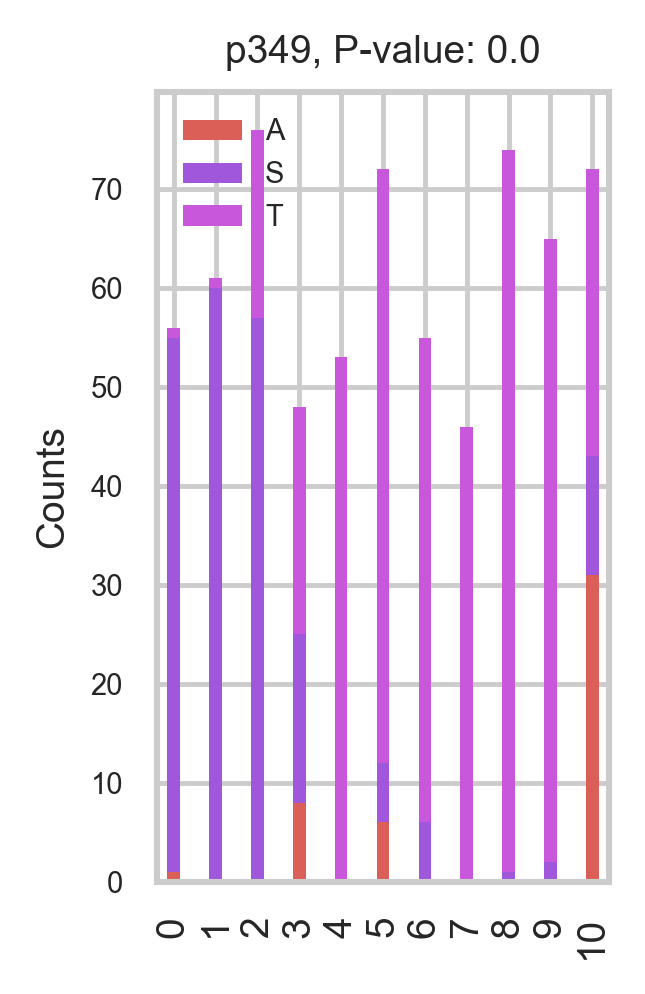

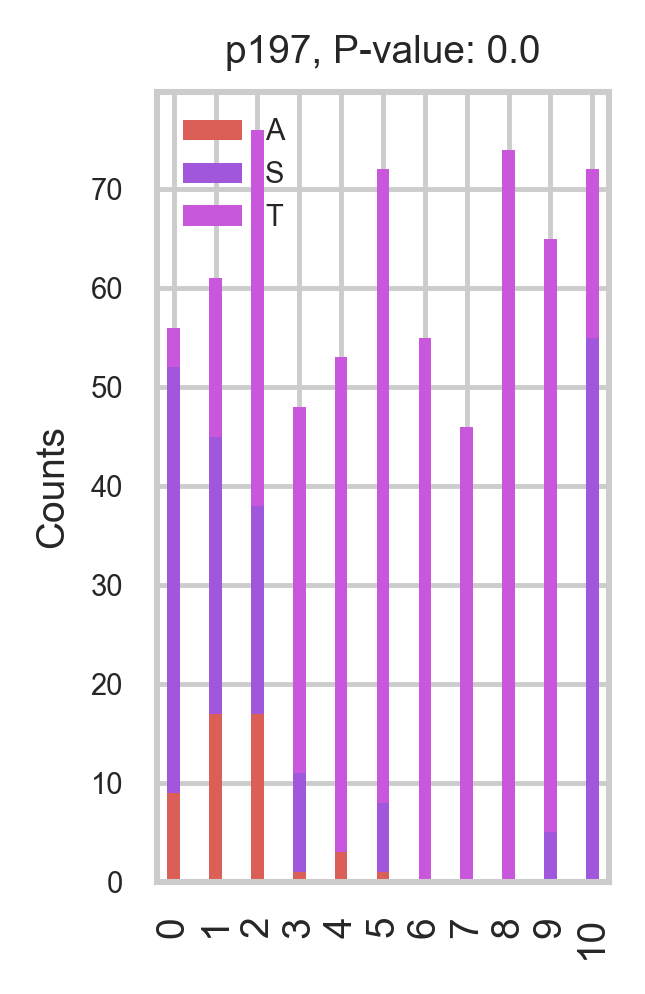

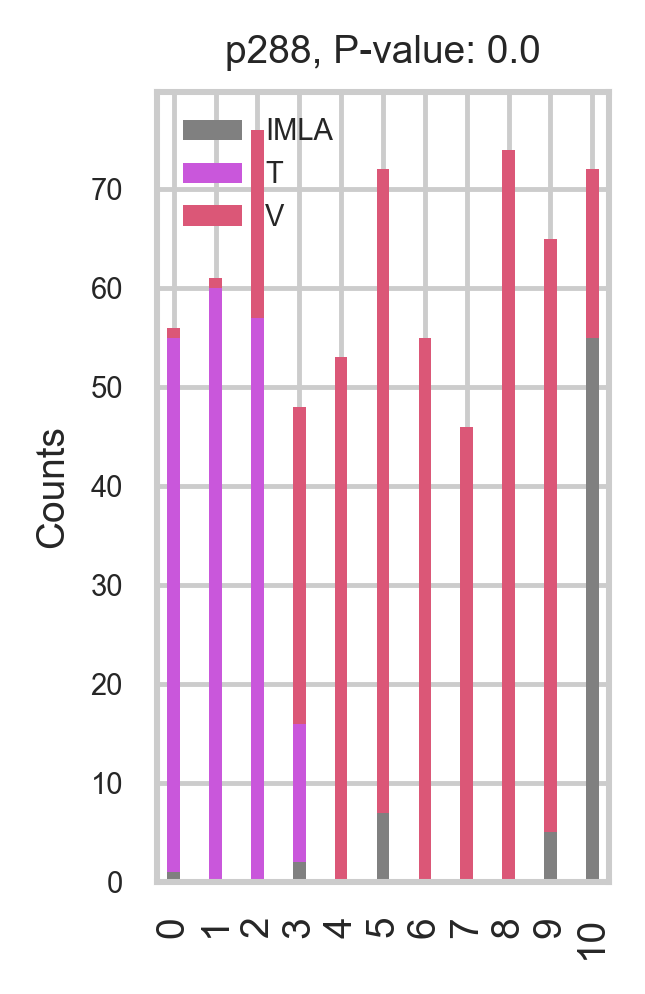

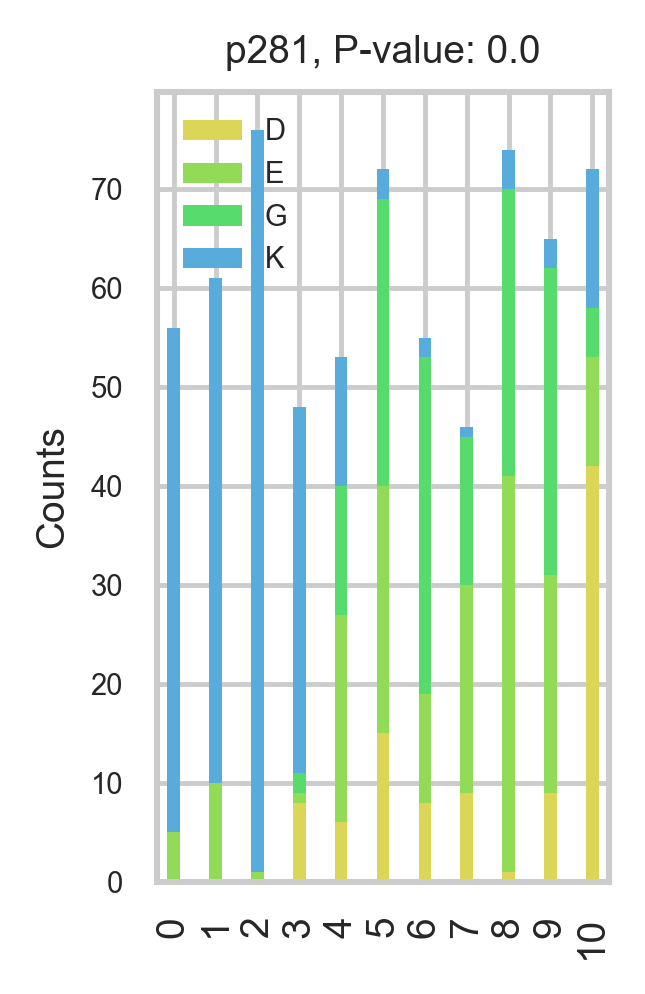

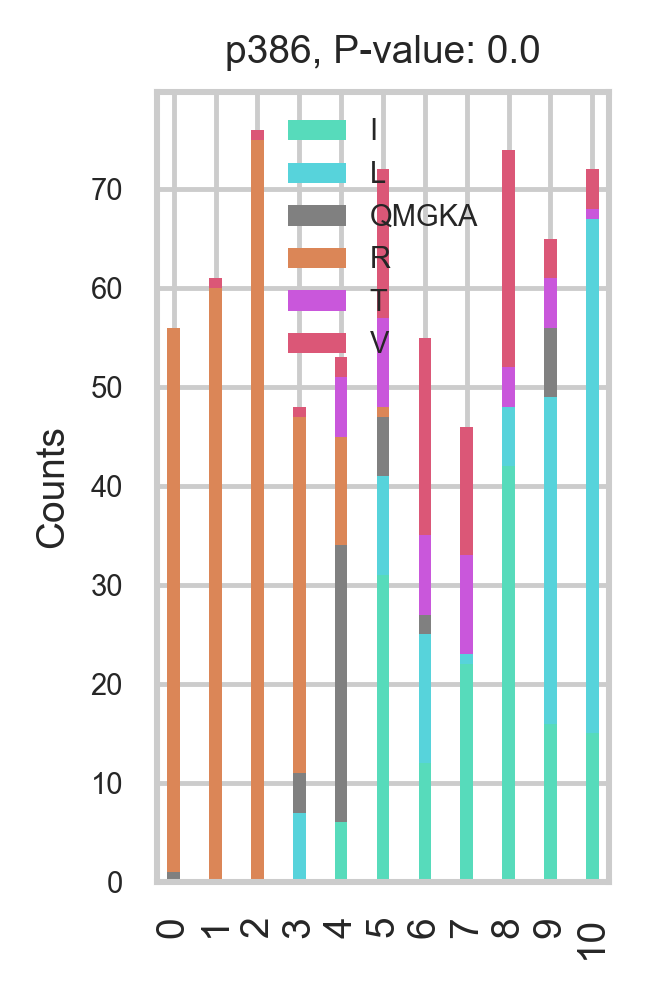

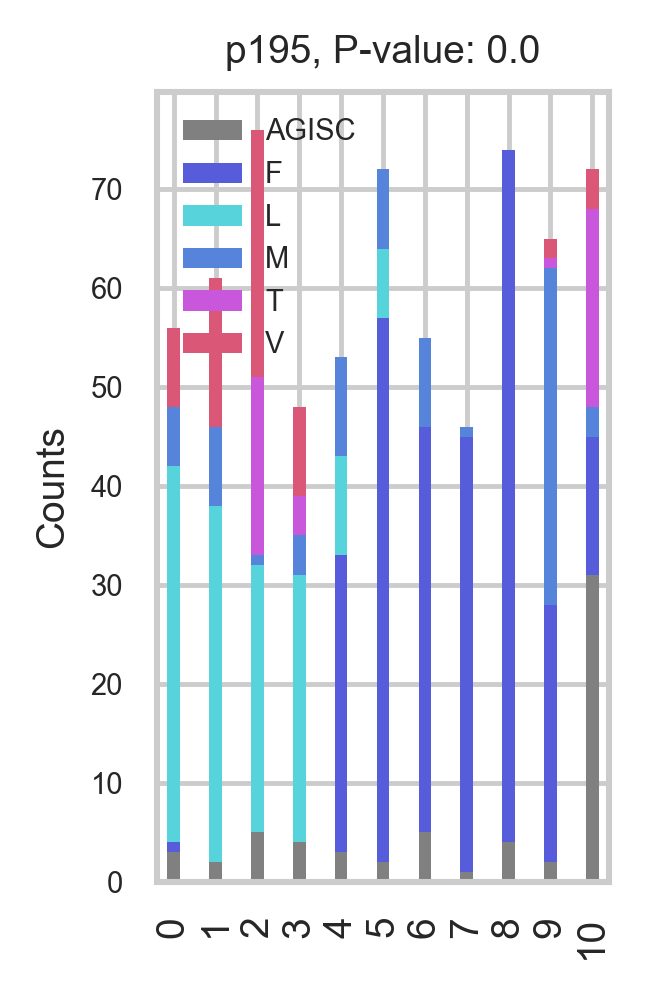

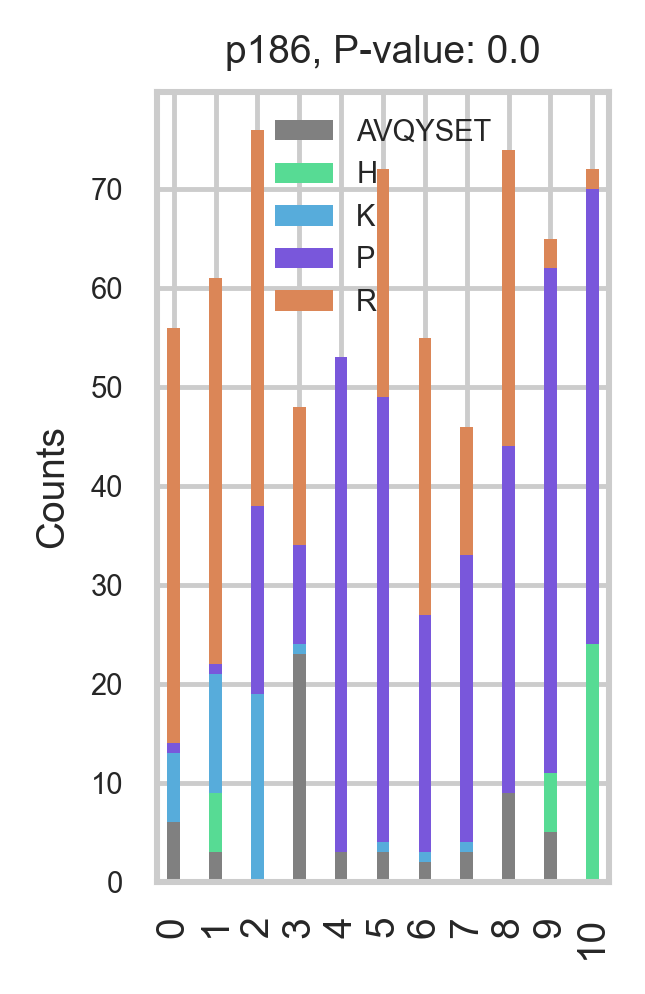

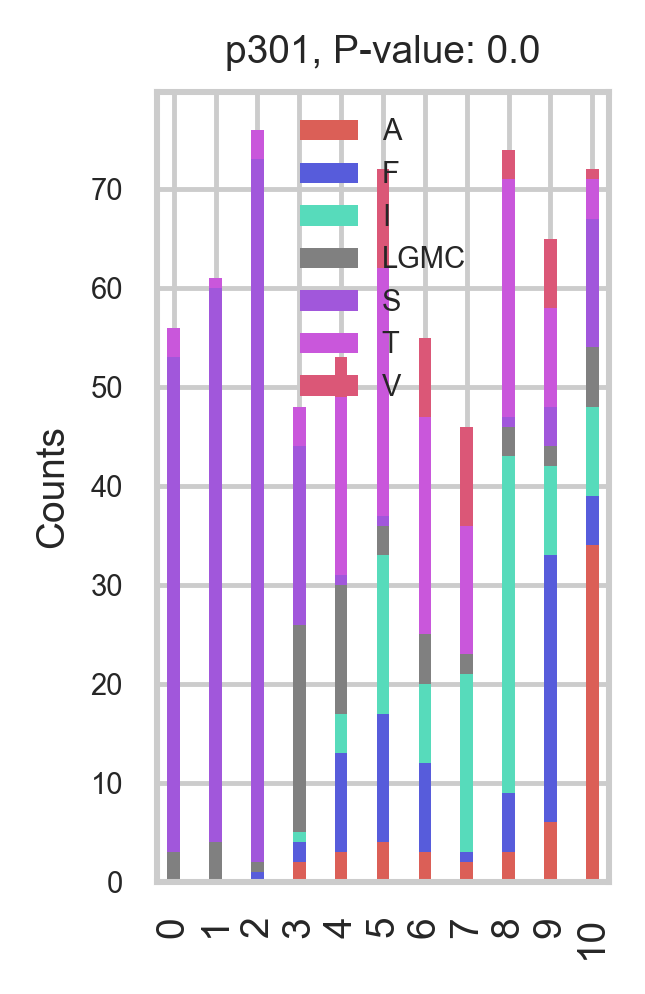

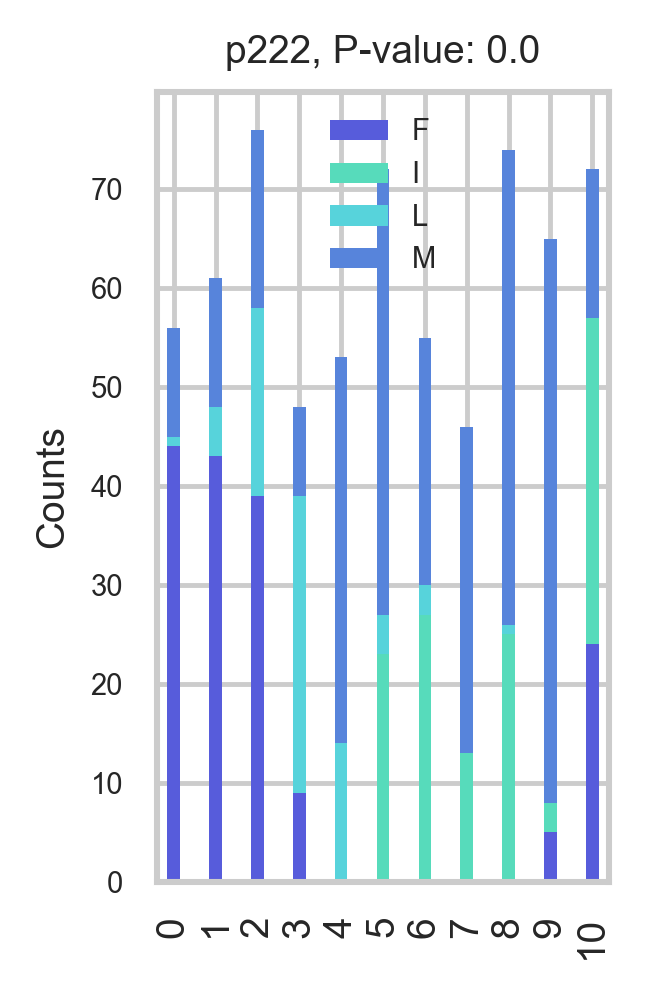

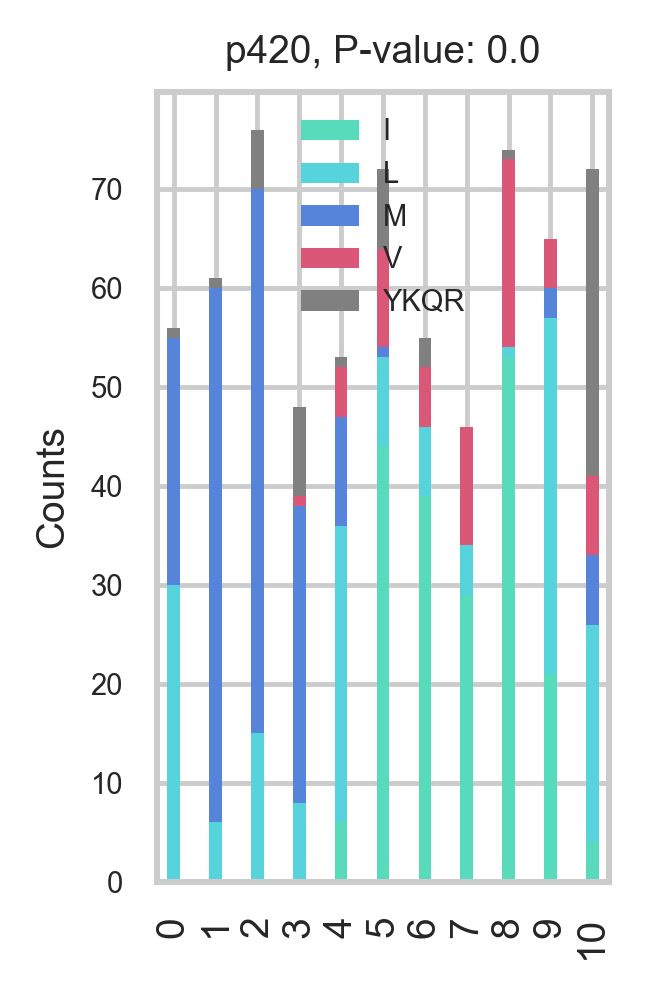

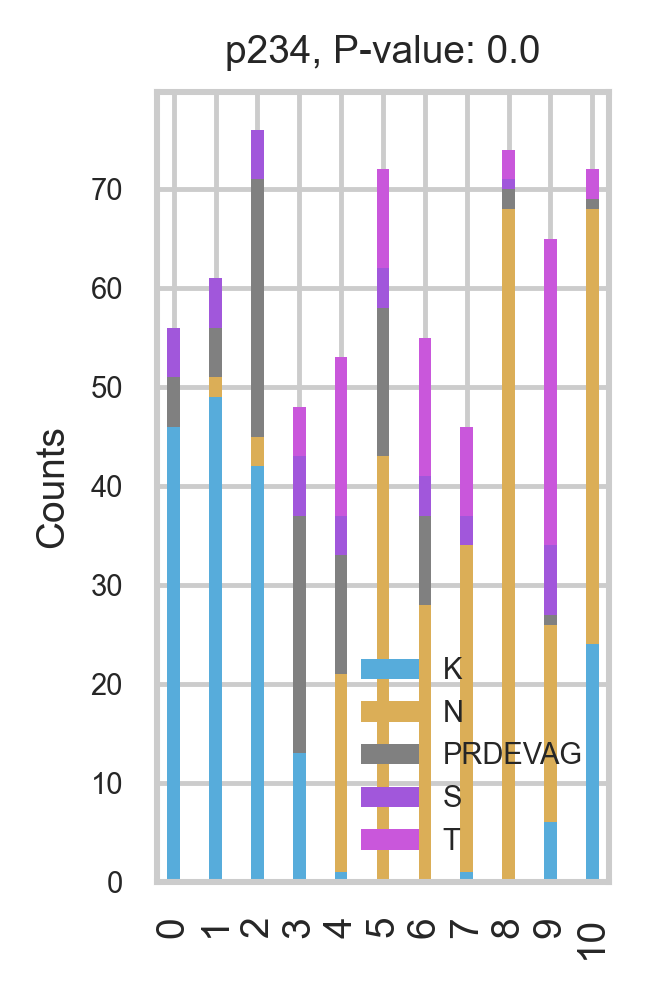

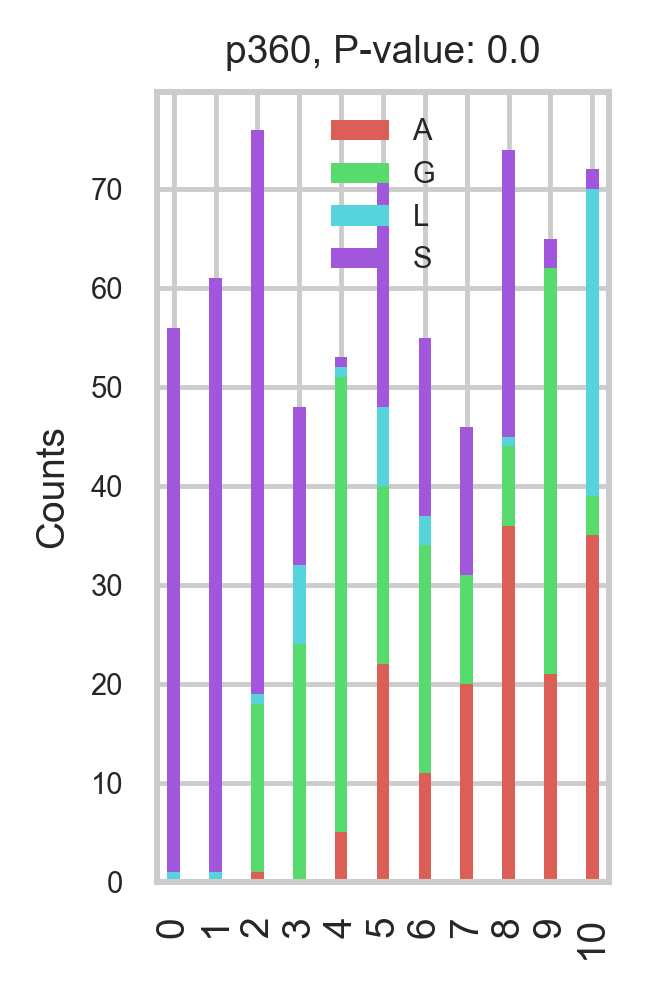

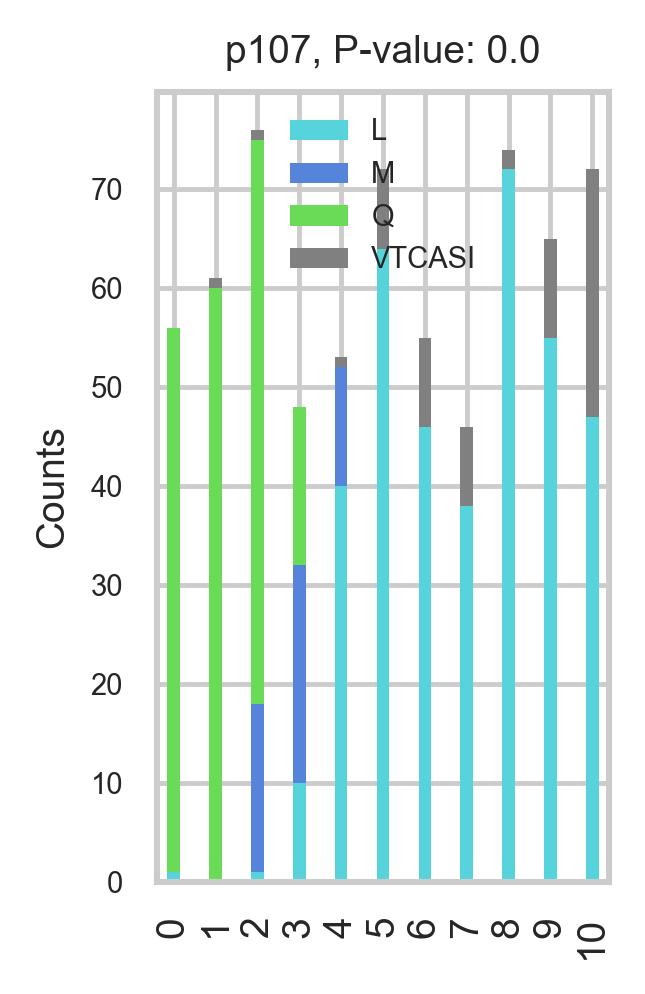

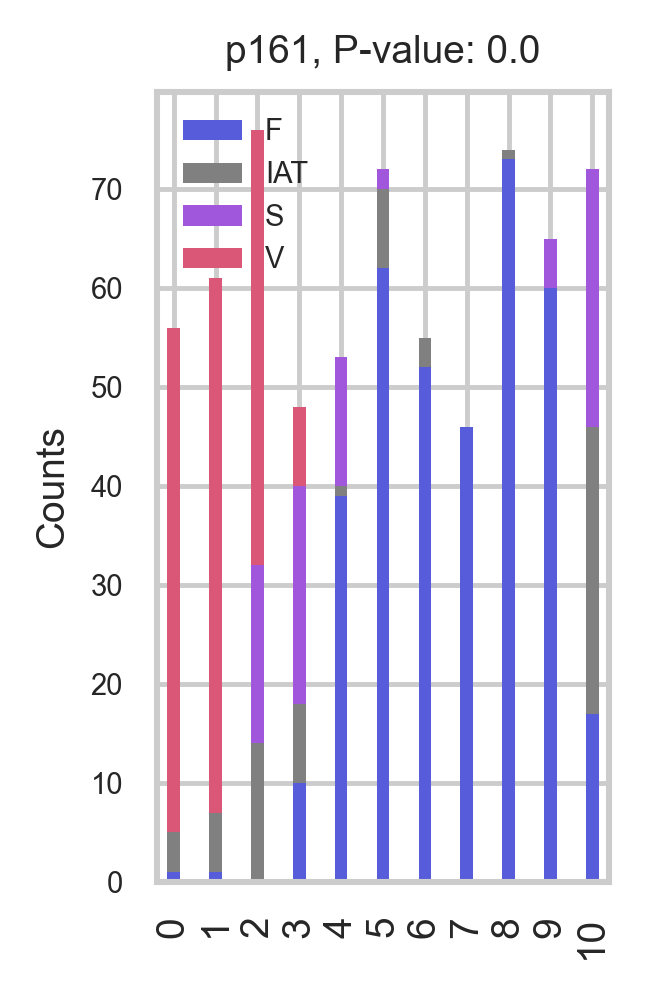

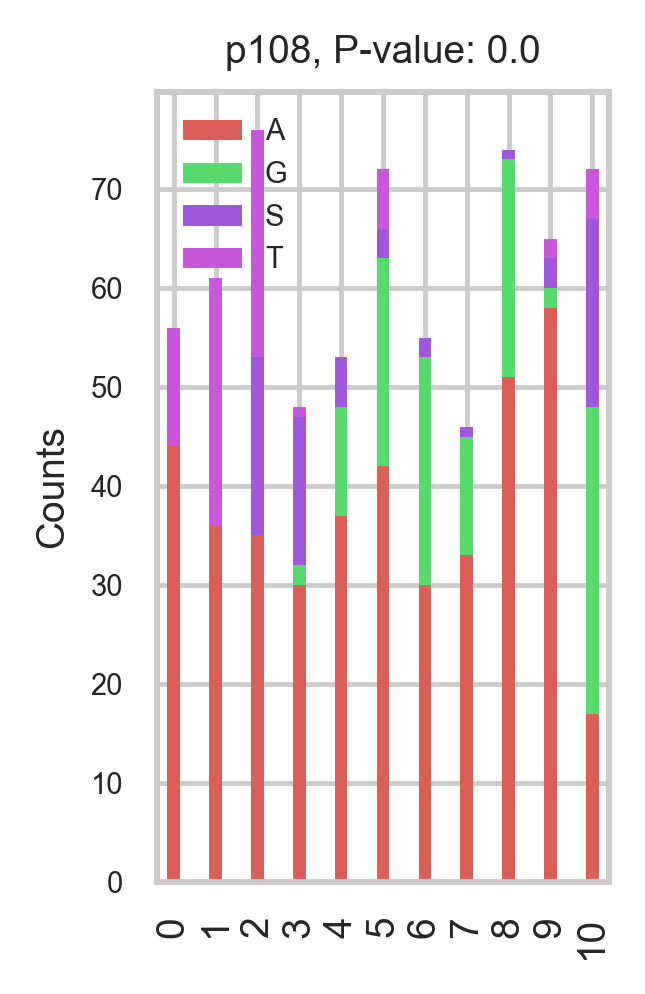

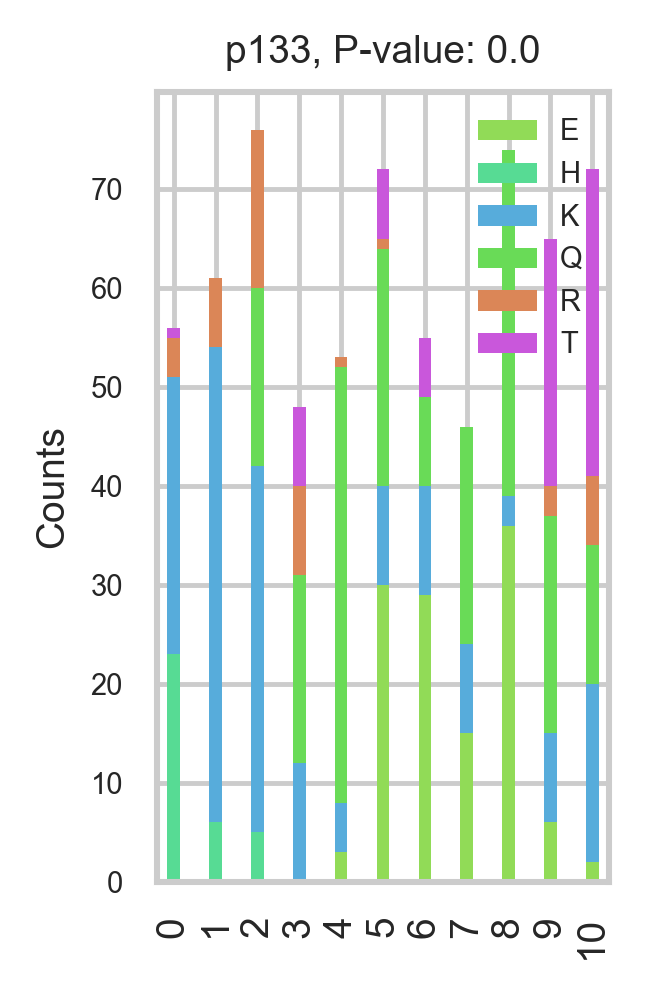

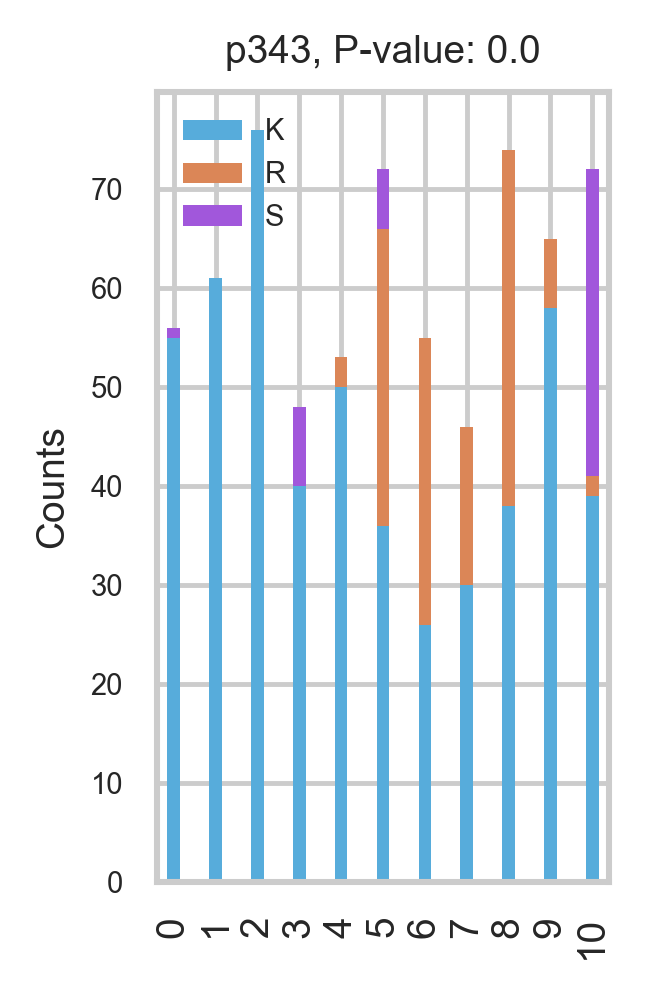

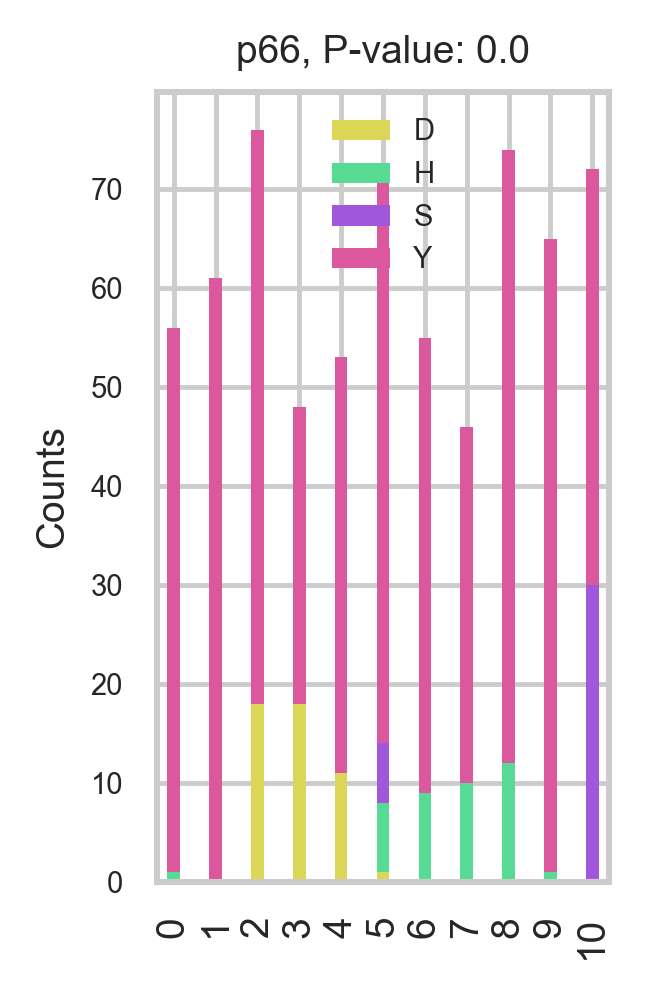

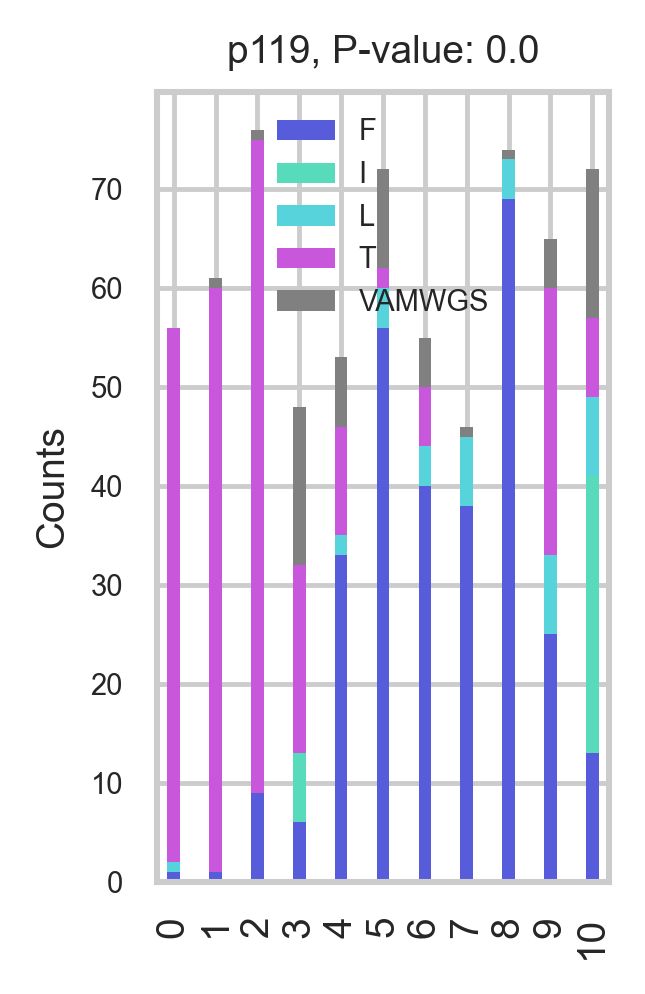

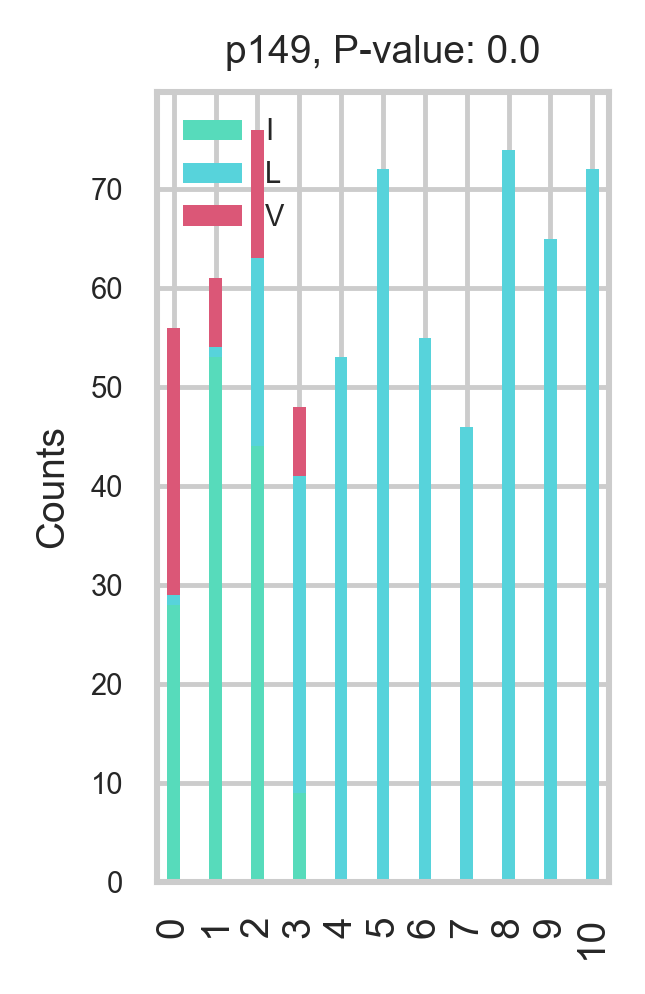

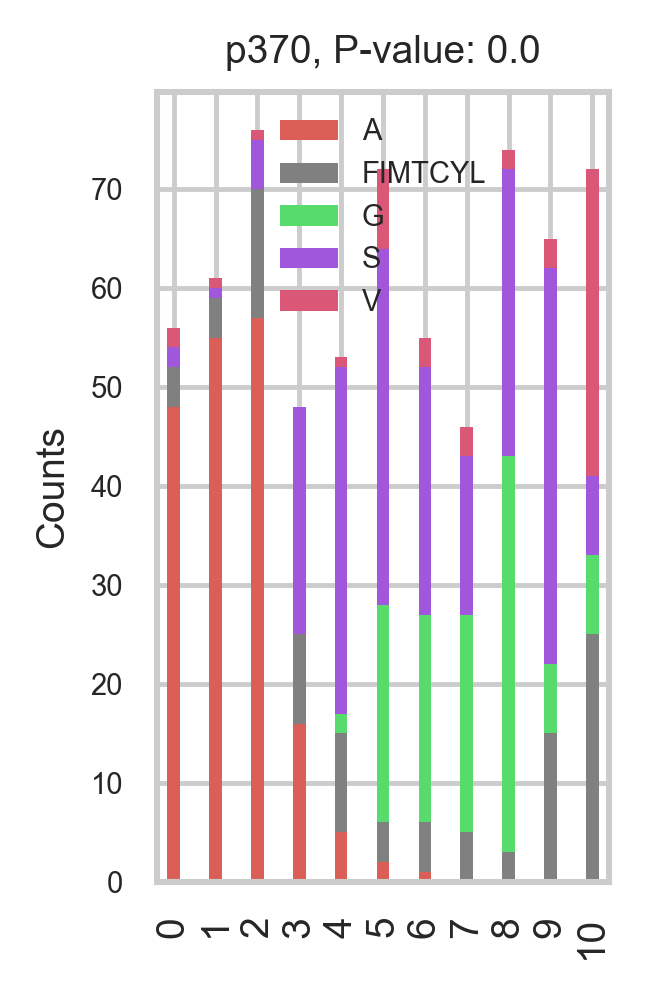

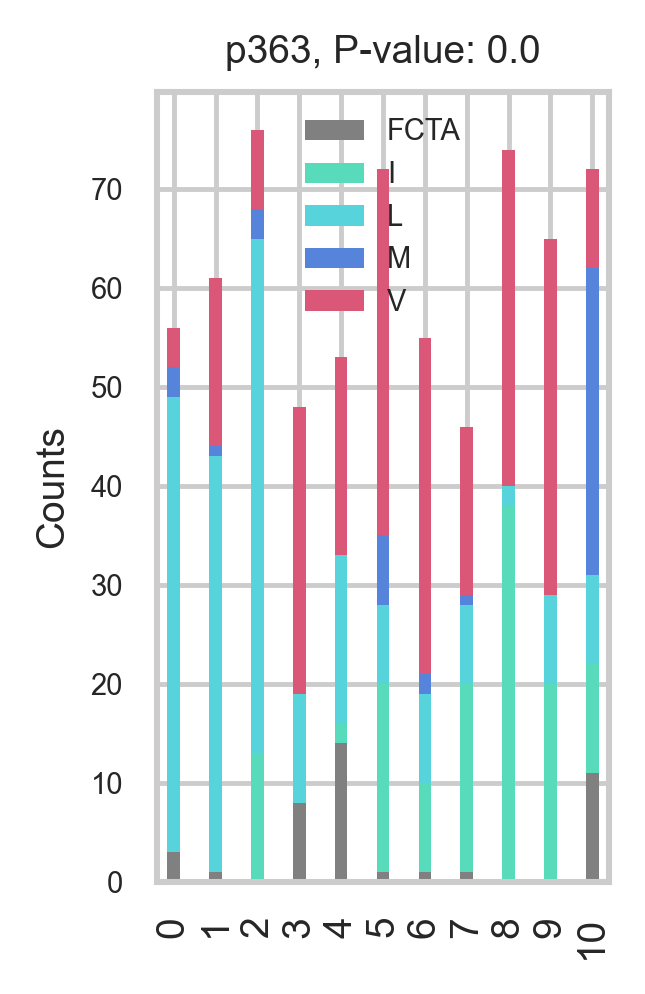

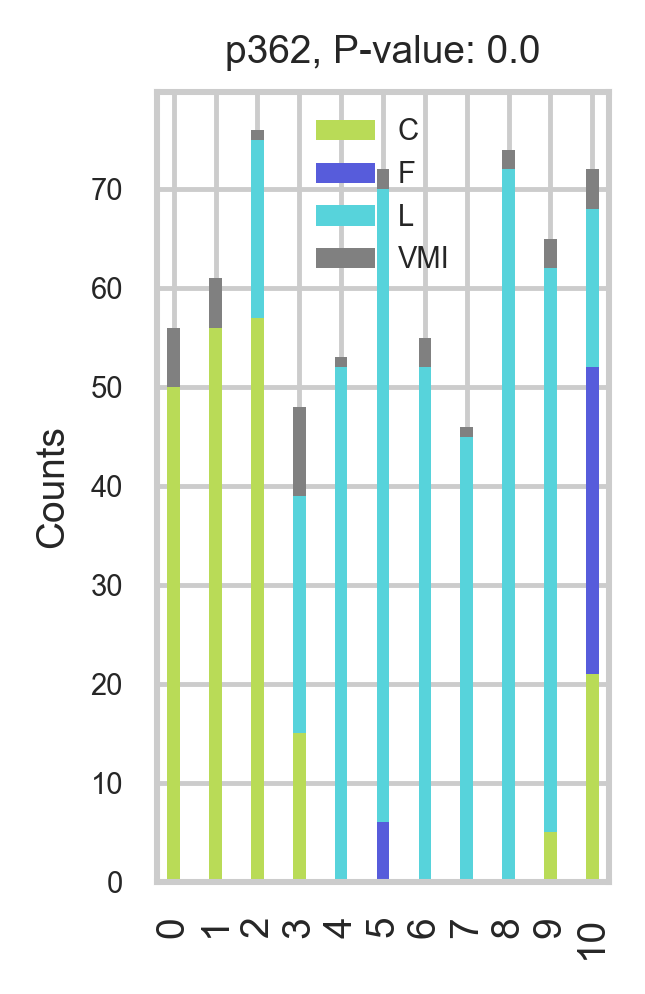

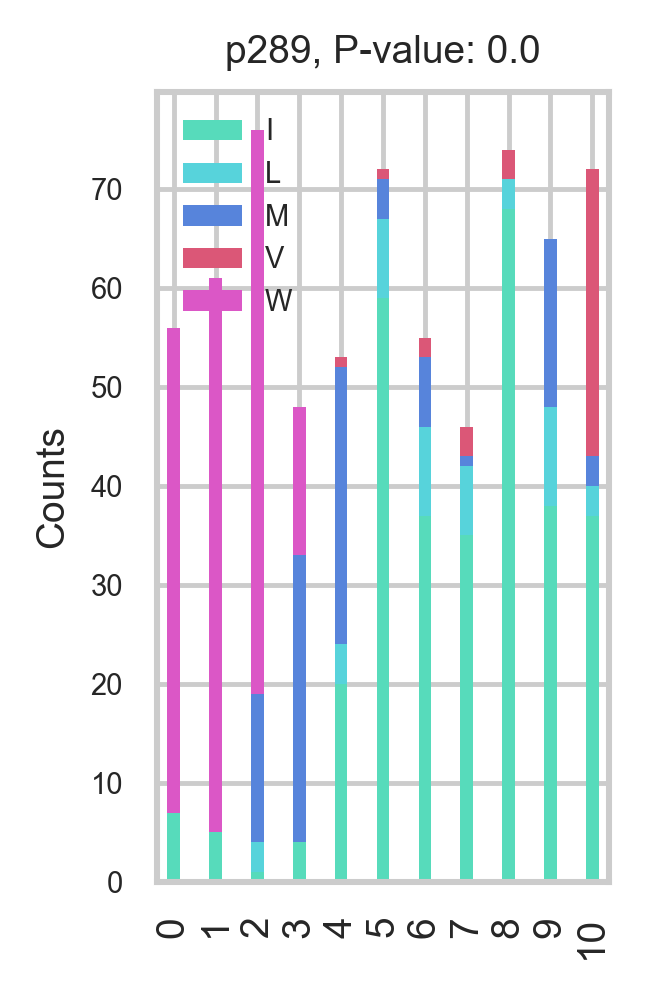

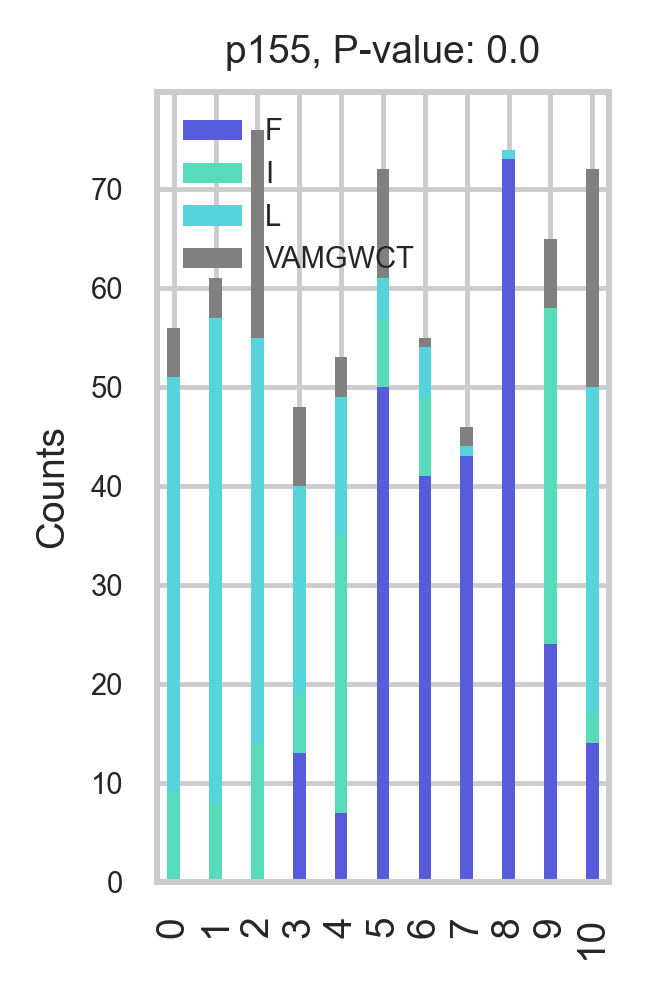

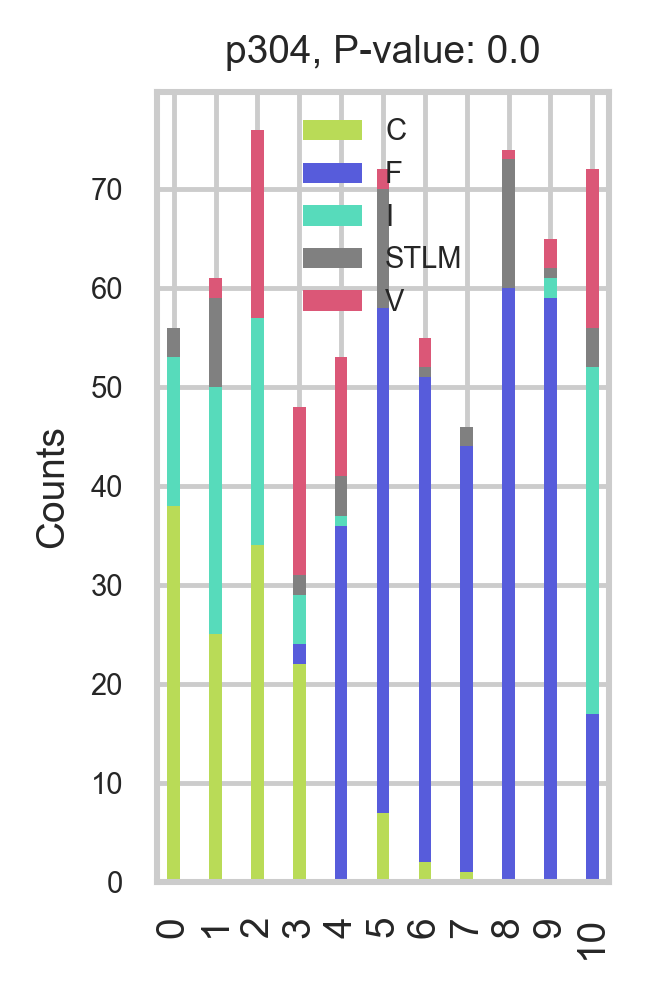

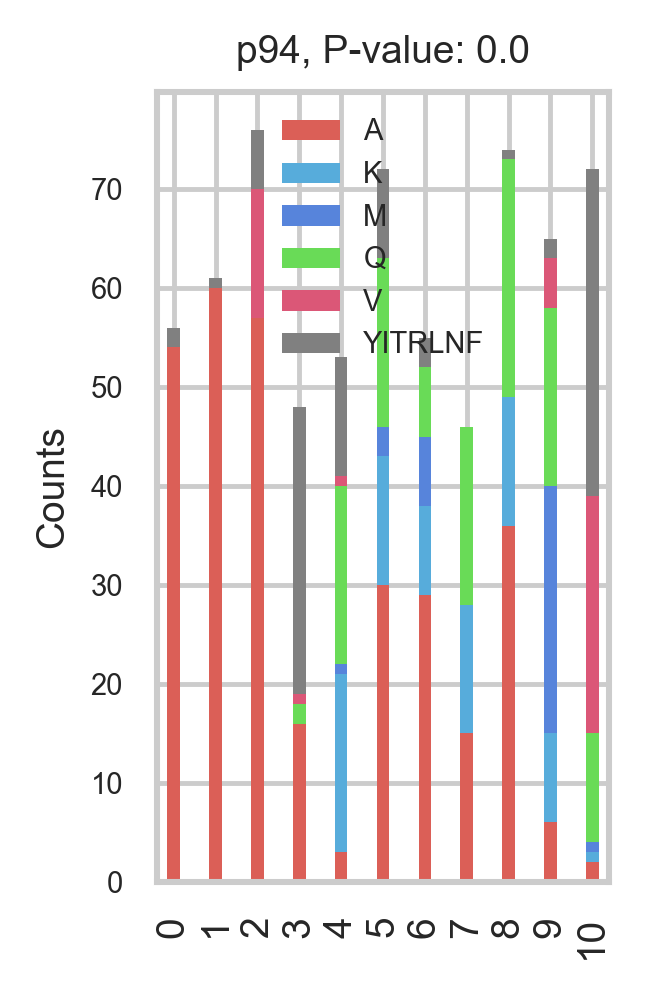

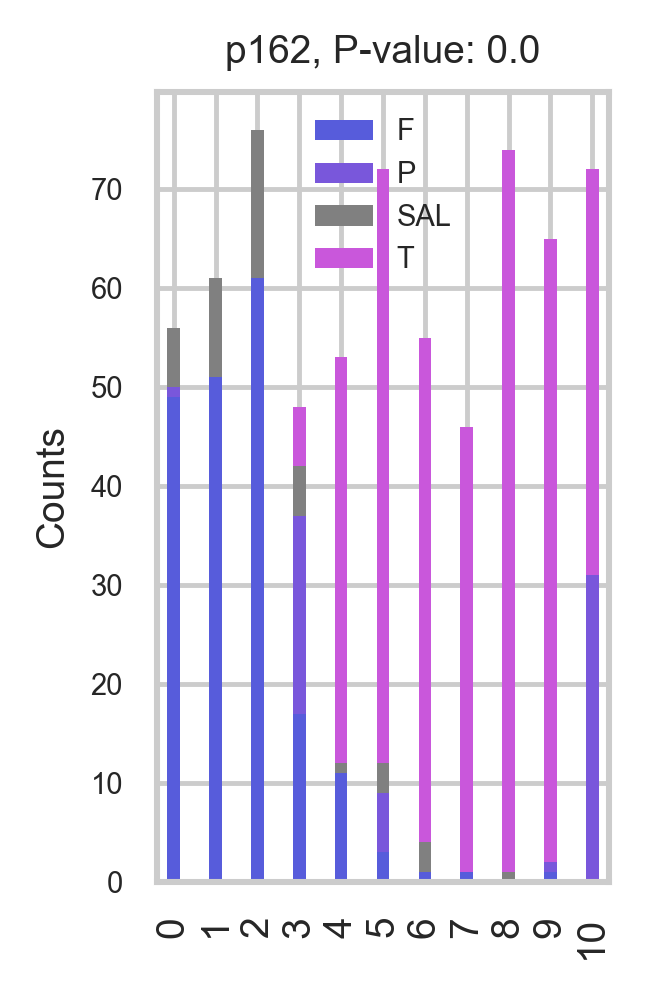

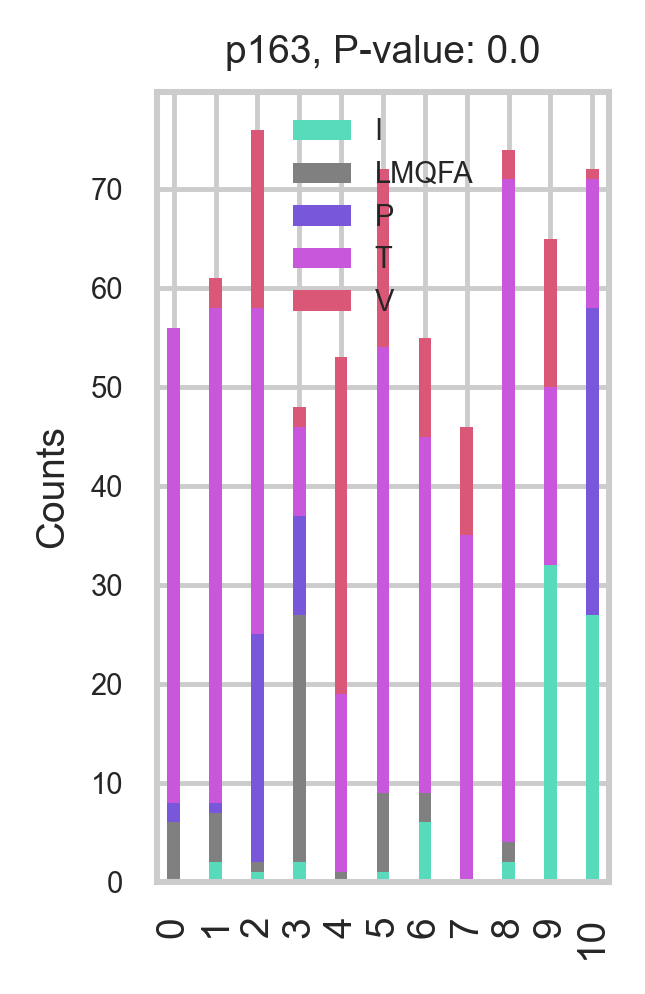

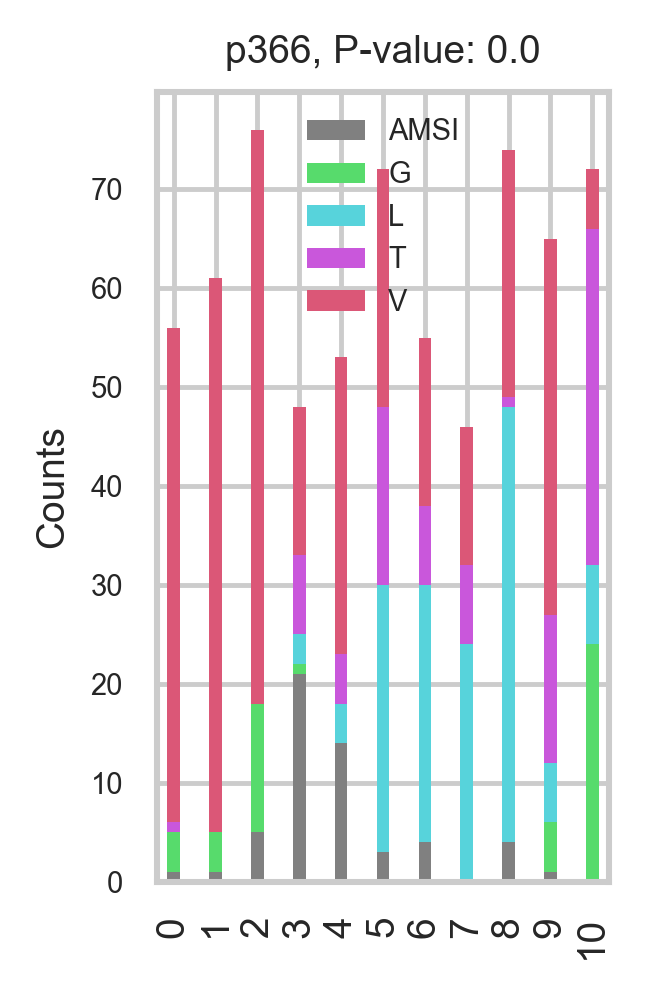

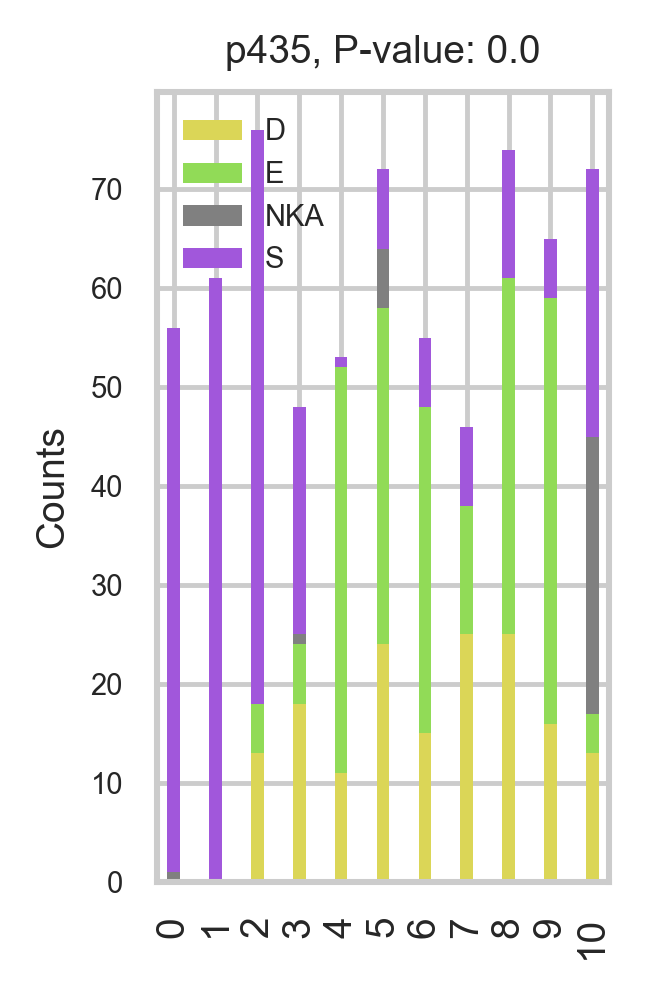

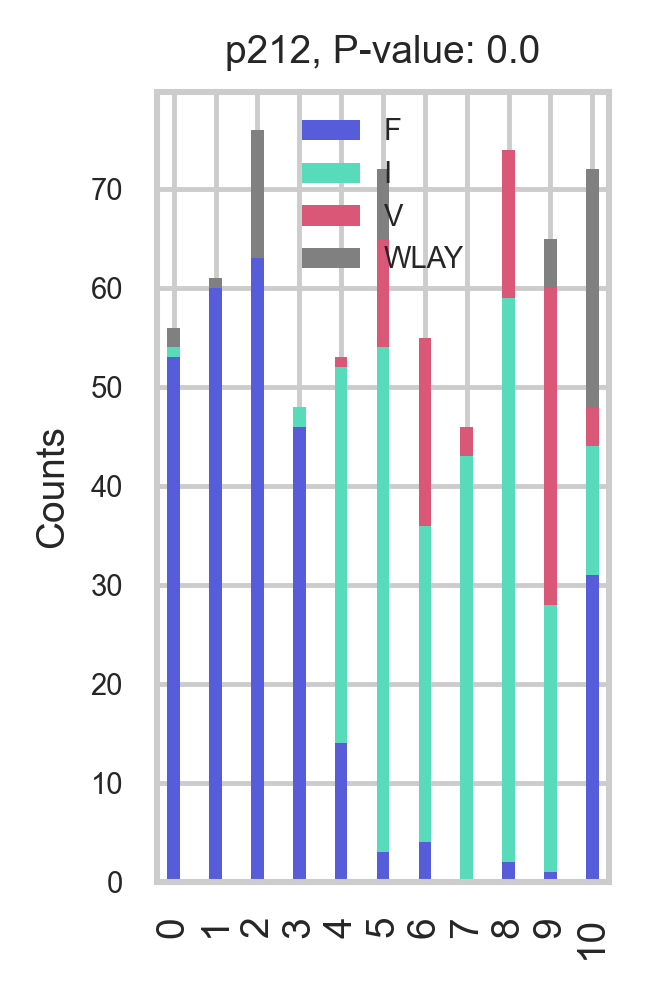

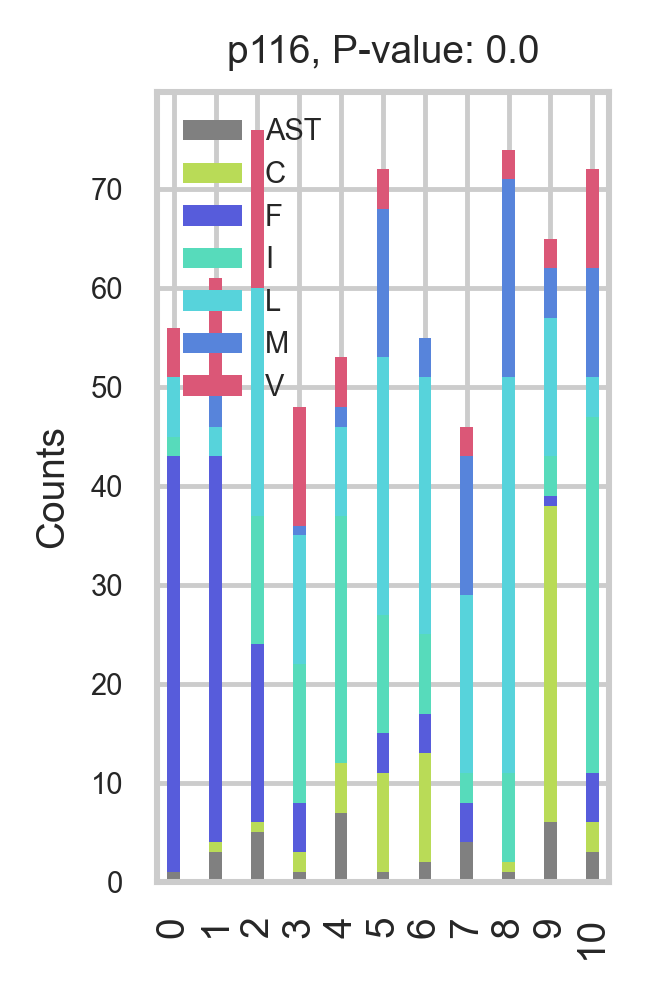

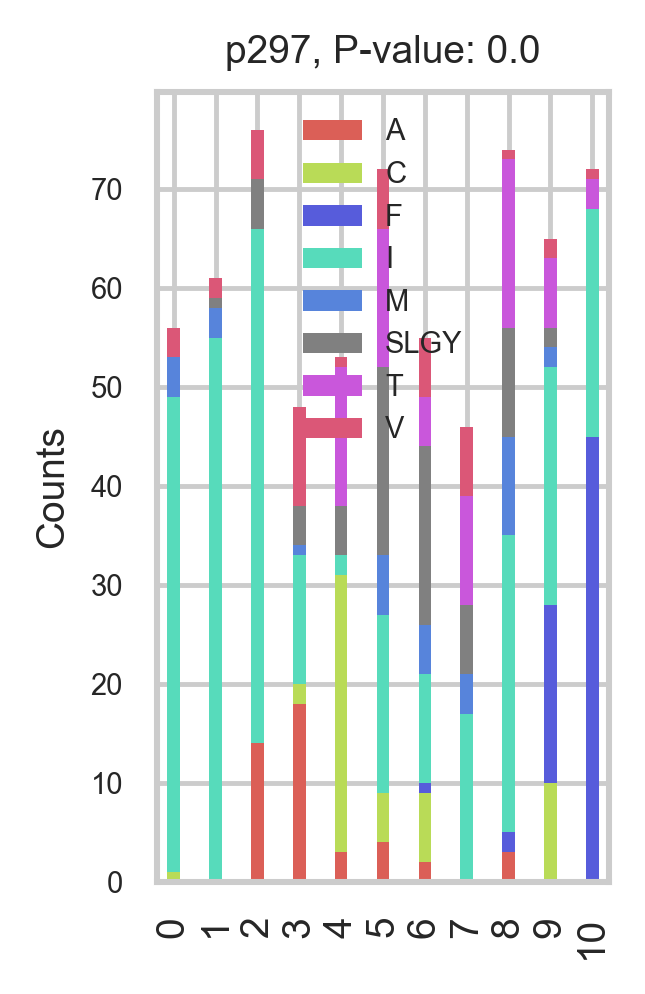

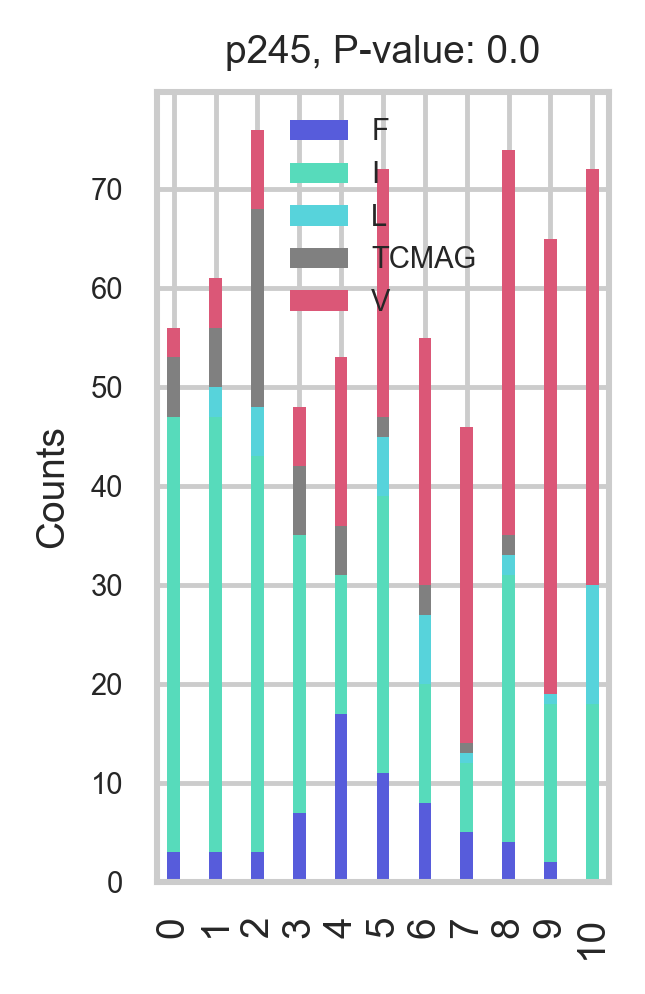

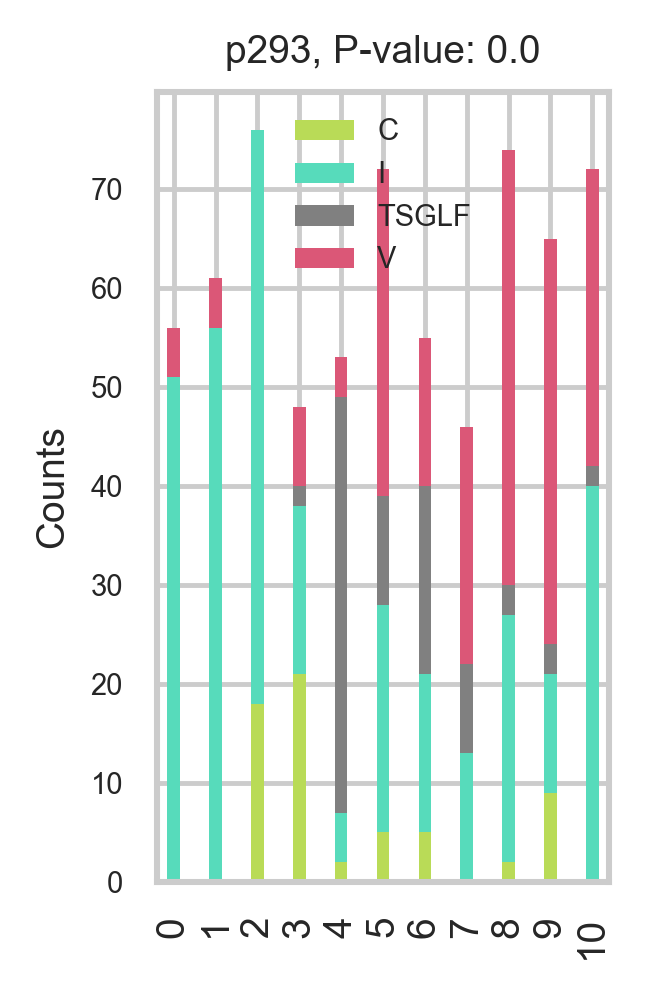

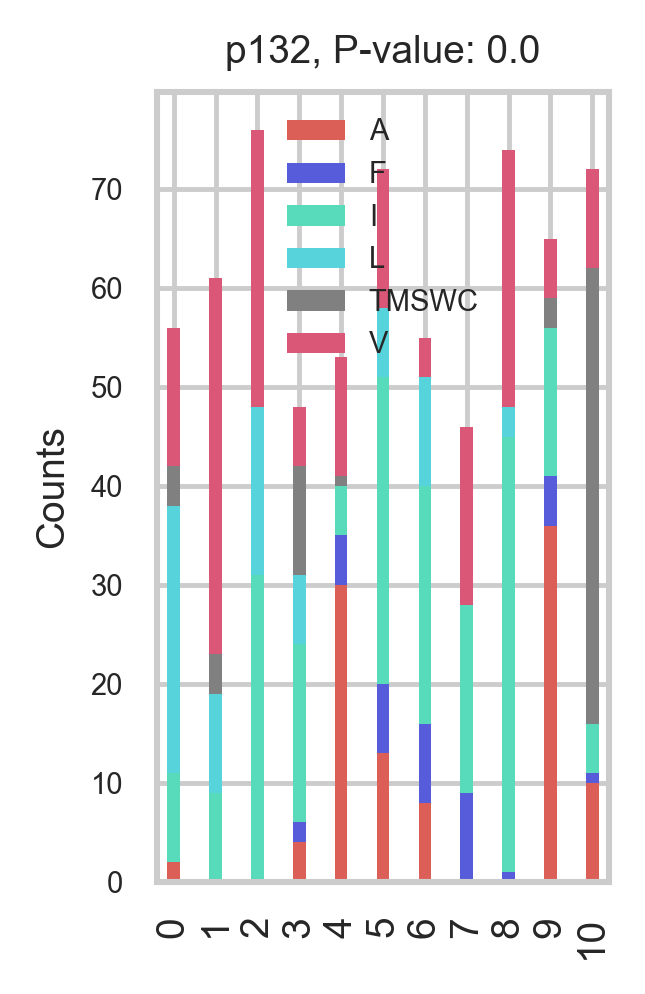

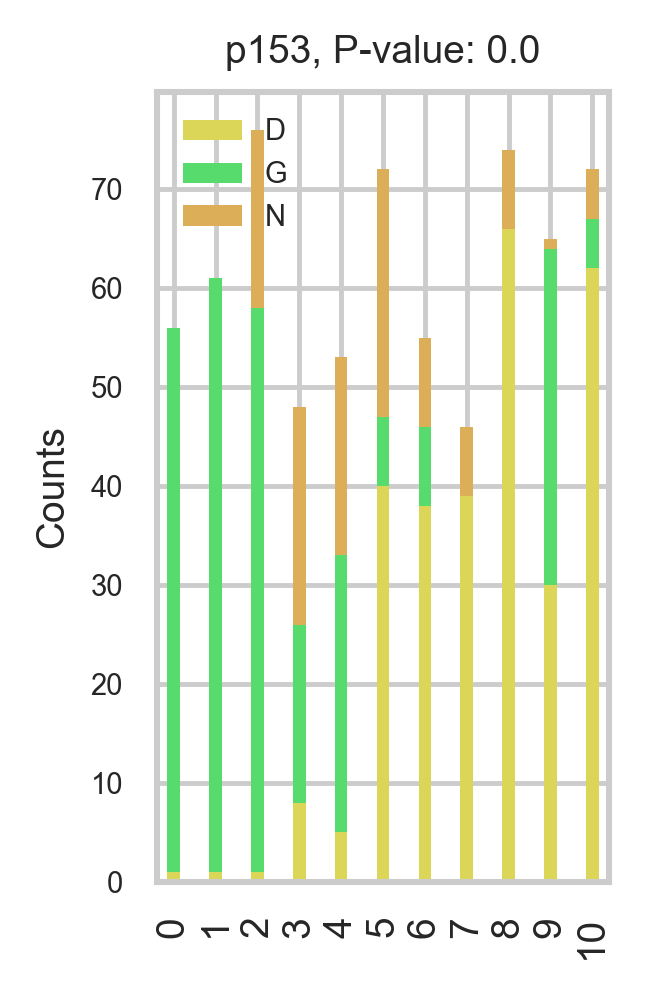

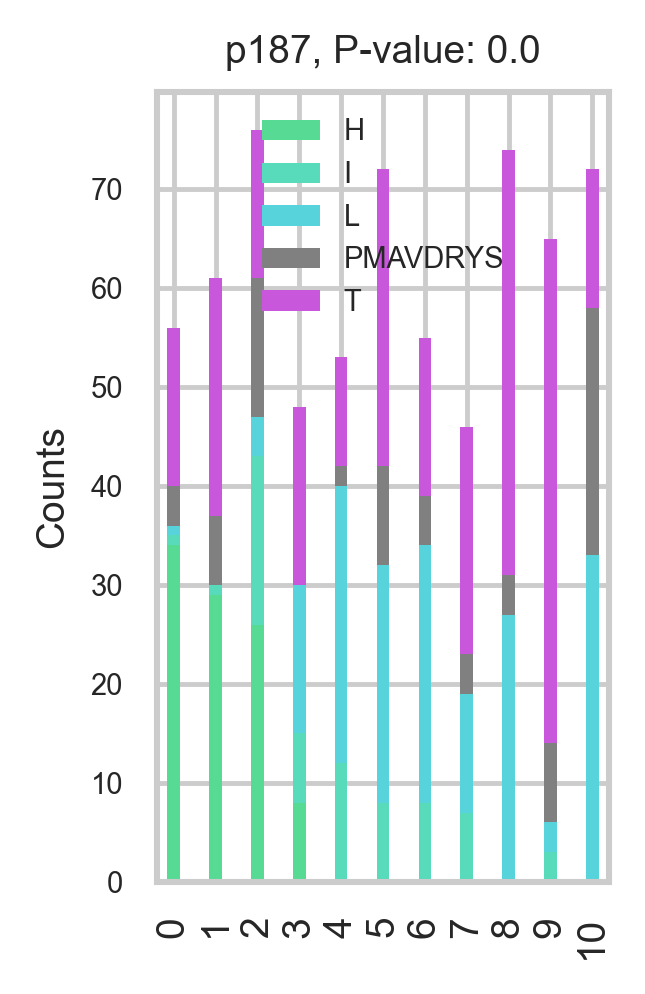

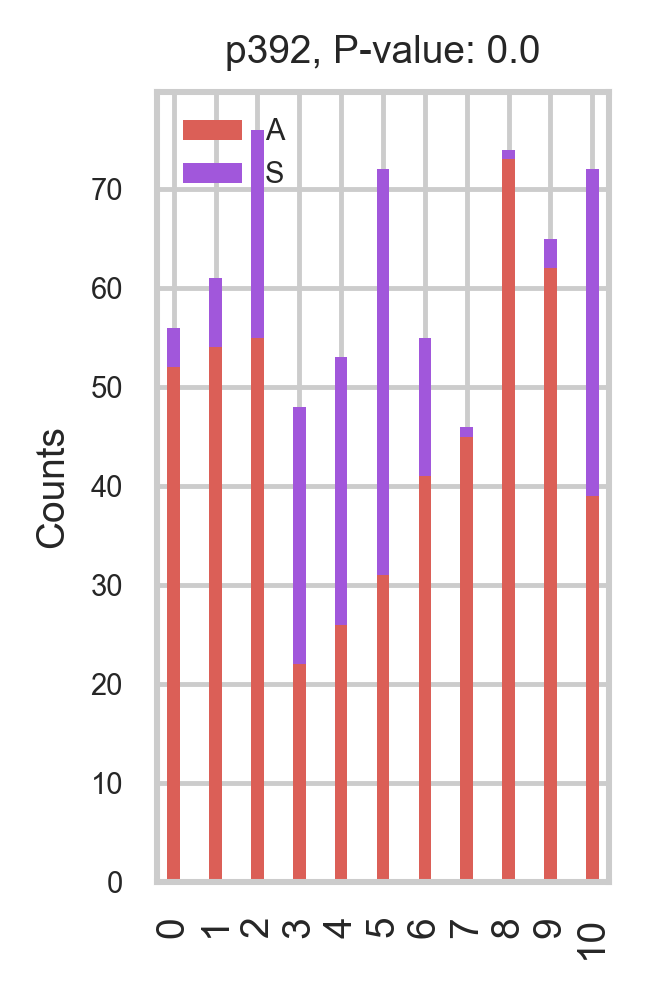

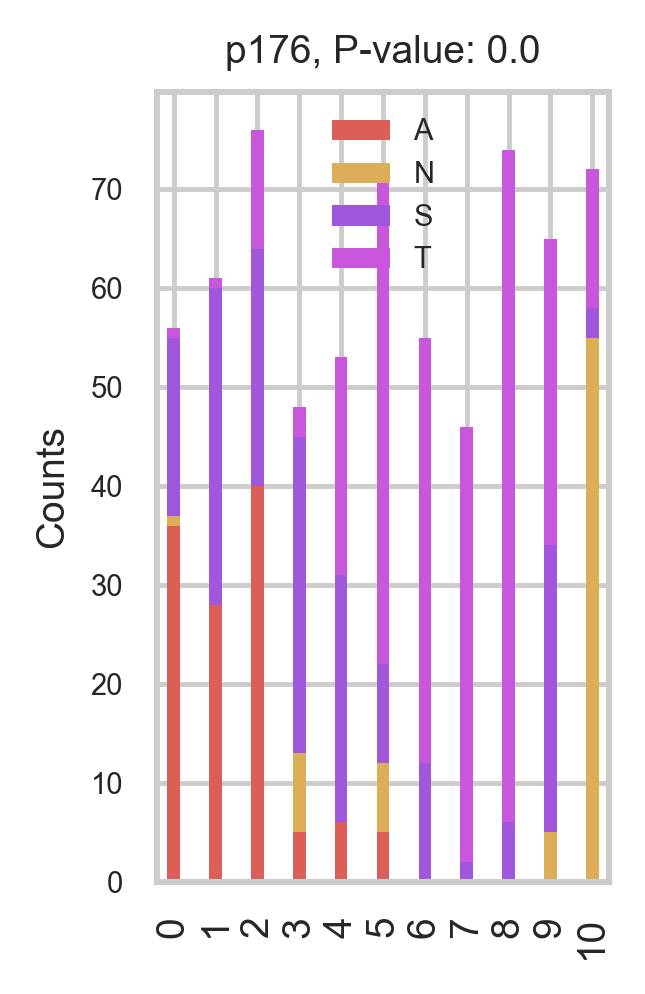

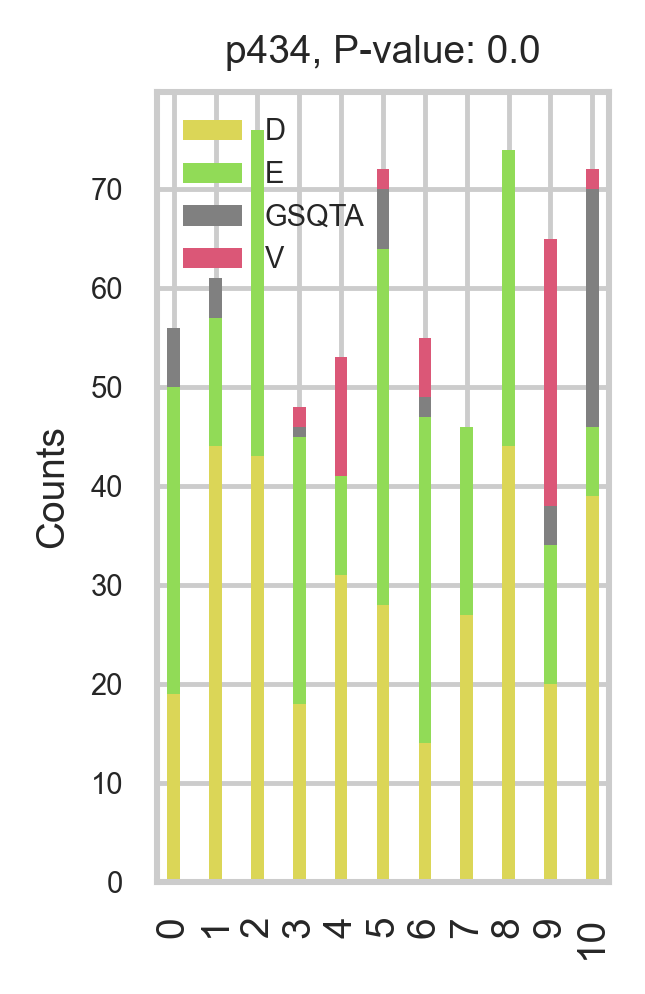

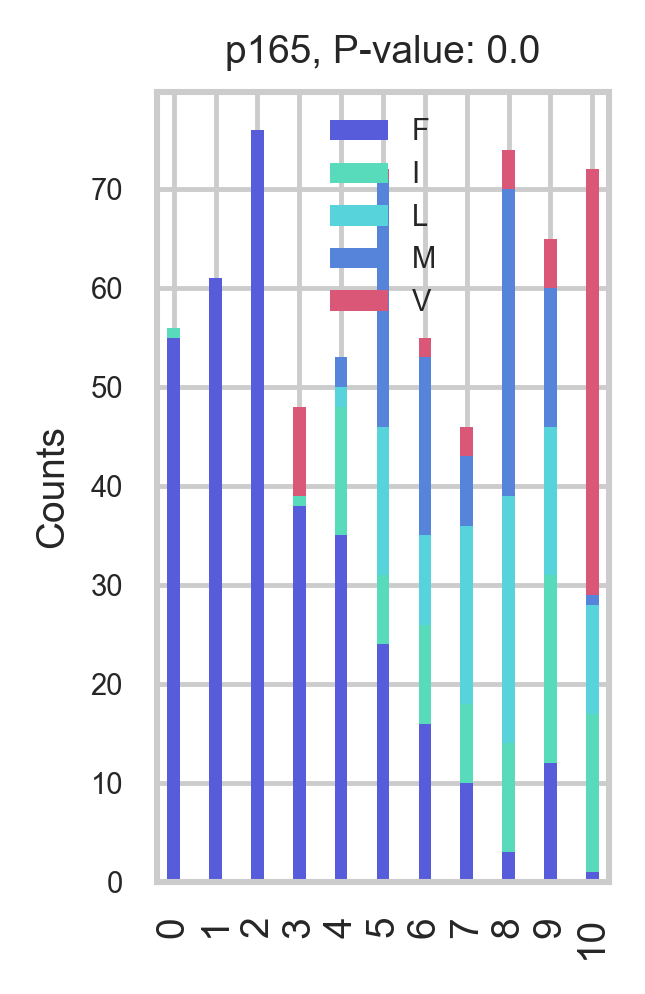

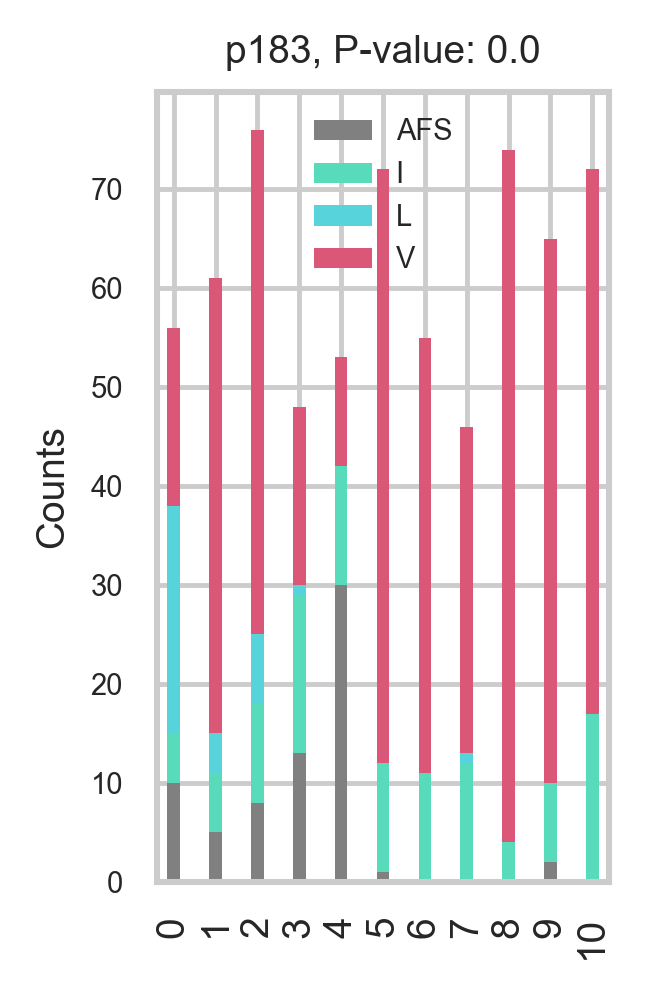

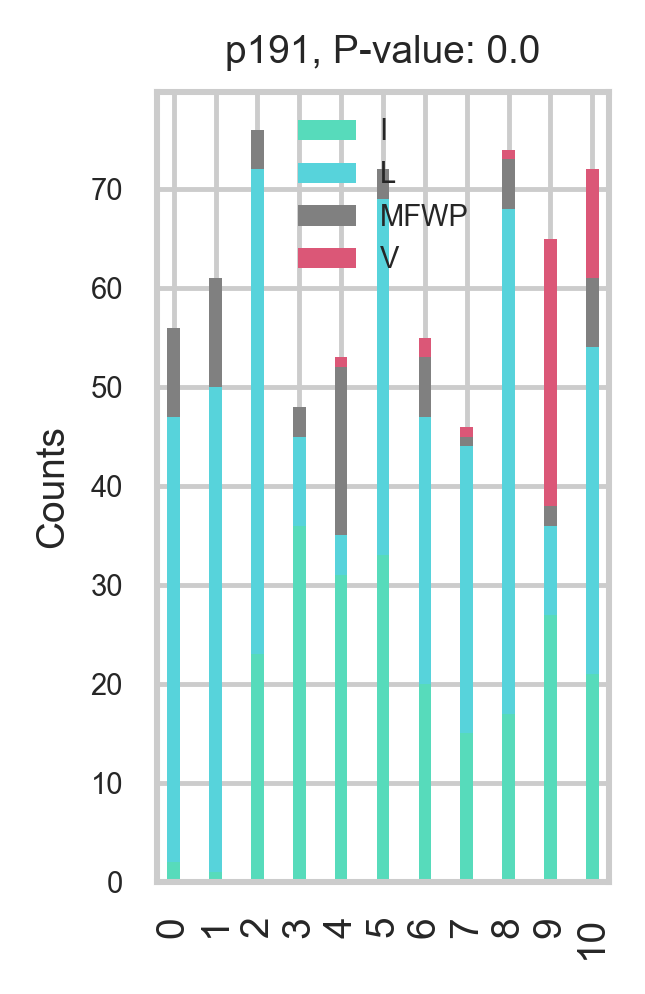

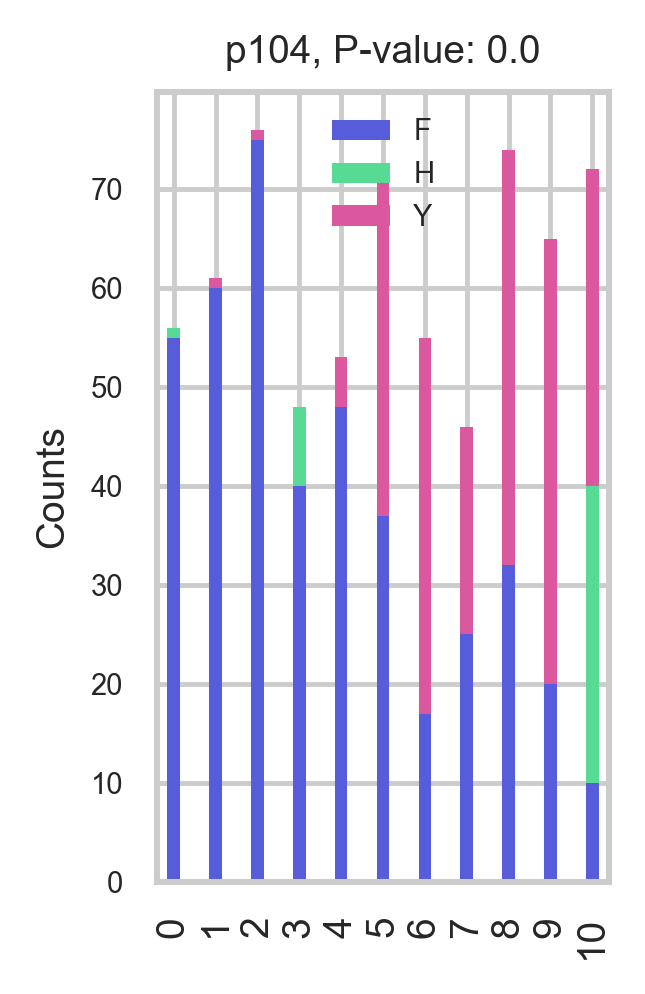

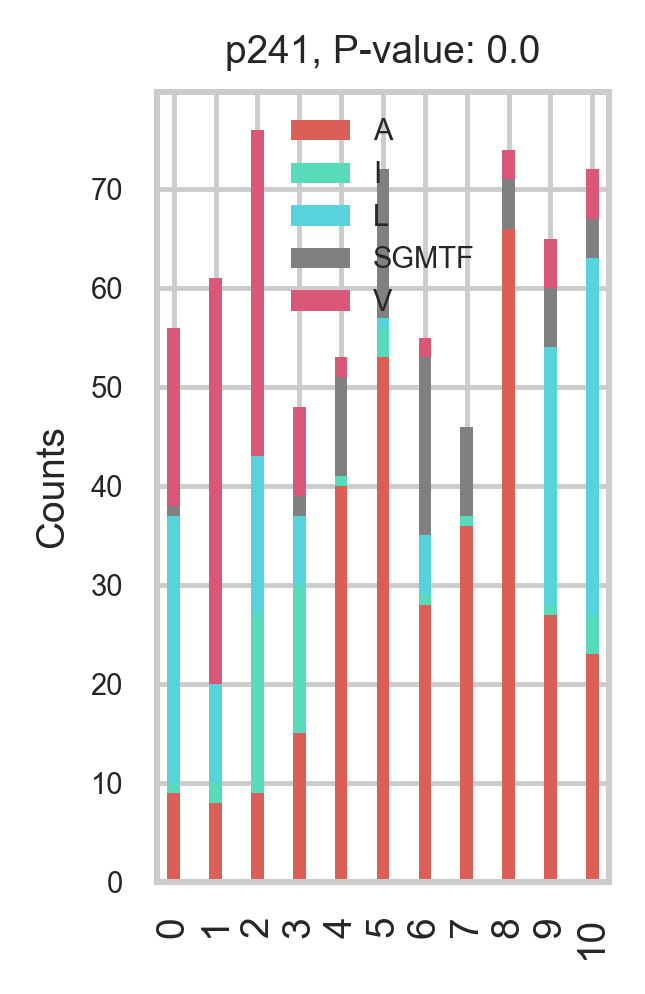

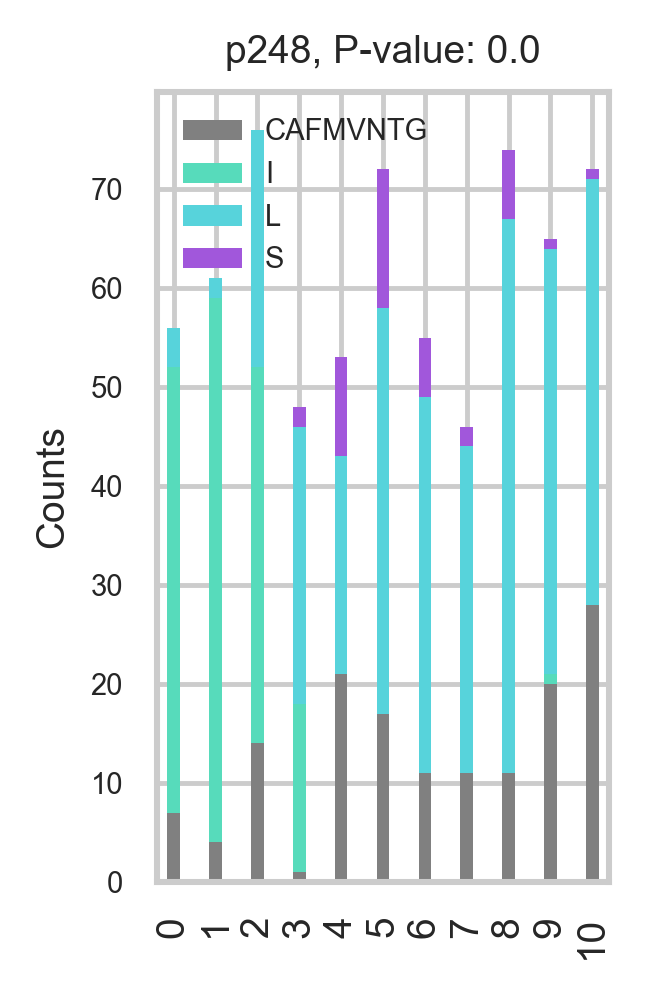

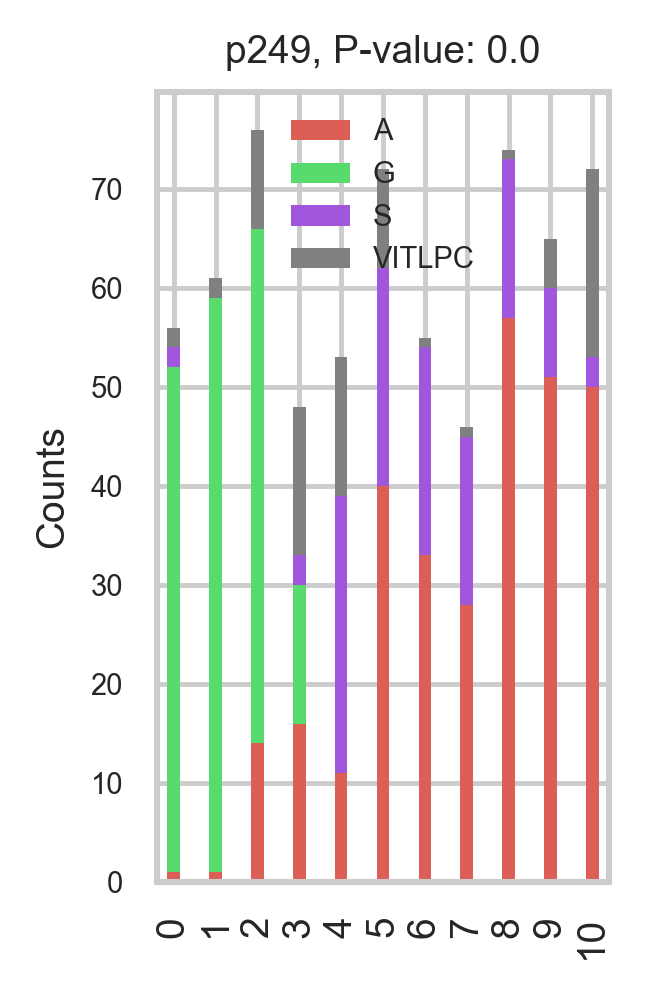

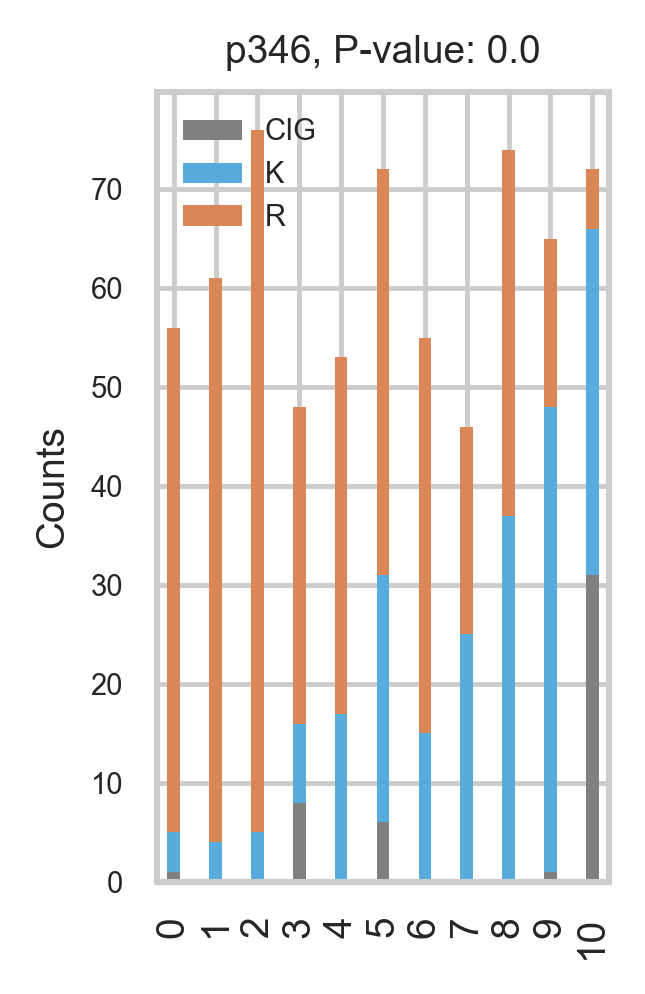

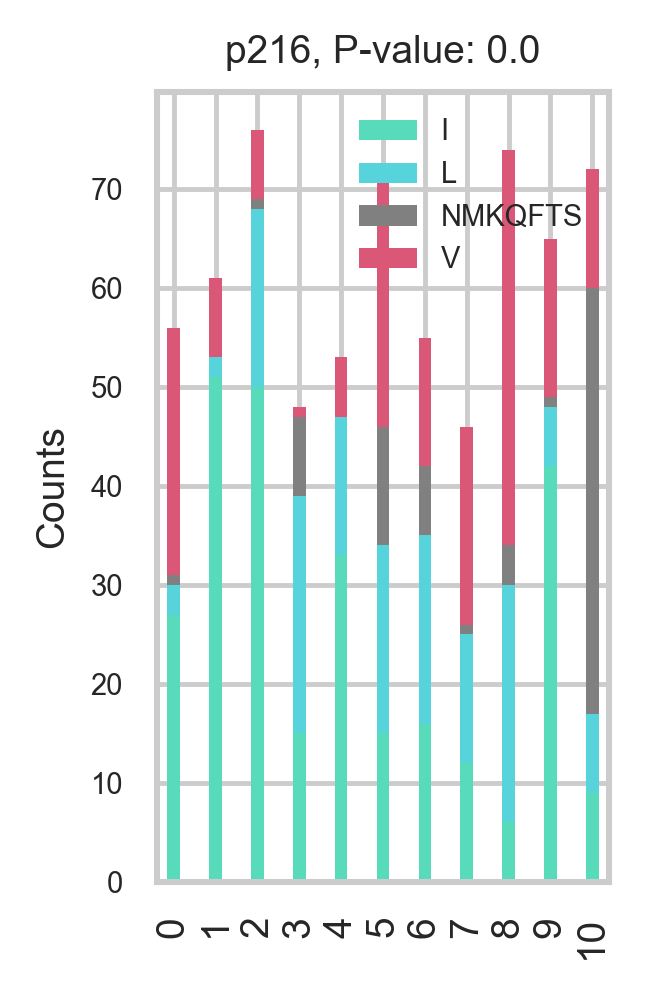

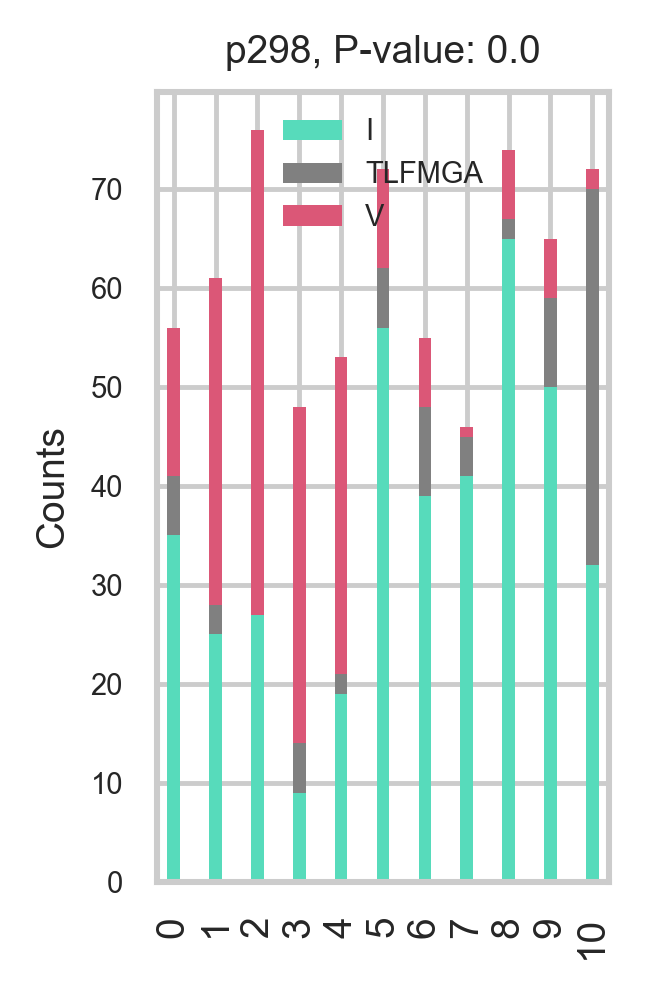

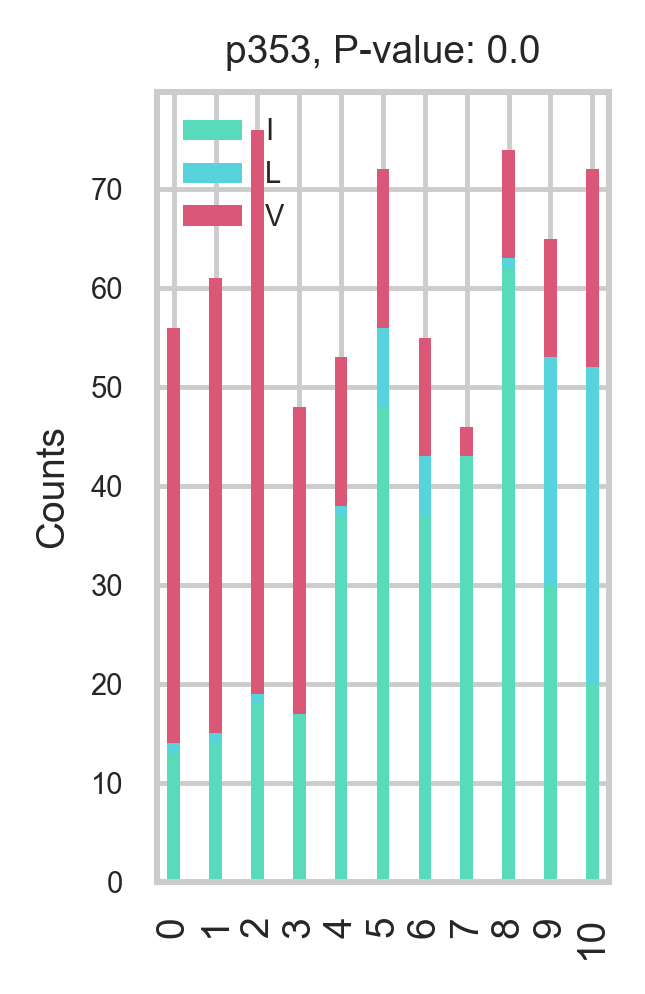

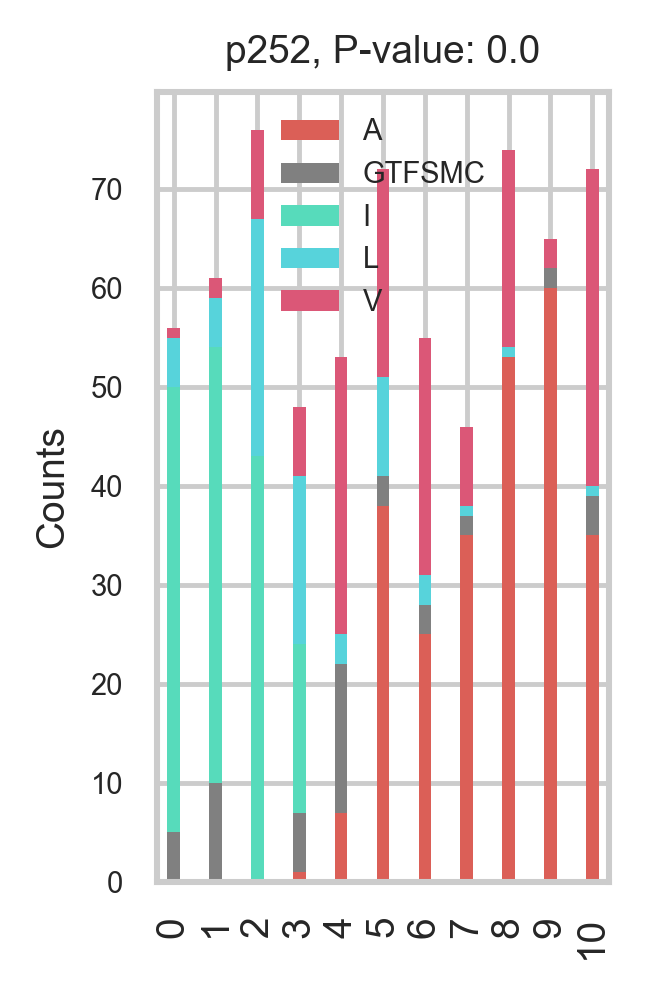

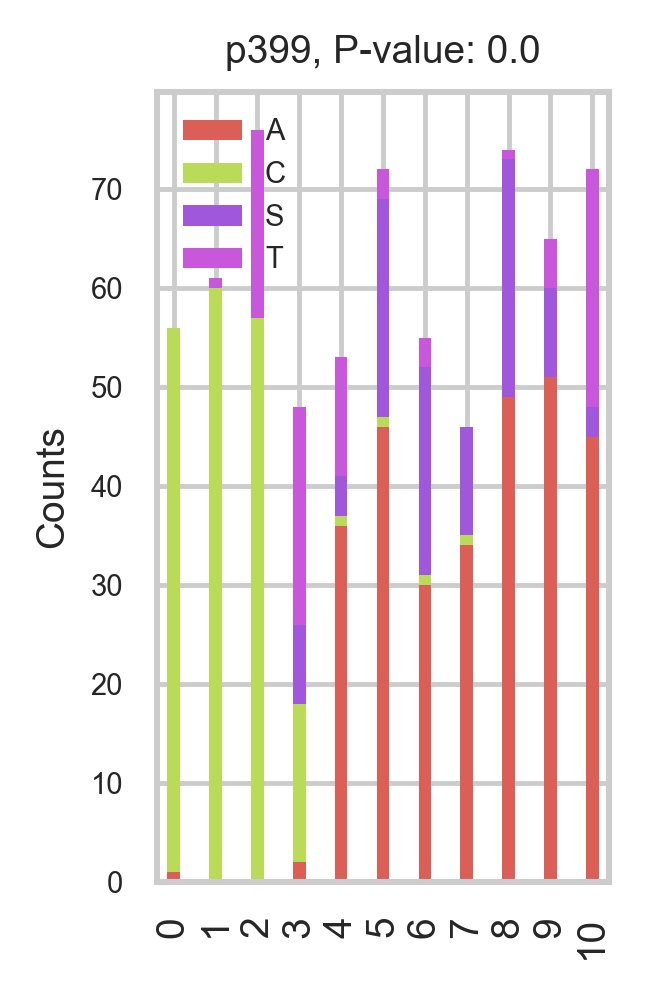

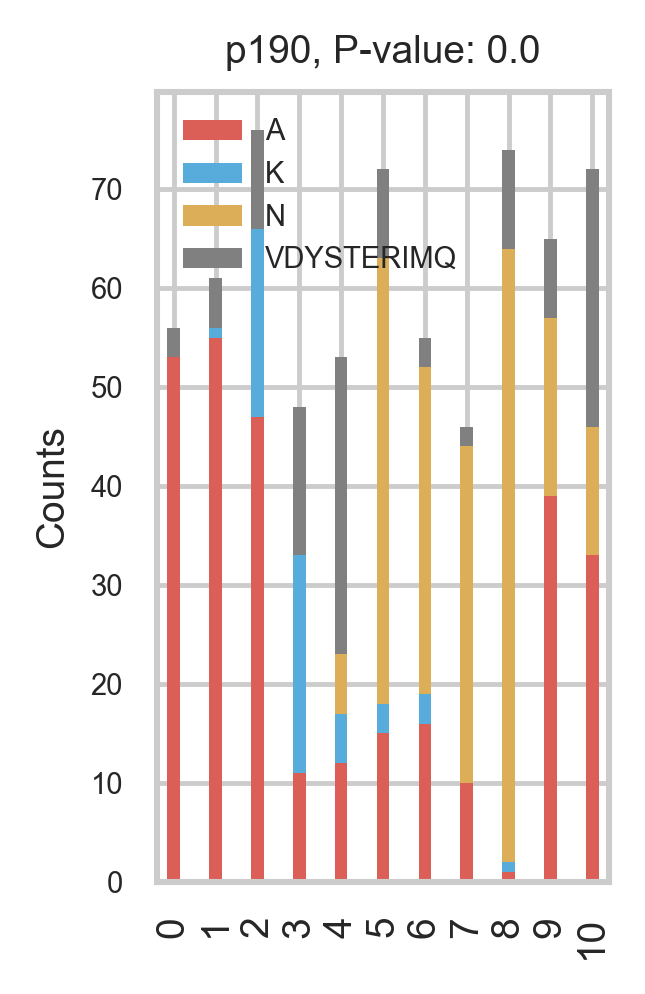

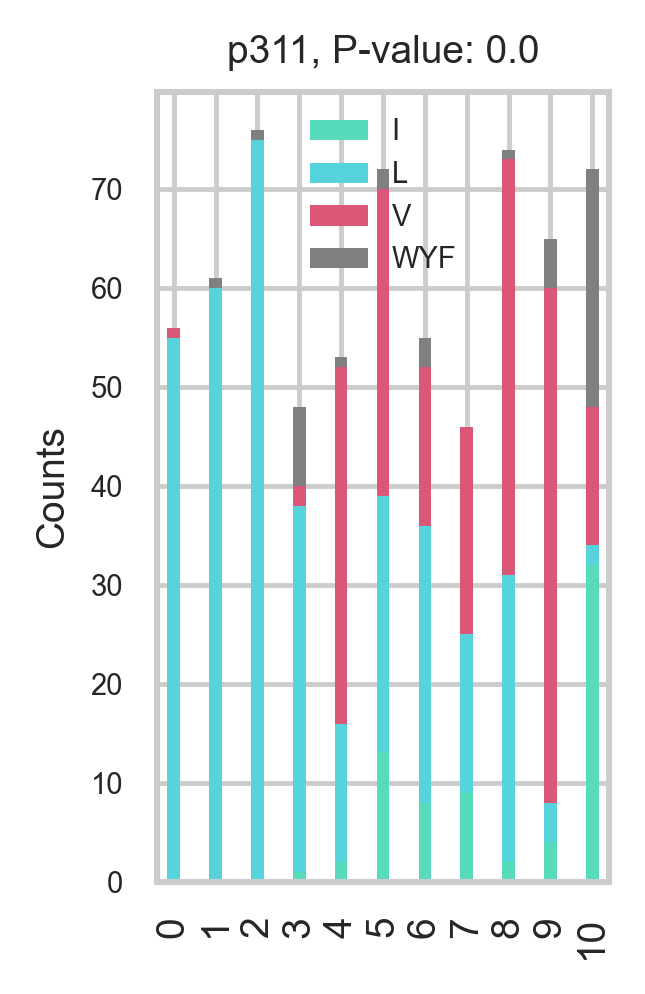

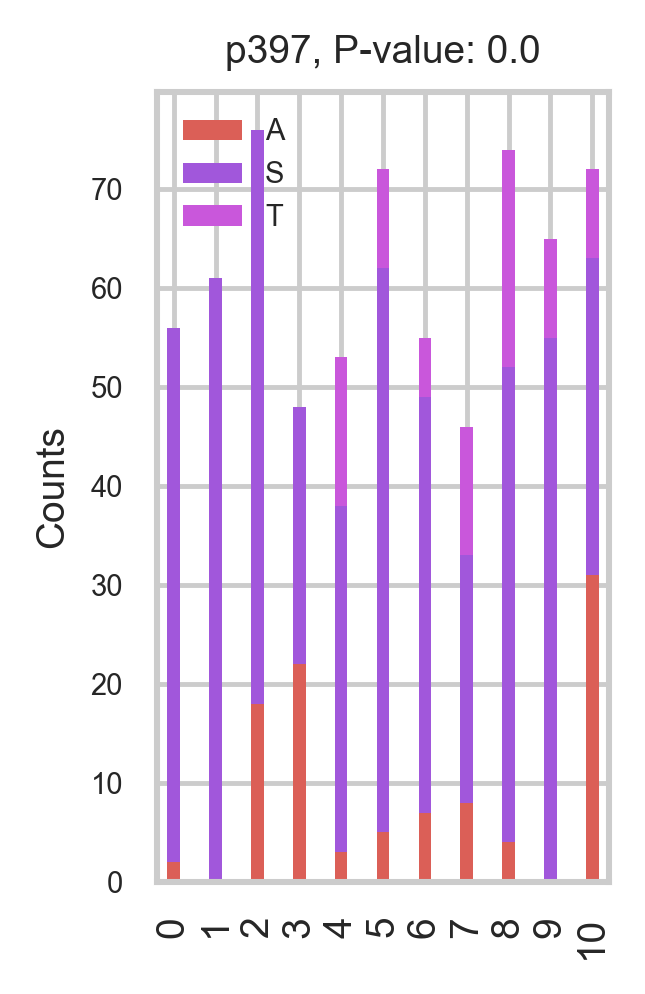

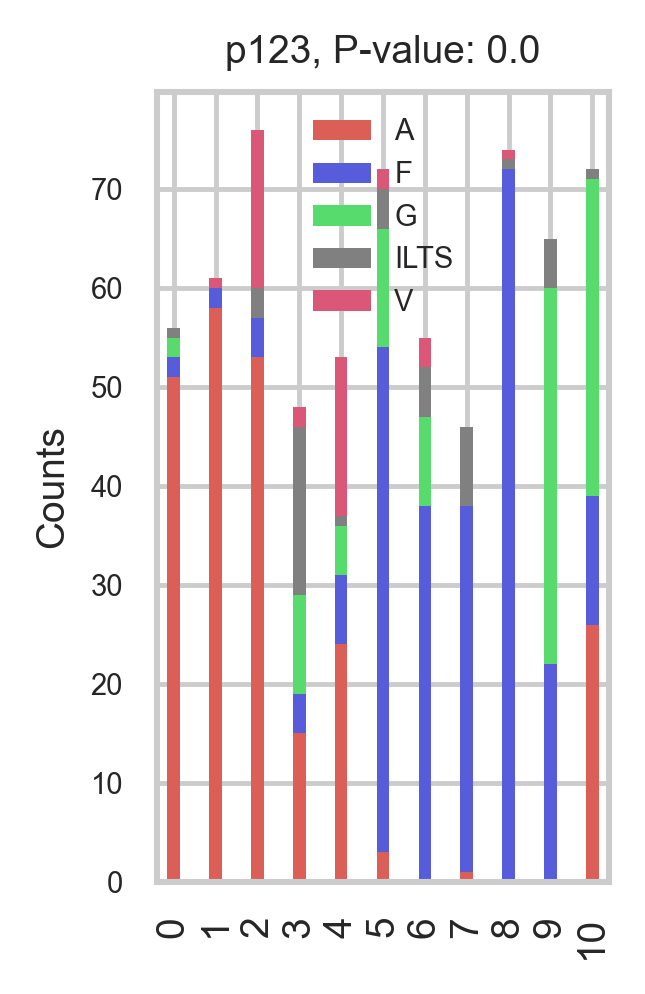

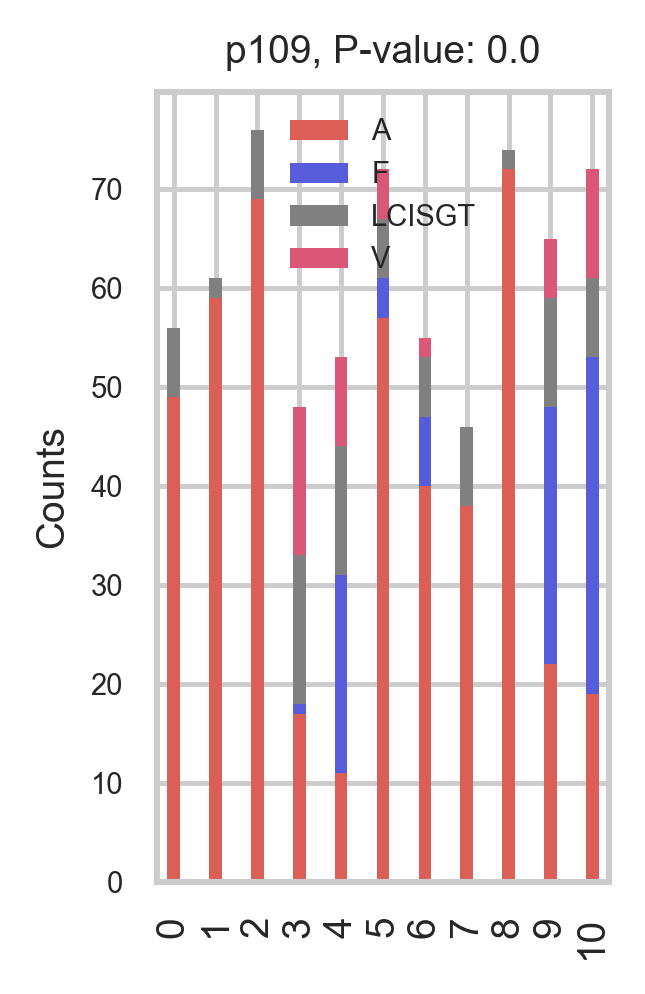

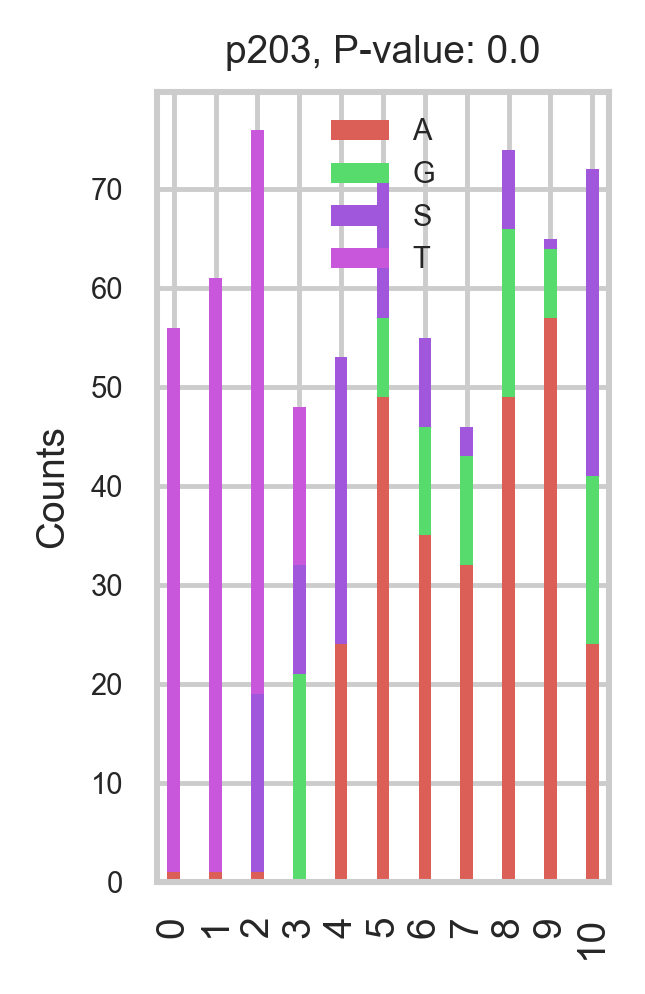

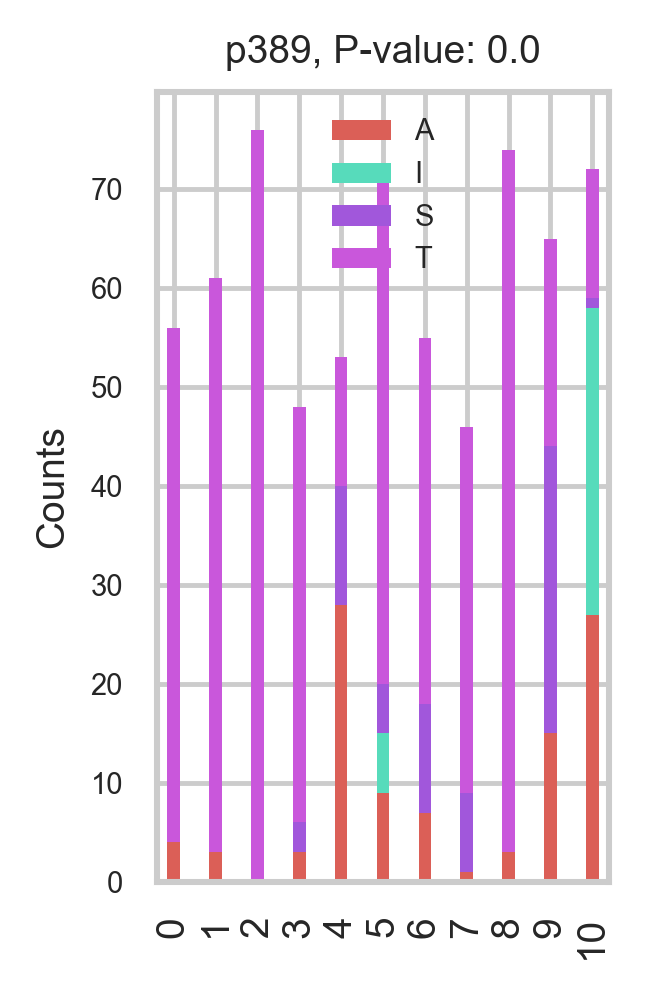

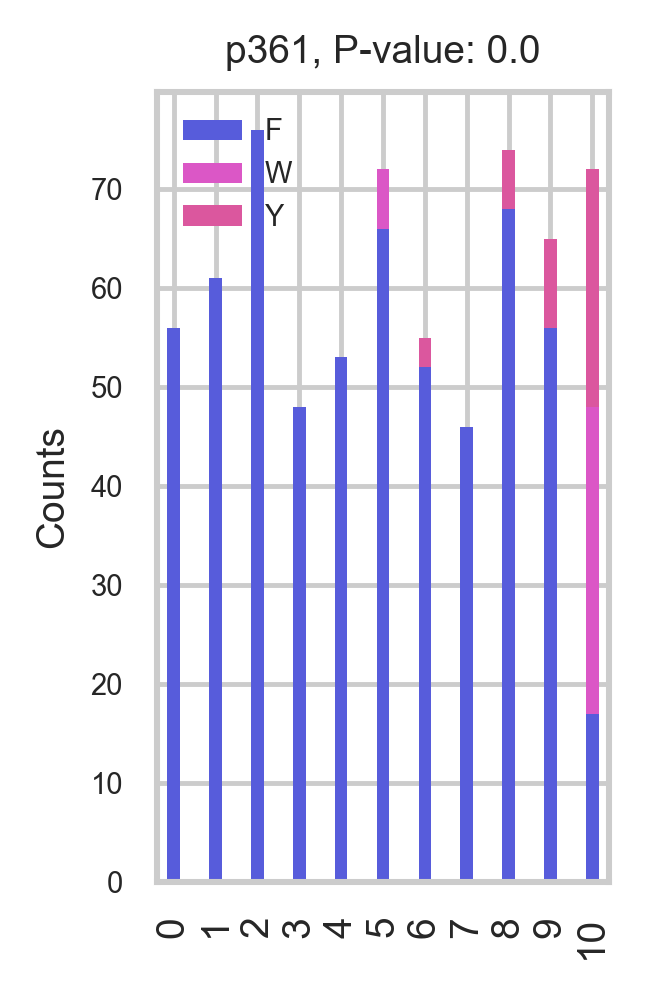

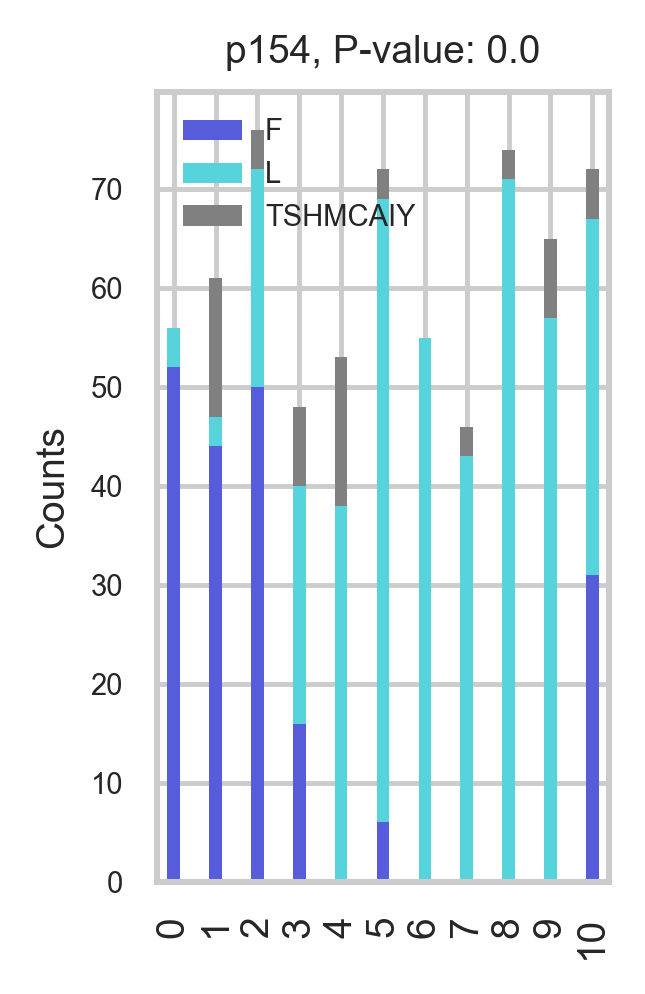

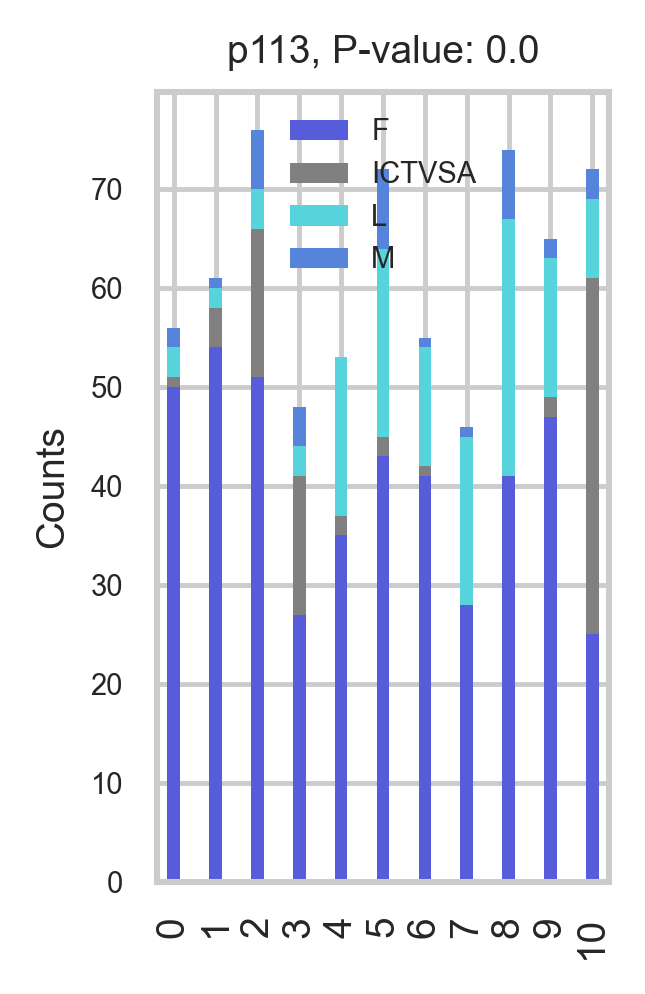

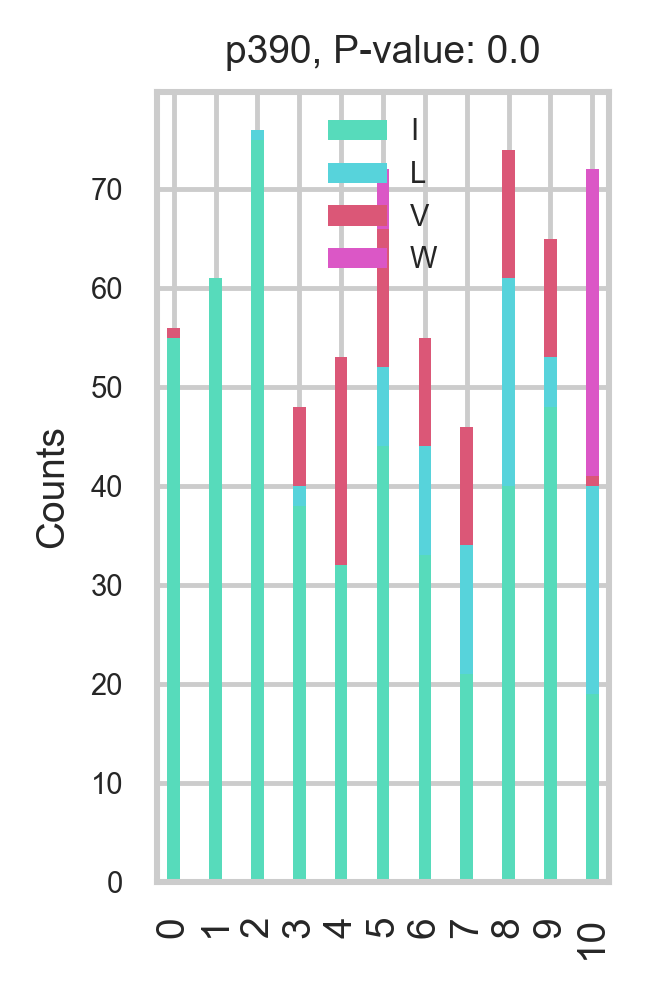

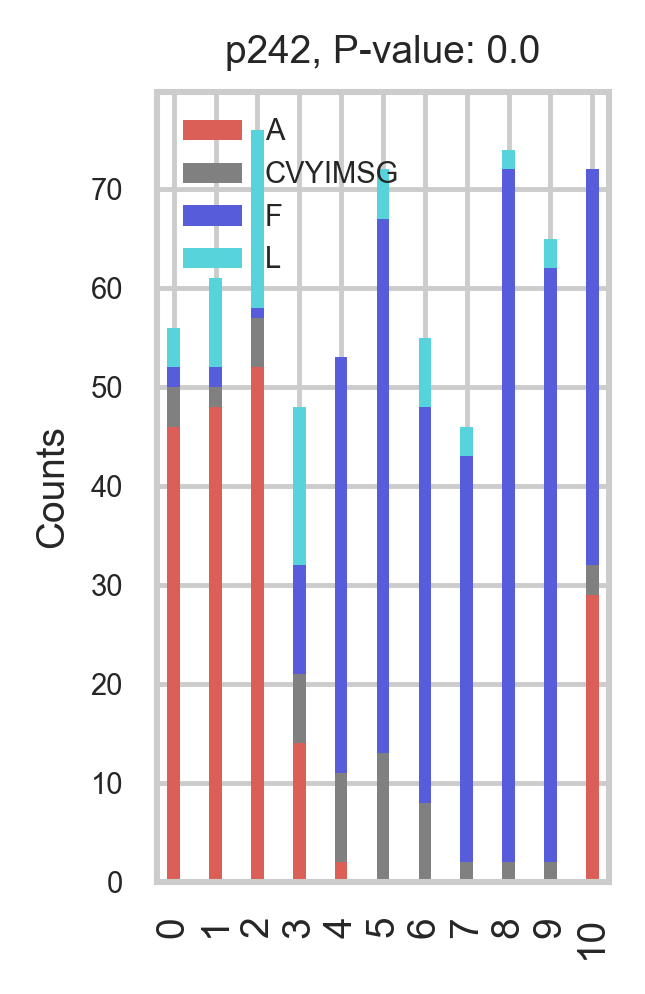

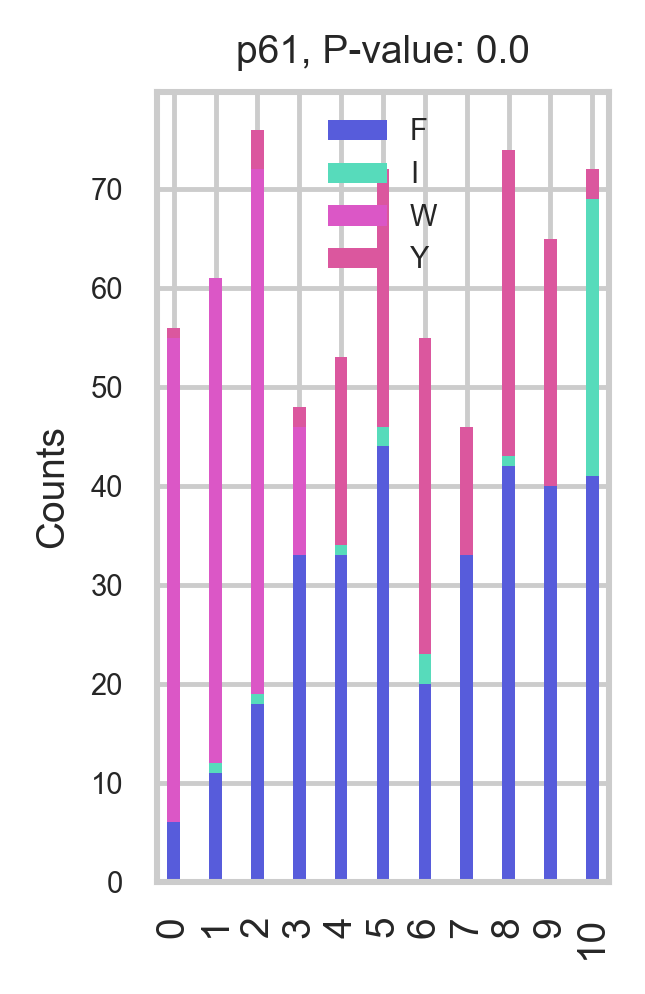

In [23]:
# visualizing top positions 
viz.plot_imp_all(trained_models=top_models, dat=df, train_cols=train_cols,
                 grouped_features=dc, meta_var=mt, model_type=anaType,
                 n_positions=positions, report_dir=report_dir)

In [30]:
import pandas as pd
models = pd.read_csv(report_dir+ '/models_summary.csv', index_col=0)

In [31]:
models

Model  Accuracy     AUC  Recall   Prec.  \
lightgbm  Light Gradient Boosting Machine    0.6635  0.9267  0.6487  0.6907   
xgboost         Extreme Gradient Boosting    0.6517  0.9201  0.6368  0.6763   
lr                    Logistic Regression    0.6478  0.9279  0.6268  0.6629   
gbc          Gradient Boosting Classifier    0.6438  0.9142  0.6274  0.6797   
ridge                    Ridge Classifier    0.6359  0.0000  0.6167  0.6404   
et                 Extra Trees Classifier    0.6202  0.8782  0.6089  0.6379   
rf               Random Forest Classifier    0.6182  0.9147  0.6045  0.6427   
dt               Decision Tree Classifier    0.5944  0.8083  0.5831  0.6239   
svm                   SVM - Linear Kernel    0.5888  0.0000  0.5744  0.6028   
ada                  Ada Boost Classifier    0.2736  0.6655  0.2172  0.1666   

              F1   Kappa     MCC  TT (Sec)  
lightgbm  0.6493  0.6211  0.6269     0.061  
xgboost   0.6430  0.6078  0.6121     0.406  
lr        0.6348  0.6031  0.6077     0.343  
gbc       0.6334  0.5987  0.6040     0.290  
ridge     0.6186  0.5891  0.5941     0.004  
et        0.6059  0.5728  0.5786     0.777  
rf        0.6038  0.5690  0.5753     0.057  
dt        0.5838  0.5443  0.5491     0.005  
svm       0.5654  0.5378  0.5461     0.008  
ada       0.1777  0.1436  0.1796     0.023

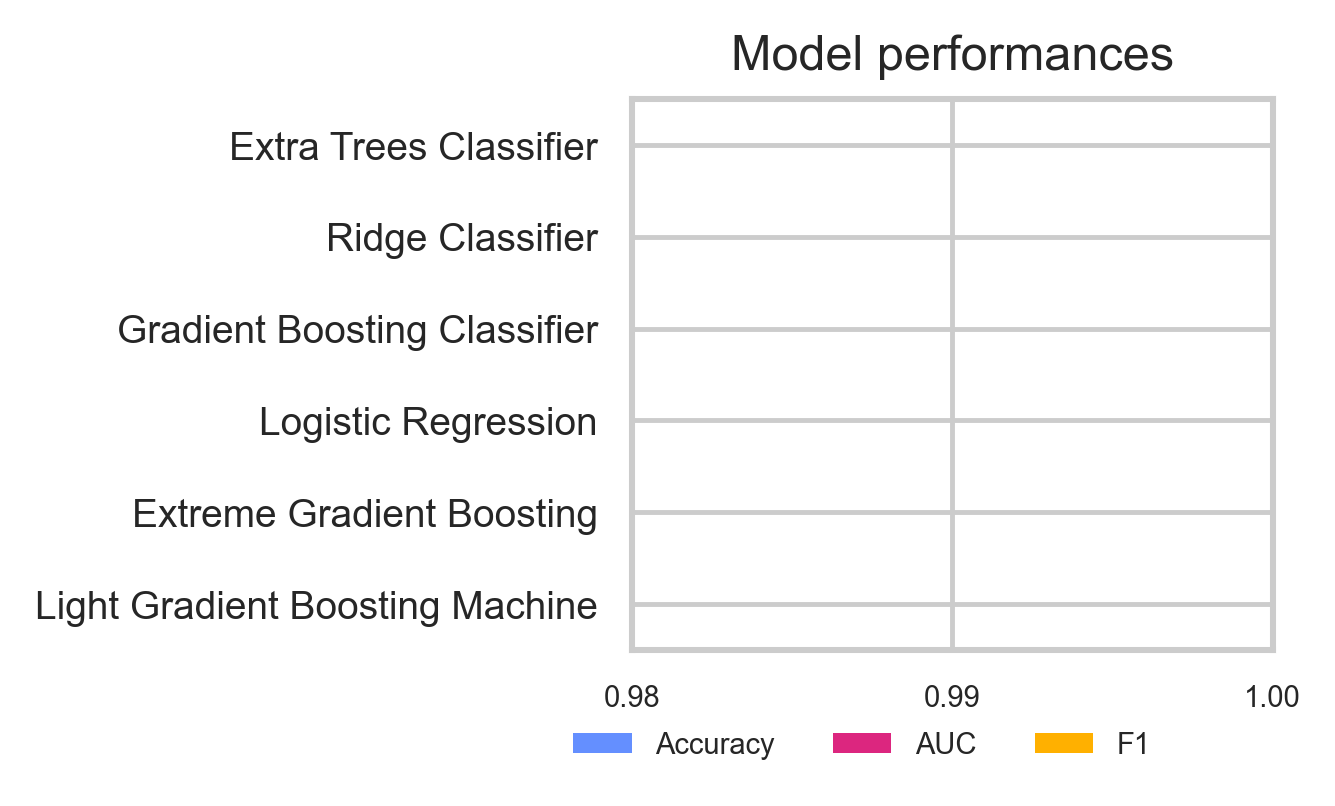

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 2.5), dpi=350)
fig = models.iloc[:6,].plot(x="Model", y=["Accuracy", "AUC", "F1"],
                           kind="barh",
                           color=['#648FFF', '#DC267F', '#FFB000'],
                           ax=ax,
                           ylim=(0,1))
ax.legend(bbox_to_anchor=(0.85, -.1), fontsize = 6, ncol=3)
ax.set_title('Model performances', fontsize=10)
ax.set_xlabel('')
plt.xticks(fontsize=6)
plt.ylabel('')
plt.xlim(.98,1)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig(str(report_dir + '/model_performances.pdf'),
                bbox_inches='tight')

# STEP 3.5: Classification Testing

In [33]:
x = 0
val = int(0)
data = list()
seq_dict = dict()
unseenData = 'unseendata.fasta' 
seq_type2 = 'amino-acid'
#Following creates a dataframe of aa sequences and their positions as collumns.
df = prp.read_data(unseenData, seq_type = seq_type2, is_main=True)
df.head()
#Turning sequence names into a list for indexing
seq_name = df.index.to_list()
print(seq_name)
#for every sequence in the list of sequences the following function will occur. 
for seq in seq_name:
    data = list()
    for col in training_col_list:
        #take the str of the column name and split at the '_'
        split = str(col).split('_')
        #declare a temp position variable to index df 
        position = str(split[0])
        print(position)
        #declare the aa we will compare the df index to
        aa = str(split[1])
        print(aa)
        count = len(aa)
        #index the df column corresponding to the 'position' variable
        s = df[position]
        #assign value based on whether the aa at some position matches the training_col aa 
        if (s[seq_name[x]] == aa):
            val = int(1)
        
        elif (count > 1):
            for n in range(count):
                amino = aa[n]
                
                if (s[seq_name[x]] == amino):
                    val = int(1)
                    break
                else:
                    val = int(0)   

        else:
            val = int(0)

        data.append(val)
        #print([type(i) for i in data])
        
    seq_dict.update({seq_name[x] : data})
    x+=1
print(seq_dict)
df_for_testing = pd.DataFrame(data = seq_dict.values() , columns = training_col_list, index = seq_dict.keys(), dtype = int)
print(df_for_testing.head())

file3 = open('fmt_data_cols.txt', 'w')
training = str(df_for_testing.to_string())
file3.write(training)
file3.close()

['Neogonodactylus_oerstedii|334|OPC0', 'Neogonodactylus_oerstedii|383|OPC2', 'Bombus_impatiens|539|OPC9', 'Bombus_impatiens|424|OPC3', 'Bombus_impatiens|347|OPC0', 'Drosophilia_melanogaster|486|OPC5', 'Drosophilia_melanogaster|418|OPC2', 'Drosophilia_melanogaster|331|OPC0', 'Drosophilia_melanogaster|355|OPC0', 'Drosophilia_melanogaster|442|OPC3', 'Drosophilia_melanogaster|515|OPC8', 'Lycaena_rubidus|360|OPC0/1', 'Lycaena_rubidus|437|OPC3', 'Lycaena_rubidus|500|OPC7', 'Lycaena_rubidus|568|OPC9', 'Vargula_tsujii|460|OPC4', 'V.tsujii_BCRH2_i7', 'V.tsujii_BCRH2_i0', 'V.tsujii_BCRH2_i6', 'V.tsujii_Rh6_i0', 'V.skogbergia_BCRH1_i1', 'V.skogbergia_BCRH2_i1', 'V.skogbergia_BCRH1_i5']
p120
E
p120
N
p120
S
p121
K
p121
M
p123
K
p133
Y
p134
GHMNTFILD
p134
R
p134
S
p135
I
p135
V
p136
V
p137
T
p138
I
p138
LCSTG
p138
V
p141
LIAVMCS
p142
F
p142
I
p142
L
p142
M
p145
F
p145
I
p145
L
p145
SAT
p145
V
p146
FGSMC
p146
I
p146
L
p146
T
p146
V
p148
L
p149
S
p150
V
p152
G
p152
ILTS
p152
V
p153
M
p161
F
p161
I
p1

In [54]:
#interact//model for classification
# save pipeline
plot_model(top_models[0], plot = "auc", use_train_data=True)
save_model(top_models[0], 'YOUR_MODEL_NAME')

# load pipeline
YOUR_MODEL_NAME = load_model('YOUR_MODEL_NAME')

#interpret_model(top_models[0])
 
prediction = predict_model(YOUR_MODEL_NAME, data = df_for_testing)

prediction.to_csv(path_or_buf="class_results.csv",mode="a")

ValueError: Plot Not Available for multiclass problems. Please see docstring for list of available Plots.

# <font color=red>STEP 4: Translate Candidate STSs</font>
## Optional step IF running the classifier model, but could still be useful.
### To find CSTSs, got to the deepBreaks output folder and find the excel sheet 'avg_top_models_feature_importance'
### Sort the top model's feature importance column by 'largest-to-smallest' and take x# of those positions.

In [ ]:
#STEP 4: Translate Candidate STSs 
#Optional step IF running the classifier model, but could still be useful.
#To find CSTSs, got to the deepBreaks output folder and find the excel sheet 'avg_top_models_feature_importance'
#Sort the top model's feature importance column by 'largest-to-smallest' and take x# of those positions.
#enter list of candidate STSs below
impsites = input("Enter list CSTSs: ")
#enter desired name of output text file.
#eg - If I'm translating sites from a LRM for the rods subset of my dataset I would have the output text file be named...
#output = rod_csts.txt
output = input("Enter Name of Output File: ")
seq = input("Enter Aligned Bovine Sequence: ")
site_list = impsites.split(',')
m = 0
tm = ''

#take the list of important sites and translate them to the bovine standard equivalent, we do this by taking the site number and subtracting the number of '-' between the start of the sequence and the desired site. 
for sites in site_list:

    k = int(sites)    
    gaps = seq[:k].count('-')
    #print("The number of gaps is " + str(gaps))
    trans_site = k - gaps

    if trans_site in range(39,65):
        tm = 'TM1'
    elif trans_site in range(72,99):
        tm = 'TM2'
    elif trans_site in range(110,140):
        tm = 'TM3'
    elif trans_site in range(151,173):
        tm = 'TM4'
    elif trans_site in range(200,230):
        tm = 'TM5'
    elif trans_site in range(245,275):
        tm = 'TM6'
    elif trans_site in range(285,310):
        tm = 'TM7'
    else:
        tm = 'Not in TM Region'
    

    #print(f"For site {k} the bovine equivalent is {trans_site}") 

    with open(output, 'a') as f:
        if m == 0:
                f.write("The following sites have been translated to the standard Bovine equivalent...\nFormat is before translation --> post translation to bovine equivalent.")   
                m+=1 
        f.write(f"Site {k} == {trans_site} // In {tm}\n")      

# <font color=red>Step 5: Graphing Test Results -</font>

In [1]:
import matplotlib.pyplot as p
import matplotlib.colors as colors
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import argparse
import seaborn as sns
from statistics import mean



The Following Code block turns the mean wavelength of the class range into its hex code equivalent. 


In [2]:
class_assignment = "classifier_ranges.tsv"
classes = pd.read_csv(class_assignment, delimiter='\t')
class_list = []

for c in classes['Class_Ranges']:
    print(c)
    class_list.append(c)
    print(class_list)

hex_list = []

for waves in class_list:
    gamma = 0.8
    intensity_max = 1
    wave = waves
    if wave < 380:
            red, green, blue = 0, 0, 0
    elif wave < 440:
        red = -(wave - 440) / (440 - 380)
        green, blue = 0, 1
    elif wave < 490:
        red = 0
        green = (wave - 440) / (490 - 440)
        blue = 1
    elif wave < 510:
        red, green = 0, 1
        blue = -(wave - 510) / (510 - 490)
    elif wave < 580:
        red = (wave - 510) / (580 - 510)
        green, blue = 1, 0
    elif wave < 645:
        red = 1
        green = -(wave - 645) / (645 - 580)
        blue = 0
    elif wave <= 780:
        red, green, blue = 1, 0, 0
    else:
        red, green, blue = 0, 0, 0

    # let the intensity fall of near the vision limits
    if wave < 380:
        factor = 0
    elif wave < 420:
        factor = 0.3 + 0.7 * (wave - 380) / (420 - 380)
    elif wave < 700:
        factor = 1
    elif wave <= 780:
        factor = 0.3 + 0.7 * (780 - wave) / (780 - 700)
    else:
        factor = 0

    def f(c):
        if c == 0:
                return 0
        else:
                return intensity_max * pow (c * factor, gamma)
        
    #color = f"{f(red)},{f(green)},{f(blue)}"
    color = [f(green),f(blue),f(red)] 
    print(color)
    hex = colors.rgb2hex(color, keep_alpha=True)
    hex_list.append(hex)

print(hex_list)

340
[340]
360
[340, 360]
380
[340, 360, 380]
420
[340, 360, 380, 420]
450
[340, 360, 380, 420, 450]
480
[340, 360, 380, 420, 450, 480]
490
[340, 360, 380, 420, 450, 480, 490]
495
[340, 360, 380, 420, 450, 480, 490, 495]
505
[340, 360, 380, 420, 450, 480, 490, 495, 505]
520
[340, 360, 380, 420, 450, 480, 490, 495, 505, 520]
560
[340, 360, 380, 420, 450, 480, 490, 495, 505, 520, 560]
[0, 0, 0]
[0, 0, 0]
[0, 0.3816778909618176, 0.3816778909618176]
[0, 1.0, 0.41524364653850576]
[0.27594593229224296, 1.0, 0]
[0.8365116420730186, 1.0, 0]
[1.0, 1.0, 0]
[1.0, 0.7944178807866091, 0]
[1.0, 0.32987697769322355, 0]
[1.0, 0, 0.21082473737065027]
[1.0, 0, 0.7640074112321921]
['#000000ff', '#000000ff', '#006161ff', '#00ff6aff', '#46ff00ff', '#d5ff00ff', '#ffff00ff', '#ffcb00ff', '#ff5400ff', '#ff0036ff', '#ff00c3ff']


The following code takes a csv of predicitons and plots those predicttions relative to the knowns. 

#000000ff
#000000ff
#006161ff
#00ff6aff
#46ff00ff
#d5ff00ff
#ffff00ff
#ffcb00ff
#ff5400ff
#ff0036ff
Annotation(350, 550, 'r^2 = 0.894')


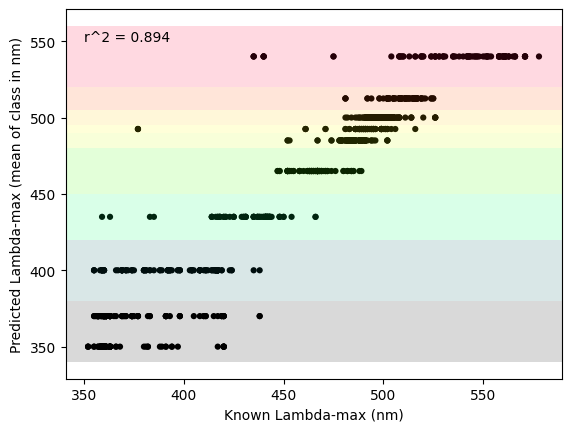

In [4]:
file = "wds_classifier_test_results_t2.csv"
outfile = "100_iterations_plot"
#https://academo.org/demos/wavelength-to-colour-relationship/

#Read data
table = pd.read_csv(file, delimiter = ',')

#Duplicate predicted class next to change to actual lmax 
table['Predicted_lmax'] = table.loc[:, 'Predicted_Class']
i = 0
for colors in class_list:
#Convert class values to median lambda max value of that class in new column
    if i+1 != len(class_list):
        table['Predicted_lmax'] = table['Predicted_lmax'].replace(i,mean([class_list[i],class_list[i+1]]))
        i+=1
    else: 
        pass


colorby='Score'

#2d
sns.scatterplot(x='Lambda_Max', y='Predicted_lmax', data=table, edgecolor = 'none', color = 'black', s = 20)
plt.xlabel('Known Lambda-max (nm)')
plt.ylabel('Predicted Lambda-max (mean of class in nm)')

i = 0
alpha = 0.05
for wavelengths in class_list:
    if i+1 < len(hex_list):
        print(hex_list[i])
        plt.axhspan(class_list[i],class_list[i+1], facecolor=hex_list[i], alpha=0.15)
        i+=1
    else: 
        pass
    #place colored bands behind plot

m = plt.annotate("r^2 = {:.3f}".format(r2_score(table['Lambda_Max'],table['Predicted_lmax'])), (350, 550))
print(m)
#If no file name show on screen otherwise save pdf
if outfile == '' :
    plt.show()
else:
    fileout = outfile + '.pdf'
    plt.savefig(fileout)


# <font color=red>Step 6: Earth Movers Distance (EMD) of Test Results -</font>

In [5]:
from scipy.stats import wasserstein_distance

In [6]:
#Going to automate this soon. For now I did a hard-coded example. 
whole_matrix = wasserstein_distance([15,1,1,0,0,0,0,0,0,0,5,8,4,0,0,0,0,0,0,0,5,5,18,1,0,0,1,0,0,0,0,1,3,10,2,1,0,0,0,1,0,0,0,0,15,0,0,0,0,0,0,0,0,0,3,14,2,1,0,0,0,0,0,0,0,5,4,6,1,0,0,0,0,0,0,2,0,37,1,0,0,0,0,0,0,0,0,3,13,3,0,0,0,0,0,0,0,0,1,25],
                                    [17,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,26],
                                    [0,1,2,3,4,5,6,7,8,9,1,0,1,2,3,4,5,6,7,8,2,1,0,1,2,3,4,5,6,7,3,2,1,0,1,2,3,4,5,6,4,3,2,1,0,1,2,3,4,5,5,4,3,2,1,0,1,2,3,4,6,5,4,3,2,1,0,1,2,3,7,6,5,4,3,2,1,0,1,2,8,7,6,5,4,3,2,1,0,1,9,8,7,6,5,4,3,2,1,0],
                                    [0,1,2,3,4,5,6,7,8,9,1,0,1,2,3,4,5,6,7,8,2,1,0,1,2,3,4,5,6,7,3,2,1,0,1,2,3,4,5,6,4,3,2,1,0,1,2,3,4,5,5,4,3,2,1,0,1,2,3,4,6,5,4,3,2,1,0,1,2,3,7,6,5,4,3,2,1,0,1,2,8,7,6,5,4,3,2,1,0,1,9,8,7,6,5,4,3,2,1,0])
whole_matrix = str(whole_matrix)
print("EMD for the Confusion Matrix is " + whole_matrix)

EMD for the Confusion Matrix is 0.23939393939393938
